# 6. Defending against the Gradient Attack, using Defensive Distillation

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.2 (06/07/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.1)
- Numpy (tested on v1.24.3)
- Pillow (tested on v9.3.0)
- Torch (tested on v2.0.1+cu118)
- Torchvision (tested on v0.15.2+cu118)

### Imports

In [1]:
# Future
from __future__ import print_function
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Torchvision
from torchvision import datasets, transforms

In [2]:
# NOTE: This is a fix to work around the "User-agent" issue 
# when downloading the MNIST dataset
from six.moves import urllib
opener_req = urllib.request.build_opener()
opener_req.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener_req)

### CUDA Setup

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


### Dataset and Dataloader

In [4]:
# Transform definition
# (Basic: only convert image to torch tensor)
tf = transforms.Compose([transforms.ToTensor()])
# MNIST dataset and dataloader
# (For testing only, we will use a pre-trained model)
ds = datasets.MNIST('./data', train = False, download = True, transform = tf)
test_loader = torch.utils.data.DataLoader(ds, batch_size = 1, shuffle = True)

### Loading a pre-trained model

As in previous notebooks.

In [5]:
# Model definition
class Net(nn.Module):
    """
    This is a basic Neural Net for MNIST
    - Two convolutions, into ReLU activations and dropouts after ReLU,
    - Flattening,
    - Fully connected, into ReLU activation and dropout after ReLU,
    - Fully connected, into Log-Softmax.
    """
    
    def __init__(self):
        super(Net, self).__init__()
        # Conv. 1
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        # Conv. 2
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        # Dropout for Conv. layers
        self.conv2_drop = nn.Dropout2d()
        # FC 1
        self.fc1 = nn.Linear(320, 50)
        # FC 2
        self.fc2 = nn.Linear(50, 10)
        # Temperature (set to 1 by default)
        self.T = 1

    def forward(self, x):
        # Conv. 1 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # Conv. 2 + ReLU + Dropout
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten
        x = x.view(-1, 320)
        # FC 1 + ReLU + Droupout 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        # FC 2 + Log-Softmax
        x = self.fc2(x)
        return F.log_softmax(x/self.T, dim = 1)

In [6]:
# Load the pretrained model
model = Net()
pretrained_model = "./mnist_model.data"
model.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
# Set the model in evaluation mode
# (Important, because we have dropout layers!)
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Untargeted Gradient Method (UGM) attack function

As in notebook 2.

In [8]:
def ugm_attack(image, epsilon, data_grad):
    
    # Create the attack image by adjusting each pixel of the input image
    eps_image = image + epsilon*data_grad
    
    # Clipping eps_image to maintain pixel values into the [0, 1] range
    eps_image = torch.clamp(eps_image, 0, 1)
    
    # Return
    return eps_image

### Testing UGM attacks on our model

As in previous notebooks.

In [9]:
def test(model, device, test_loader, epsilon):
    
    # Counter for correct values (used for accuracy)
    correct_counter = 0
    
    # List of successful adversarial samples
    adv_examples_list = []

    # Loop over all examples in test set
    for image, label in test_loader:

        # Send the data and label to the device
        image, label = image.to(device), label.to(device)

        # Set requires_grad attribute of tensor to force torch to
        # keep track of the gradients of the image
        # (Needed for the fgsm_attack() function!)
        image.requires_grad = True

        # Pass the image through the model
        output = model(image)
        # Get the index of the max log-probability
        init_pred = output.max(1, keepdim = True)[1] 

        # If the initial prediction is wrong, do not bother attacking, skip current image
        if init_pred.item() != label.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, label)

        # Zero all existing gradients
        model.zero_grad()

        # Backpropagate
        loss.backward()

        # Collect gradients of image
        data_grad = image.grad.data

        # Call FGSM Attack
        eps_image = ugm_attack(image, epsilon, data_grad)

        # Re-classify the epsilon image
        output2 = model(eps_image)
        # Get the index of the max log-probability
        eps_pred = output2.max(1, keepdim = True)[1]

        # Check for successful attack
        # (Successful meaning eps_pred label different from init_pred)
        if eps_pred.item() == label.item():
            correct_counter += 1
            # Special case for saving 0 epsilon examples
            # (Maximal number of saved samples is set to 5)
            if (epsilon == 0) and (len(adv_examples_list) < 5):
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            # (Maximal number of saved samples is set to 5)
            if len(adv_examples_list) < 5:
                adv_ex = eps_image.squeeze().detach().cpu().numpy()
                adv_examples_list.append((init_pred.item(), eps_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon value
    final_acc = correct_counter/float(len(test_loader))
    
    # Display for progress
    print("Epsilon: {} - Test Accuracy = {}/{} = {}".format(epsilon, \
                                                            correct_counter, \
                                                            len(test_loader), \
                                                            final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples_list

In [10]:
epsilons = [0, 0.2, 0.4, 0.8, 1, 2, 5]
accuracies = []
examples = []

# Run test() function for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0 - Test Accuracy = 9810/10000 = 0.981
Epsilon: 0.2 - Test Accuracy = 9702/10000 = 0.9702
Epsilon: 0.4 - Test Accuracy = 9622/10000 = 0.9622
Epsilon: 0.8 - Test Accuracy = 9404/10000 = 0.9404
Epsilon: 1 - Test Accuracy = 9285/10000 = 0.9285
Epsilon: 2 - Test Accuracy = 8782/10000 = 0.8782
Epsilon: 5 - Test Accuracy = 7429/10000 = 0.7429


### Visualization (accuracies vs. epsilon values and adversarial samples)

As in previous notebooks.

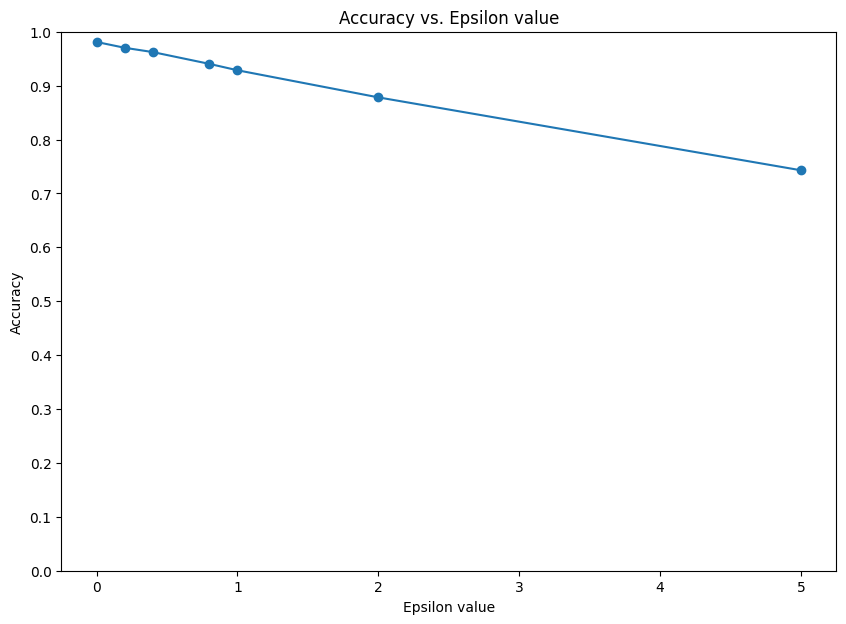

In [11]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
#plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy vs. Epsilon value")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

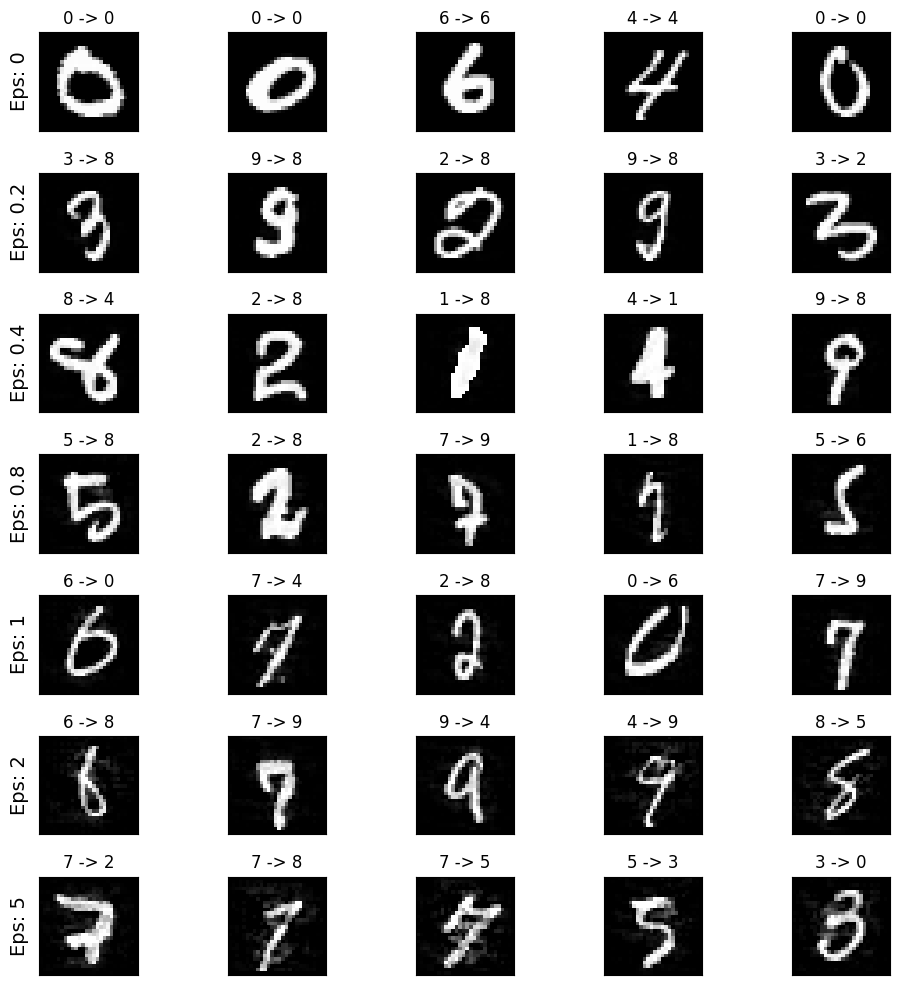

In [12]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (10, 10))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Display image
        plt.imshow(ex, cmap = "gray")
        
# Display full plot
plt.tight_layout()
plt.show()

### Creating a second model, retraining with defense

As in previous notebook.

In [13]:
# Load the pretrained model
model2 = Net()
pretrained_model = "./mnist_model.data"
model2.load_state_dict(torch.load(pretrained_model, map_location = 'cpu'))
model2.to(device)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [14]:
# MNIST dataset and dataloader
# (Using the training set this time)
ds2 = datasets.MNIST('./data', train = True, download = True, transform = tf)
train_loader = torch.utils.data.DataLoader(ds2, batch_size = 64, shuffle = True)

In [15]:
print(len(train_loader))

938


This time we will retrain on normal samples, no UGM attack samples are used.

Towards the end of training we will increase the temperature of the softmax to a high value to hopefully destroy the gradients and make them unusable by attackers.

In [16]:
# Define a loss function and an optimizer for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr = 0.001, momentum = 0.9)

In [17]:
# Setting temperature to 100 for training
model2.T = 100

In [20]:
def retrain(model, train_loader, optimizer, criterion, n_iter = 10):
    
    # This will make prints happen every 50 mini-batches
    mod_val = 50
    
    # Train over n_iter epochs
    for epoch in range(n_iter):
        
        # Keep track of the running losses over batches
        running_loss_normal = 0.0
        
        for i, data in enumerate(train_loader):

            # Retrieve input images and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs.requires_grad = True

            # Zeroing gradients
            optimizer.zero_grad()

            # Forward, Loss, Backprop, Optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Keep track of running loss (normal samples)
            running_loss_normal += loss.item()
            
            # Display for progress
            if i != 1:
                str1 = '[Epoch %d, Batch %5d] Loss: %.3f' %(epoch + 1, i + 1, running_loss_normal/(i+1))
                print(str1)

Retraining produces minimal results because the model was already trained.

In [21]:
retrain(model2, train_loader, optimizer, criterion, n_iter = 50)

[Epoch 1, Batch     1] Loss: 2.261
[Epoch 1, Batch     3] Loss: 2.261
[Epoch 1, Batch     4] Loss: 2.260
[Epoch 1, Batch     5] Loss: 2.259
[Epoch 1, Batch     6] Loss: 2.259
[Epoch 1, Batch     7] Loss: 2.260
[Epoch 1, Batch     8] Loss: 2.260
[Epoch 1, Batch     9] Loss: 2.260
[Epoch 1, Batch    10] Loss: 2.260
[Epoch 1, Batch    11] Loss: 2.260
[Epoch 1, Batch    12] Loss: 2.260
[Epoch 1, Batch    13] Loss: 2.260
[Epoch 1, Batch    14] Loss: 2.260
[Epoch 1, Batch    15] Loss: 2.260
[Epoch 1, Batch    16] Loss: 2.260
[Epoch 1, Batch    17] Loss: 2.260
[Epoch 1, Batch    18] Loss: 2.260
[Epoch 1, Batch    19] Loss: 2.260
[Epoch 1, Batch    20] Loss: 2.260
[Epoch 1, Batch    21] Loss: 2.260
[Epoch 1, Batch    22] Loss: 2.260
[Epoch 1, Batch    23] Loss: 2.260
[Epoch 1, Batch    24] Loss: 2.259
[Epoch 1, Batch    25] Loss: 2.259
[Epoch 1, Batch    26] Loss: 2.259
[Epoch 1, Batch    27] Loss: 2.259
[Epoch 1, Batch    28] Loss: 2.259
[Epoch 1, Batch    29] Loss: 2.259
[Epoch 1, Batch    3

[Epoch 1, Batch   247] Loss: 2.250
[Epoch 1, Batch   248] Loss: 2.250
[Epoch 1, Batch   249] Loss: 2.250
[Epoch 1, Batch   250] Loss: 2.250
[Epoch 1, Batch   251] Loss: 2.250
[Epoch 1, Batch   252] Loss: 2.250
[Epoch 1, Batch   253] Loss: 2.250
[Epoch 1, Batch   254] Loss: 2.250
[Epoch 1, Batch   255] Loss: 2.250
[Epoch 1, Batch   256] Loss: 2.250
[Epoch 1, Batch   257] Loss: 2.250
[Epoch 1, Batch   258] Loss: 2.249
[Epoch 1, Batch   259] Loss: 2.249
[Epoch 1, Batch   260] Loss: 2.249
[Epoch 1, Batch   261] Loss: 2.249
[Epoch 1, Batch   262] Loss: 2.249
[Epoch 1, Batch   263] Loss: 2.249
[Epoch 1, Batch   264] Loss: 2.249
[Epoch 1, Batch   265] Loss: 2.249
[Epoch 1, Batch   266] Loss: 2.249
[Epoch 1, Batch   267] Loss: 2.249
[Epoch 1, Batch   268] Loss: 2.249
[Epoch 1, Batch   269] Loss: 2.249
[Epoch 1, Batch   270] Loss: 2.249
[Epoch 1, Batch   271] Loss: 2.249
[Epoch 1, Batch   272] Loss: 2.249
[Epoch 1, Batch   273] Loss: 2.249
[Epoch 1, Batch   274] Loss: 2.249
[Epoch 1, Batch   27

[Epoch 1, Batch   499] Loss: 2.238
[Epoch 1, Batch   500] Loss: 2.238
[Epoch 1, Batch   501] Loss: 2.238
[Epoch 1, Batch   502] Loss: 2.238
[Epoch 1, Batch   503] Loss: 2.238
[Epoch 1, Batch   504] Loss: 2.238
[Epoch 1, Batch   505] Loss: 2.238
[Epoch 1, Batch   506] Loss: 2.238
[Epoch 1, Batch   507] Loss: 2.238
[Epoch 1, Batch   508] Loss: 2.238
[Epoch 1, Batch   509] Loss: 2.238
[Epoch 1, Batch   510] Loss: 2.238
[Epoch 1, Batch   511] Loss: 2.238
[Epoch 1, Batch   512] Loss: 2.238
[Epoch 1, Batch   513] Loss: 2.238
[Epoch 1, Batch   514] Loss: 2.238
[Epoch 1, Batch   515] Loss: 2.238
[Epoch 1, Batch   516] Loss: 2.238
[Epoch 1, Batch   517] Loss: 2.237
[Epoch 1, Batch   518] Loss: 2.237
[Epoch 1, Batch   519] Loss: 2.237
[Epoch 1, Batch   520] Loss: 2.237
[Epoch 1, Batch   521] Loss: 2.237
[Epoch 1, Batch   522] Loss: 2.237
[Epoch 1, Batch   523] Loss: 2.237
[Epoch 1, Batch   524] Loss: 2.237
[Epoch 1, Batch   525] Loss: 2.237
[Epoch 1, Batch   526] Loss: 2.237
[Epoch 1, Batch   52

[Epoch 1, Batch   752] Loss: 2.223
[Epoch 1, Batch   753] Loss: 2.223
[Epoch 1, Batch   754] Loss: 2.223
[Epoch 1, Batch   755] Loss: 2.223
[Epoch 1, Batch   756] Loss: 2.223
[Epoch 1, Batch   757] Loss: 2.223
[Epoch 1, Batch   758] Loss: 2.223
[Epoch 1, Batch   759] Loss: 2.223
[Epoch 1, Batch   760] Loss: 2.223
[Epoch 1, Batch   761] Loss: 2.223
[Epoch 1, Batch   762] Loss: 2.223
[Epoch 1, Batch   763] Loss: 2.223
[Epoch 1, Batch   764] Loss: 2.223
[Epoch 1, Batch   765] Loss: 2.222
[Epoch 1, Batch   766] Loss: 2.222
[Epoch 1, Batch   767] Loss: 2.222
[Epoch 1, Batch   768] Loss: 2.222
[Epoch 1, Batch   769] Loss: 2.222
[Epoch 1, Batch   770] Loss: 2.222
[Epoch 1, Batch   771] Loss: 2.222
[Epoch 1, Batch   772] Loss: 2.222
[Epoch 1, Batch   773] Loss: 2.222
[Epoch 1, Batch   774] Loss: 2.222
[Epoch 1, Batch   775] Loss: 2.222
[Epoch 1, Batch   776] Loss: 2.222
[Epoch 1, Batch   777] Loss: 2.222
[Epoch 1, Batch   778] Loss: 2.222
[Epoch 1, Batch   779] Loss: 2.222
[Epoch 1, Batch   78

[Epoch 2, Batch    54] Loss: 2.119
[Epoch 2, Batch    55] Loss: 2.118
[Epoch 2, Batch    56] Loss: 2.119
[Epoch 2, Batch    57] Loss: 2.119
[Epoch 2, Batch    58] Loss: 2.119
[Epoch 2, Batch    59] Loss: 2.119
[Epoch 2, Batch    60] Loss: 2.119
[Epoch 2, Batch    61] Loss: 2.118
[Epoch 2, Batch    62] Loss: 2.118
[Epoch 2, Batch    63] Loss: 2.117
[Epoch 2, Batch    64] Loss: 2.117
[Epoch 2, Batch    65] Loss: 2.117
[Epoch 2, Batch    66] Loss: 2.117
[Epoch 2, Batch    67] Loss: 2.117
[Epoch 2, Batch    68] Loss: 2.117
[Epoch 2, Batch    69] Loss: 2.117
[Epoch 2, Batch    70] Loss: 2.117
[Epoch 2, Batch    71] Loss: 2.117
[Epoch 2, Batch    72] Loss: 2.117
[Epoch 2, Batch    73] Loss: 2.116
[Epoch 2, Batch    74] Loss: 2.116
[Epoch 2, Batch    75] Loss: 2.116
[Epoch 2, Batch    76] Loss: 2.116
[Epoch 2, Batch    77] Loss: 2.116
[Epoch 2, Batch    78] Loss: 2.116
[Epoch 2, Batch    79] Loss: 2.116
[Epoch 2, Batch    80] Loss: 2.116
[Epoch 2, Batch    81] Loss: 2.115
[Epoch 2, Batch    8

[Epoch 2, Batch   308] Loss: 2.077
[Epoch 2, Batch   309] Loss: 2.077
[Epoch 2, Batch   310] Loss: 2.077
[Epoch 2, Batch   311] Loss: 2.077
[Epoch 2, Batch   312] Loss: 2.077
[Epoch 2, Batch   313] Loss: 2.076
[Epoch 2, Batch   314] Loss: 2.076
[Epoch 2, Batch   315] Loss: 2.076
[Epoch 2, Batch   316] Loss: 2.076
[Epoch 2, Batch   317] Loss: 2.076
[Epoch 2, Batch   318] Loss: 2.076
[Epoch 2, Batch   319] Loss: 2.076
[Epoch 2, Batch   320] Loss: 2.075
[Epoch 2, Batch   321] Loss: 2.075
[Epoch 2, Batch   322] Loss: 2.075
[Epoch 2, Batch   323] Loss: 2.075
[Epoch 2, Batch   324] Loss: 2.075
[Epoch 2, Batch   325] Loss: 2.074
[Epoch 2, Batch   326] Loss: 2.074
[Epoch 2, Batch   327] Loss: 2.074
[Epoch 2, Batch   328] Loss: 2.074
[Epoch 2, Batch   329] Loss: 2.074
[Epoch 2, Batch   330] Loss: 2.074
[Epoch 2, Batch   331] Loss: 2.073
[Epoch 2, Batch   332] Loss: 2.073
[Epoch 2, Batch   333] Loss: 2.073
[Epoch 2, Batch   334] Loss: 2.073
[Epoch 2, Batch   335] Loss: 2.073
[Epoch 2, Batch   33

[Epoch 2, Batch   551] Loss: 2.029
[Epoch 2, Batch   552] Loss: 2.028
[Epoch 2, Batch   553] Loss: 2.028
[Epoch 2, Batch   554] Loss: 2.028
[Epoch 2, Batch   555] Loss: 2.028
[Epoch 2, Batch   556] Loss: 2.028
[Epoch 2, Batch   557] Loss: 2.027
[Epoch 2, Batch   558] Loss: 2.027
[Epoch 2, Batch   559] Loss: 2.027
[Epoch 2, Batch   560] Loss: 2.027
[Epoch 2, Batch   561] Loss: 2.026
[Epoch 2, Batch   562] Loss: 2.026
[Epoch 2, Batch   563] Loss: 2.026
[Epoch 2, Batch   564] Loss: 2.026
[Epoch 2, Batch   565] Loss: 2.025
[Epoch 2, Batch   566] Loss: 2.025
[Epoch 2, Batch   567] Loss: 2.025
[Epoch 2, Batch   568] Loss: 2.025
[Epoch 2, Batch   569] Loss: 2.025
[Epoch 2, Batch   570] Loss: 2.025
[Epoch 2, Batch   571] Loss: 2.024
[Epoch 2, Batch   572] Loss: 2.024
[Epoch 2, Batch   573] Loss: 2.024
[Epoch 2, Batch   574] Loss: 2.024
[Epoch 2, Batch   575] Loss: 2.023
[Epoch 2, Batch   576] Loss: 2.023
[Epoch 2, Batch   577] Loss: 2.023
[Epoch 2, Batch   578] Loss: 2.023
[Epoch 2, Batch   57

[Epoch 2, Batch   802] Loss: 1.969
[Epoch 2, Batch   803] Loss: 1.969
[Epoch 2, Batch   804] Loss: 1.968
[Epoch 2, Batch   805] Loss: 1.968
[Epoch 2, Batch   806] Loss: 1.968
[Epoch 2, Batch   807] Loss: 1.967
[Epoch 2, Batch   808] Loss: 1.967
[Epoch 2, Batch   809] Loss: 1.967
[Epoch 2, Batch   810] Loss: 1.967
[Epoch 2, Batch   811] Loss: 1.967
[Epoch 2, Batch   812] Loss: 1.966
[Epoch 2, Batch   813] Loss: 1.966
[Epoch 2, Batch   814] Loss: 1.966
[Epoch 2, Batch   815] Loss: 1.965
[Epoch 2, Batch   816] Loss: 1.965
[Epoch 2, Batch   817] Loss: 1.965
[Epoch 2, Batch   818] Loss: 1.965
[Epoch 2, Batch   819] Loss: 1.964
[Epoch 2, Batch   820] Loss: 1.964
[Epoch 2, Batch   821] Loss: 1.964
[Epoch 2, Batch   822] Loss: 1.963
[Epoch 2, Batch   823] Loss: 1.963
[Epoch 2, Batch   824] Loss: 1.963
[Epoch 2, Batch   825] Loss: 1.963
[Epoch 2, Batch   826] Loss: 1.962
[Epoch 2, Batch   827] Loss: 1.962
[Epoch 2, Batch   828] Loss: 1.962
[Epoch 2, Batch   829] Loss: 1.962
[Epoch 2, Batch   83

[Epoch 3, Batch   115] Loss: 1.607
[Epoch 3, Batch   116] Loss: 1.607
[Epoch 3, Batch   117] Loss: 1.606
[Epoch 3, Batch   118] Loss: 1.606
[Epoch 3, Batch   119] Loss: 1.606
[Epoch 3, Batch   120] Loss: 1.606
[Epoch 3, Batch   121] Loss: 1.606
[Epoch 3, Batch   122] Loss: 1.606
[Epoch 3, Batch   123] Loss: 1.606
[Epoch 3, Batch   124] Loss: 1.607
[Epoch 3, Batch   125] Loss: 1.606
[Epoch 3, Batch   126] Loss: 1.605
[Epoch 3, Batch   127] Loss: 1.604
[Epoch 3, Batch   128] Loss: 1.604
[Epoch 3, Batch   129] Loss: 1.603
[Epoch 3, Batch   130] Loss: 1.602
[Epoch 3, Batch   131] Loss: 1.602
[Epoch 3, Batch   132] Loss: 1.602
[Epoch 3, Batch   133] Loss: 1.601
[Epoch 3, Batch   134] Loss: 1.602
[Epoch 3, Batch   135] Loss: 1.601
[Epoch 3, Batch   136] Loss: 1.601
[Epoch 3, Batch   137] Loss: 1.600
[Epoch 3, Batch   138] Loss: 1.600
[Epoch 3, Batch   139] Loss: 1.600
[Epoch 3, Batch   140] Loss: 1.600
[Epoch 3, Batch   141] Loss: 1.600
[Epoch 3, Batch   142] Loss: 1.600
[Epoch 3, Batch   14

[Epoch 3, Batch   367] Loss: 1.513
[Epoch 3, Batch   368] Loss: 1.513
[Epoch 3, Batch   369] Loss: 1.512
[Epoch 3, Batch   370] Loss: 1.512
[Epoch 3, Batch   371] Loss: 1.511
[Epoch 3, Batch   372] Loss: 1.511
[Epoch 3, Batch   373] Loss: 1.511
[Epoch 3, Batch   374] Loss: 1.511
[Epoch 3, Batch   375] Loss: 1.510
[Epoch 3, Batch   376] Loss: 1.510
[Epoch 3, Batch   377] Loss: 1.510
[Epoch 3, Batch   378] Loss: 1.510
[Epoch 3, Batch   379] Loss: 1.510
[Epoch 3, Batch   380] Loss: 1.509
[Epoch 3, Batch   381] Loss: 1.509
[Epoch 3, Batch   382] Loss: 1.508
[Epoch 3, Batch   383] Loss: 1.508
[Epoch 3, Batch   384] Loss: 1.507
[Epoch 3, Batch   385] Loss: 1.507
[Epoch 3, Batch   386] Loss: 1.506
[Epoch 3, Batch   387] Loss: 1.505
[Epoch 3, Batch   388] Loss: 1.505
[Epoch 3, Batch   389] Loss: 1.505
[Epoch 3, Batch   390] Loss: 1.504
[Epoch 3, Batch   391] Loss: 1.504
[Epoch 3, Batch   392] Loss: 1.504
[Epoch 3, Batch   393] Loss: 1.503
[Epoch 3, Batch   394] Loss: 1.503
[Epoch 3, Batch   39

[Epoch 3, Batch   618] Loss: 1.415
[Epoch 3, Batch   619] Loss: 1.414
[Epoch 3, Batch   620] Loss: 1.414
[Epoch 3, Batch   621] Loss: 1.413
[Epoch 3, Batch   622] Loss: 1.413
[Epoch 3, Batch   623] Loss: 1.413
[Epoch 3, Batch   624] Loss: 1.412
[Epoch 3, Batch   625] Loss: 1.412
[Epoch 3, Batch   626] Loss: 1.411
[Epoch 3, Batch   627] Loss: 1.411
[Epoch 3, Batch   628] Loss: 1.411
[Epoch 3, Batch   629] Loss: 1.410
[Epoch 3, Batch   630] Loss: 1.410
[Epoch 3, Batch   631] Loss: 1.410
[Epoch 3, Batch   632] Loss: 1.409
[Epoch 3, Batch   633] Loss: 1.409
[Epoch 3, Batch   634] Loss: 1.409
[Epoch 3, Batch   635] Loss: 1.408
[Epoch 3, Batch   636] Loss: 1.408
[Epoch 3, Batch   637] Loss: 1.407
[Epoch 3, Batch   638] Loss: 1.407
[Epoch 3, Batch   639] Loss: 1.407
[Epoch 3, Batch   640] Loss: 1.407
[Epoch 3, Batch   641] Loss: 1.406
[Epoch 3, Batch   642] Loss: 1.406
[Epoch 3, Batch   643] Loss: 1.405
[Epoch 3, Batch   644] Loss: 1.405
[Epoch 3, Batch   645] Loss: 1.405
[Epoch 3, Batch   64

[Epoch 3, Batch   872] Loss: 1.324
[Epoch 3, Batch   873] Loss: 1.324
[Epoch 3, Batch   874] Loss: 1.324
[Epoch 3, Batch   875] Loss: 1.323
[Epoch 3, Batch   876] Loss: 1.323
[Epoch 3, Batch   877] Loss: 1.323
[Epoch 3, Batch   878] Loss: 1.323
[Epoch 3, Batch   879] Loss: 1.323
[Epoch 3, Batch   880] Loss: 1.322
[Epoch 3, Batch   881] Loss: 1.322
[Epoch 3, Batch   882] Loss: 1.322
[Epoch 3, Batch   883] Loss: 1.321
[Epoch 3, Batch   884] Loss: 1.321
[Epoch 3, Batch   885] Loss: 1.321
[Epoch 3, Batch   886] Loss: 1.320
[Epoch 3, Batch   887] Loss: 1.320
[Epoch 3, Batch   888] Loss: 1.319
[Epoch 3, Batch   889] Loss: 1.319
[Epoch 3, Batch   890] Loss: 1.319
[Epoch 3, Batch   891] Loss: 1.318
[Epoch 3, Batch   892] Loss: 1.318
[Epoch 3, Batch   893] Loss: 1.318
[Epoch 3, Batch   894] Loss: 1.318
[Epoch 3, Batch   895] Loss: 1.317
[Epoch 3, Batch   896] Loss: 1.317
[Epoch 3, Batch   897] Loss: 1.317
[Epoch 3, Batch   898] Loss: 1.316
[Epoch 3, Batch   899] Loss: 1.316
[Epoch 3, Batch   90

[Epoch 4, Batch   191] Loss: 0.974
[Epoch 4, Batch   192] Loss: 0.973
[Epoch 4, Batch   193] Loss: 0.974
[Epoch 4, Batch   194] Loss: 0.974
[Epoch 4, Batch   195] Loss: 0.974
[Epoch 4, Batch   196] Loss: 0.974
[Epoch 4, Batch   197] Loss: 0.973
[Epoch 4, Batch   198] Loss: 0.973
[Epoch 4, Batch   199] Loss: 0.973
[Epoch 4, Batch   200] Loss: 0.972
[Epoch 4, Batch   201] Loss: 0.973
[Epoch 4, Batch   202] Loss: 0.972
[Epoch 4, Batch   203] Loss: 0.971
[Epoch 4, Batch   204] Loss: 0.971
[Epoch 4, Batch   205] Loss: 0.971
[Epoch 4, Batch   206] Loss: 0.971
[Epoch 4, Batch   207] Loss: 0.971
[Epoch 4, Batch   208] Loss: 0.970
[Epoch 4, Batch   209] Loss: 0.969
[Epoch 4, Batch   210] Loss: 0.970
[Epoch 4, Batch   211] Loss: 0.970
[Epoch 4, Batch   212] Loss: 0.970
[Epoch 4, Batch   213] Loss: 0.969
[Epoch 4, Batch   214] Loss: 0.968
[Epoch 4, Batch   215] Loss: 0.969
[Epoch 4, Batch   216] Loss: 0.968
[Epoch 4, Batch   217] Loss: 0.968
[Epoch 4, Batch   218] Loss: 0.967
[Epoch 4, Batch   21

[Epoch 4, Batch   426] Loss: 0.923
[Epoch 4, Batch   427] Loss: 0.924
[Epoch 4, Batch   428] Loss: 0.923
[Epoch 4, Batch   429] Loss: 0.922
[Epoch 4, Batch   430] Loss: 0.922
[Epoch 4, Batch   431] Loss: 0.922
[Epoch 4, Batch   432] Loss: 0.922
[Epoch 4, Batch   433] Loss: 0.921
[Epoch 4, Batch   434] Loss: 0.921
[Epoch 4, Batch   435] Loss: 0.921
[Epoch 4, Batch   436] Loss: 0.921
[Epoch 4, Batch   437] Loss: 0.921
[Epoch 4, Batch   438] Loss: 0.920
[Epoch 4, Batch   439] Loss: 0.920
[Epoch 4, Batch   440] Loss: 0.920
[Epoch 4, Batch   441] Loss: 0.920
[Epoch 4, Batch   442] Loss: 0.920
[Epoch 4, Batch   443] Loss: 0.920
[Epoch 4, Batch   444] Loss: 0.920
[Epoch 4, Batch   445] Loss: 0.920
[Epoch 4, Batch   446] Loss: 0.920
[Epoch 4, Batch   447] Loss: 0.919
[Epoch 4, Batch   448] Loss: 0.919
[Epoch 4, Batch   449] Loss: 0.919
[Epoch 4, Batch   450] Loss: 0.919
[Epoch 4, Batch   451] Loss: 0.919
[Epoch 4, Batch   452] Loss: 0.918
[Epoch 4, Batch   453] Loss: 0.918
[Epoch 4, Batch   45

[Epoch 4, Batch   677] Loss: 0.877
[Epoch 4, Batch   678] Loss: 0.877
[Epoch 4, Batch   679] Loss: 0.877
[Epoch 4, Batch   680] Loss: 0.877
[Epoch 4, Batch   681] Loss: 0.877
[Epoch 4, Batch   682] Loss: 0.876
[Epoch 4, Batch   683] Loss: 0.876
[Epoch 4, Batch   684] Loss: 0.876
[Epoch 4, Batch   685] Loss: 0.876
[Epoch 4, Batch   686] Loss: 0.876
[Epoch 4, Batch   687] Loss: 0.876
[Epoch 4, Batch   688] Loss: 0.875
[Epoch 4, Batch   689] Loss: 0.875
[Epoch 4, Batch   690] Loss: 0.875
[Epoch 4, Batch   691] Loss: 0.875
[Epoch 4, Batch   692] Loss: 0.875
[Epoch 4, Batch   693] Loss: 0.875
[Epoch 4, Batch   694] Loss: 0.875
[Epoch 4, Batch   695] Loss: 0.875
[Epoch 4, Batch   696] Loss: 0.875
[Epoch 4, Batch   697] Loss: 0.875
[Epoch 4, Batch   698] Loss: 0.874
[Epoch 4, Batch   699] Loss: 0.874
[Epoch 4, Batch   700] Loss: 0.874
[Epoch 4, Batch   701] Loss: 0.874
[Epoch 4, Batch   702] Loss: 0.874
[Epoch 4, Batch   703] Loss: 0.873
[Epoch 4, Batch   704] Loss: 0.873
[Epoch 4, Batch   70

[Epoch 4, Batch   931] Loss: 0.841
[Epoch 4, Batch   932] Loss: 0.841
[Epoch 4, Batch   933] Loss: 0.841
[Epoch 4, Batch   934] Loss: 0.841
[Epoch 4, Batch   935] Loss: 0.841
[Epoch 4, Batch   936] Loss: 0.841
[Epoch 4, Batch   937] Loss: 0.841
[Epoch 4, Batch   938] Loss: 0.841
[Epoch 5, Batch     1] Loss: 0.706
[Epoch 5, Batch     3] Loss: 0.682
[Epoch 5, Batch     4] Loss: 0.693
[Epoch 5, Batch     5] Loss: 0.695
[Epoch 5, Batch     6] Loss: 0.710
[Epoch 5, Batch     7] Loss: 0.712
[Epoch 5, Batch     8] Loss: 0.690
[Epoch 5, Batch     9] Loss: 0.690
[Epoch 5, Batch    10] Loss: 0.692
[Epoch 5, Batch    11] Loss: 0.681
[Epoch 5, Batch    12] Loss: 0.681
[Epoch 5, Batch    13] Loss: 0.708
[Epoch 5, Batch    14] Loss: 0.705
[Epoch 5, Batch    15] Loss: 0.709
[Epoch 5, Batch    16] Loss: 0.714
[Epoch 5, Batch    17] Loss: 0.713
[Epoch 5, Batch    18] Loss: 0.710
[Epoch 5, Batch    19] Loss: 0.709
[Epoch 5, Batch    20] Loss: 0.714
[Epoch 5, Batch    21] Loss: 0.712
[Epoch 5, Batch    2

[Epoch 5, Batch   251] Loss: 0.697
[Epoch 5, Batch   252] Loss: 0.697
[Epoch 5, Batch   253] Loss: 0.696
[Epoch 5, Batch   254] Loss: 0.696
[Epoch 5, Batch   255] Loss: 0.696
[Epoch 5, Batch   256] Loss: 0.695
[Epoch 5, Batch   257] Loss: 0.696
[Epoch 5, Batch   258] Loss: 0.696
[Epoch 5, Batch   259] Loss: 0.696
[Epoch 5, Batch   260] Loss: 0.696
[Epoch 5, Batch   261] Loss: 0.696
[Epoch 5, Batch   262] Loss: 0.696
[Epoch 5, Batch   263] Loss: 0.696
[Epoch 5, Batch   264] Loss: 0.695
[Epoch 5, Batch   265] Loss: 0.695
[Epoch 5, Batch   266] Loss: 0.695
[Epoch 5, Batch   267] Loss: 0.695
[Epoch 5, Batch   268] Loss: 0.695
[Epoch 5, Batch   269] Loss: 0.695
[Epoch 5, Batch   270] Loss: 0.694
[Epoch 5, Batch   271] Loss: 0.694
[Epoch 5, Batch   272] Loss: 0.695
[Epoch 5, Batch   273] Loss: 0.695
[Epoch 5, Batch   274] Loss: 0.695
[Epoch 5, Batch   275] Loss: 0.695
[Epoch 5, Batch   276] Loss: 0.695
[Epoch 5, Batch   277] Loss: 0.695
[Epoch 5, Batch   278] Loss: 0.694
[Epoch 5, Batch   27

[Epoch 5, Batch   504] Loss: 0.678
[Epoch 5, Batch   505] Loss: 0.678
[Epoch 5, Batch   506] Loss: 0.678
[Epoch 5, Batch   507] Loss: 0.677
[Epoch 5, Batch   508] Loss: 0.677
[Epoch 5, Batch   509] Loss: 0.677
[Epoch 5, Batch   510] Loss: 0.677
[Epoch 5, Batch   511] Loss: 0.677
[Epoch 5, Batch   512] Loss: 0.677
[Epoch 5, Batch   513] Loss: 0.677
[Epoch 5, Batch   514] Loss: 0.677
[Epoch 5, Batch   515] Loss: 0.677
[Epoch 5, Batch   516] Loss: 0.677
[Epoch 5, Batch   517] Loss: 0.677
[Epoch 5, Batch   518] Loss: 0.677
[Epoch 5, Batch   519] Loss: 0.676
[Epoch 5, Batch   520] Loss: 0.677
[Epoch 5, Batch   521] Loss: 0.677
[Epoch 5, Batch   522] Loss: 0.677
[Epoch 5, Batch   523] Loss: 0.677
[Epoch 5, Batch   524] Loss: 0.677
[Epoch 5, Batch   525] Loss: 0.677
[Epoch 5, Batch   526] Loss: 0.677
[Epoch 5, Batch   527] Loss: 0.676
[Epoch 5, Batch   528] Loss: 0.676
[Epoch 5, Batch   529] Loss: 0.676
[Epoch 5, Batch   530] Loss: 0.676
[Epoch 5, Batch   531] Loss: 0.676
[Epoch 5, Batch   53

[Epoch 5, Batch   753] Loss: 0.659
[Epoch 5, Batch   754] Loss: 0.659
[Epoch 5, Batch   755] Loss: 0.658
[Epoch 5, Batch   756] Loss: 0.659
[Epoch 5, Batch   757] Loss: 0.658
[Epoch 5, Batch   758] Loss: 0.658
[Epoch 5, Batch   759] Loss: 0.658
[Epoch 5, Batch   760] Loss: 0.658
[Epoch 5, Batch   761] Loss: 0.658
[Epoch 5, Batch   762] Loss: 0.658
[Epoch 5, Batch   763] Loss: 0.658
[Epoch 5, Batch   764] Loss: 0.658
[Epoch 5, Batch   765] Loss: 0.658
[Epoch 5, Batch   766] Loss: 0.658
[Epoch 5, Batch   767] Loss: 0.658
[Epoch 5, Batch   768] Loss: 0.658
[Epoch 5, Batch   769] Loss: 0.657
[Epoch 5, Batch   770] Loss: 0.657
[Epoch 5, Batch   771] Loss: 0.657
[Epoch 5, Batch   772] Loss: 0.657
[Epoch 5, Batch   773] Loss: 0.657
[Epoch 5, Batch   774] Loss: 0.657
[Epoch 5, Batch   775] Loss: 0.657
[Epoch 5, Batch   776] Loss: 0.657
[Epoch 5, Batch   777] Loss: 0.657
[Epoch 5, Batch   778] Loss: 0.656
[Epoch 5, Batch   779] Loss: 0.656
[Epoch 5, Batch   780] Loss: 0.656
[Epoch 5, Batch   78

[Epoch 6, Batch    64] Loss: 0.569
[Epoch 6, Batch    65] Loss: 0.571
[Epoch 6, Batch    66] Loss: 0.575
[Epoch 6, Batch    67] Loss: 0.574
[Epoch 6, Batch    68] Loss: 0.574
[Epoch 6, Batch    69] Loss: 0.574
[Epoch 6, Batch    70] Loss: 0.574
[Epoch 6, Batch    71] Loss: 0.573
[Epoch 6, Batch    72] Loss: 0.575
[Epoch 6, Batch    73] Loss: 0.575
[Epoch 6, Batch    74] Loss: 0.576
[Epoch 6, Batch    75] Loss: 0.575
[Epoch 6, Batch    76] Loss: 0.575
[Epoch 6, Batch    77] Loss: 0.574
[Epoch 6, Batch    78] Loss: 0.573
[Epoch 6, Batch    79] Loss: 0.573
[Epoch 6, Batch    80] Loss: 0.572
[Epoch 6, Batch    81] Loss: 0.574
[Epoch 6, Batch    82] Loss: 0.575
[Epoch 6, Batch    83] Loss: 0.574
[Epoch 6, Batch    84] Loss: 0.574
[Epoch 6, Batch    85] Loss: 0.573
[Epoch 6, Batch    86] Loss: 0.575
[Epoch 6, Batch    87] Loss: 0.575
[Epoch 6, Batch    88] Loss: 0.576
[Epoch 6, Batch    89] Loss: 0.577
[Epoch 6, Batch    90] Loss: 0.578
[Epoch 6, Batch    91] Loss: 0.578
[Epoch 6, Batch    9

[Epoch 6, Batch   311] Loss: 0.575
[Epoch 6, Batch   312] Loss: 0.576
[Epoch 6, Batch   313] Loss: 0.576
[Epoch 6, Batch   314] Loss: 0.576
[Epoch 6, Batch   315] Loss: 0.576
[Epoch 6, Batch   316] Loss: 0.576
[Epoch 6, Batch   317] Loss: 0.575
[Epoch 6, Batch   318] Loss: 0.576
[Epoch 6, Batch   319] Loss: 0.575
[Epoch 6, Batch   320] Loss: 0.575
[Epoch 6, Batch   321] Loss: 0.575
[Epoch 6, Batch   322] Loss: 0.575
[Epoch 6, Batch   323] Loss: 0.575
[Epoch 6, Batch   324] Loss: 0.574
[Epoch 6, Batch   325] Loss: 0.574
[Epoch 6, Batch   326] Loss: 0.574
[Epoch 6, Batch   327] Loss: 0.574
[Epoch 6, Batch   328] Loss: 0.575
[Epoch 6, Batch   329] Loss: 0.575
[Epoch 6, Batch   330] Loss: 0.575
[Epoch 6, Batch   331] Loss: 0.575
[Epoch 6, Batch   332] Loss: 0.575
[Epoch 6, Batch   333] Loss: 0.575
[Epoch 6, Batch   334] Loss: 0.575
[Epoch 6, Batch   335] Loss: 0.576
[Epoch 6, Batch   336] Loss: 0.575
[Epoch 6, Batch   337] Loss: 0.575
[Epoch 6, Batch   338] Loss: 0.575
[Epoch 6, Batch   33

[Epoch 6, Batch   564] Loss: 0.565
[Epoch 6, Batch   565] Loss: 0.565
[Epoch 6, Batch   566] Loss: 0.565
[Epoch 6, Batch   567] Loss: 0.565
[Epoch 6, Batch   568] Loss: 0.565
[Epoch 6, Batch   569] Loss: 0.565
[Epoch 6, Batch   570] Loss: 0.565
[Epoch 6, Batch   571] Loss: 0.565
[Epoch 6, Batch   572] Loss: 0.565
[Epoch 6, Batch   573] Loss: 0.565
[Epoch 6, Batch   574] Loss: 0.564
[Epoch 6, Batch   575] Loss: 0.564
[Epoch 6, Batch   576] Loss: 0.564
[Epoch 6, Batch   577] Loss: 0.564
[Epoch 6, Batch   578] Loss: 0.564
[Epoch 6, Batch   579] Loss: 0.564
[Epoch 6, Batch   580] Loss: 0.564
[Epoch 6, Batch   581] Loss: 0.564
[Epoch 6, Batch   582] Loss: 0.564
[Epoch 6, Batch   583] Loss: 0.564
[Epoch 6, Batch   584] Loss: 0.564
[Epoch 6, Batch   585] Loss: 0.564
[Epoch 6, Batch   586] Loss: 0.564
[Epoch 6, Batch   587] Loss: 0.564
[Epoch 6, Batch   588] Loss: 0.564
[Epoch 6, Batch   589] Loss: 0.564
[Epoch 6, Batch   590] Loss: 0.564
[Epoch 6, Batch   591] Loss: 0.564
[Epoch 6, Batch   59

[Epoch 6, Batch   810] Loss: 0.556
[Epoch 6, Batch   811] Loss: 0.556
[Epoch 6, Batch   812] Loss: 0.556
[Epoch 6, Batch   813] Loss: 0.556
[Epoch 6, Batch   814] Loss: 0.556
[Epoch 6, Batch   815] Loss: 0.556
[Epoch 6, Batch   816] Loss: 0.556
[Epoch 6, Batch   817] Loss: 0.557
[Epoch 6, Batch   818] Loss: 0.557
[Epoch 6, Batch   819] Loss: 0.557
[Epoch 6, Batch   820] Loss: 0.557
[Epoch 6, Batch   821] Loss: 0.556
[Epoch 6, Batch   822] Loss: 0.556
[Epoch 6, Batch   823] Loss: 0.556
[Epoch 6, Batch   824] Loss: 0.556
[Epoch 6, Batch   825] Loss: 0.556
[Epoch 6, Batch   826] Loss: 0.556
[Epoch 6, Batch   827] Loss: 0.556
[Epoch 6, Batch   828] Loss: 0.556
[Epoch 6, Batch   829] Loss: 0.556
[Epoch 6, Batch   830] Loss: 0.556
[Epoch 6, Batch   831] Loss: 0.556
[Epoch 6, Batch   832] Loss: 0.556
[Epoch 6, Batch   833] Loss: 0.556
[Epoch 6, Batch   834] Loss: 0.556
[Epoch 6, Batch   835] Loss: 0.556
[Epoch 6, Batch   836] Loss: 0.556
[Epoch 6, Batch   837] Loss: 0.556
[Epoch 6, Batch   83

[Epoch 7, Batch   109] Loss: 0.504
[Epoch 7, Batch   110] Loss: 0.505
[Epoch 7, Batch   111] Loss: 0.506
[Epoch 7, Batch   112] Loss: 0.507
[Epoch 7, Batch   113] Loss: 0.507
[Epoch 7, Batch   114] Loss: 0.509
[Epoch 7, Batch   115] Loss: 0.508
[Epoch 7, Batch   116] Loss: 0.507
[Epoch 7, Batch   117] Loss: 0.508
[Epoch 7, Batch   118] Loss: 0.507
[Epoch 7, Batch   119] Loss: 0.508
[Epoch 7, Batch   120] Loss: 0.508
[Epoch 7, Batch   121] Loss: 0.508
[Epoch 7, Batch   122] Loss: 0.508
[Epoch 7, Batch   123] Loss: 0.507
[Epoch 7, Batch   124] Loss: 0.506
[Epoch 7, Batch   125] Loss: 0.505
[Epoch 7, Batch   126] Loss: 0.506
[Epoch 7, Batch   127] Loss: 0.508
[Epoch 7, Batch   128] Loss: 0.510
[Epoch 7, Batch   129] Loss: 0.510
[Epoch 7, Batch   130] Loss: 0.510
[Epoch 7, Batch   131] Loss: 0.509
[Epoch 7, Batch   132] Loss: 0.508
[Epoch 7, Batch   133] Loss: 0.507
[Epoch 7, Batch   134] Loss: 0.507
[Epoch 7, Batch   135] Loss: 0.506
[Epoch 7, Batch   136] Loss: 0.506
[Epoch 7, Batch   13

[Epoch 7, Batch   365] Loss: 0.500
[Epoch 7, Batch   366] Loss: 0.500
[Epoch 7, Batch   367] Loss: 0.500
[Epoch 7, Batch   368] Loss: 0.500
[Epoch 7, Batch   369] Loss: 0.500
[Epoch 7, Batch   370] Loss: 0.501
[Epoch 7, Batch   371] Loss: 0.500
[Epoch 7, Batch   372] Loss: 0.501
[Epoch 7, Batch   373] Loss: 0.501
[Epoch 7, Batch   374] Loss: 0.500
[Epoch 7, Batch   375] Loss: 0.500
[Epoch 7, Batch   376] Loss: 0.500
[Epoch 7, Batch   377] Loss: 0.499
[Epoch 7, Batch   378] Loss: 0.499
[Epoch 7, Batch   379] Loss: 0.499
[Epoch 7, Batch   380] Loss: 0.499
[Epoch 7, Batch   381] Loss: 0.499
[Epoch 7, Batch   382] Loss: 0.499
[Epoch 7, Batch   383] Loss: 0.499
[Epoch 7, Batch   384] Loss: 0.499
[Epoch 7, Batch   385] Loss: 0.499
[Epoch 7, Batch   386] Loss: 0.499
[Epoch 7, Batch   387] Loss: 0.499
[Epoch 7, Batch   388] Loss: 0.500
[Epoch 7, Batch   389] Loss: 0.500
[Epoch 7, Batch   390] Loss: 0.500
[Epoch 7, Batch   391] Loss: 0.500
[Epoch 7, Batch   392] Loss: 0.500
[Epoch 7, Batch   39

[Epoch 7, Batch   606] Loss: 0.500
[Epoch 7, Batch   607] Loss: 0.500
[Epoch 7, Batch   608] Loss: 0.500
[Epoch 7, Batch   609] Loss: 0.500
[Epoch 7, Batch   610] Loss: 0.500
[Epoch 7, Batch   611] Loss: 0.500
[Epoch 7, Batch   612] Loss: 0.499
[Epoch 7, Batch   613] Loss: 0.499
[Epoch 7, Batch   614] Loss: 0.499
[Epoch 7, Batch   615] Loss: 0.499
[Epoch 7, Batch   616] Loss: 0.499
[Epoch 7, Batch   617] Loss: 0.499
[Epoch 7, Batch   618] Loss: 0.499
[Epoch 7, Batch   619] Loss: 0.499
[Epoch 7, Batch   620] Loss: 0.499
[Epoch 7, Batch   621] Loss: 0.499
[Epoch 7, Batch   622] Loss: 0.499
[Epoch 7, Batch   623] Loss: 0.499
[Epoch 7, Batch   624] Loss: 0.499
[Epoch 7, Batch   625] Loss: 0.499
[Epoch 7, Batch   626] Loss: 0.498
[Epoch 7, Batch   627] Loss: 0.498
[Epoch 7, Batch   628] Loss: 0.498
[Epoch 7, Batch   629] Loss: 0.498
[Epoch 7, Batch   630] Loss: 0.498
[Epoch 7, Batch   631] Loss: 0.498
[Epoch 7, Batch   632] Loss: 0.498
[Epoch 7, Batch   633] Loss: 0.498
[Epoch 7, Batch   63

[Epoch 7, Batch   844] Loss: 0.492
[Epoch 7, Batch   845] Loss: 0.492
[Epoch 7, Batch   846] Loss: 0.492
[Epoch 7, Batch   847] Loss: 0.492
[Epoch 7, Batch   848] Loss: 0.492
[Epoch 7, Batch   849] Loss: 0.492
[Epoch 7, Batch   850] Loss: 0.492
[Epoch 7, Batch   851] Loss: 0.492
[Epoch 7, Batch   852] Loss: 0.492
[Epoch 7, Batch   853] Loss: 0.492
[Epoch 7, Batch   854] Loss: 0.492
[Epoch 7, Batch   855] Loss: 0.492
[Epoch 7, Batch   856] Loss: 0.492
[Epoch 7, Batch   857] Loss: 0.492
[Epoch 7, Batch   858] Loss: 0.492
[Epoch 7, Batch   859] Loss: 0.492
[Epoch 7, Batch   860] Loss: 0.492
[Epoch 7, Batch   861] Loss: 0.492
[Epoch 7, Batch   862] Loss: 0.492
[Epoch 7, Batch   863] Loss: 0.492
[Epoch 7, Batch   864] Loss: 0.492
[Epoch 7, Batch   865] Loss: 0.492
[Epoch 7, Batch   866] Loss: 0.491
[Epoch 7, Batch   867] Loss: 0.491
[Epoch 7, Batch   868] Loss: 0.492
[Epoch 7, Batch   869] Loss: 0.492
[Epoch 7, Batch   870] Loss: 0.492
[Epoch 7, Batch   871] Loss: 0.491
[Epoch 7, Batch   87

[Epoch 8, Batch   157] Loss: 0.469
[Epoch 8, Batch   158] Loss: 0.470
[Epoch 8, Batch   159] Loss: 0.469
[Epoch 8, Batch   160] Loss: 0.469
[Epoch 8, Batch   161] Loss: 0.469
[Epoch 8, Batch   162] Loss: 0.469
[Epoch 8, Batch   163] Loss: 0.469
[Epoch 8, Batch   164] Loss: 0.470
[Epoch 8, Batch   165] Loss: 0.470
[Epoch 8, Batch   166] Loss: 0.471
[Epoch 8, Batch   167] Loss: 0.471
[Epoch 8, Batch   168] Loss: 0.472
[Epoch 8, Batch   169] Loss: 0.472
[Epoch 8, Batch   170] Loss: 0.471
[Epoch 8, Batch   171] Loss: 0.471
[Epoch 8, Batch   172] Loss: 0.472
[Epoch 8, Batch   173] Loss: 0.472
[Epoch 8, Batch   174] Loss: 0.472
[Epoch 8, Batch   175] Loss: 0.472
[Epoch 8, Batch   176] Loss: 0.472
[Epoch 8, Batch   177] Loss: 0.472
[Epoch 8, Batch   178] Loss: 0.472
[Epoch 8, Batch   179] Loss: 0.471
[Epoch 8, Batch   180] Loss: 0.472
[Epoch 8, Batch   181] Loss: 0.472
[Epoch 8, Batch   182] Loss: 0.472
[Epoch 8, Batch   183] Loss: 0.470
[Epoch 8, Batch   184] Loss: 0.472
[Epoch 8, Batch   18

[Epoch 8, Batch   393] Loss: 0.462
[Epoch 8, Batch   394] Loss: 0.462
[Epoch 8, Batch   395] Loss: 0.462
[Epoch 8, Batch   396] Loss: 0.462
[Epoch 8, Batch   397] Loss: 0.462
[Epoch 8, Batch   398] Loss: 0.462
[Epoch 8, Batch   399] Loss: 0.462
[Epoch 8, Batch   400] Loss: 0.462
[Epoch 8, Batch   401] Loss: 0.462
[Epoch 8, Batch   402] Loss: 0.461
[Epoch 8, Batch   403] Loss: 0.461
[Epoch 8, Batch   404] Loss: 0.462
[Epoch 8, Batch   405] Loss: 0.462
[Epoch 8, Batch   406] Loss: 0.462
[Epoch 8, Batch   407] Loss: 0.462
[Epoch 8, Batch   408] Loss: 0.462
[Epoch 8, Batch   409] Loss: 0.462
[Epoch 8, Batch   410] Loss: 0.462
[Epoch 8, Batch   411] Loss: 0.462
[Epoch 8, Batch   412] Loss: 0.462
[Epoch 8, Batch   413] Loss: 0.462
[Epoch 8, Batch   414] Loss: 0.462
[Epoch 8, Batch   415] Loss: 0.461
[Epoch 8, Batch   416] Loss: 0.461
[Epoch 8, Batch   417] Loss: 0.462
[Epoch 8, Batch   418] Loss: 0.461
[Epoch 8, Batch   419] Loss: 0.461
[Epoch 8, Batch   420] Loss: 0.461
[Epoch 8, Batch   42

[Epoch 8, Batch   644] Loss: 0.456
[Epoch 8, Batch   645] Loss: 0.456
[Epoch 8, Batch   646] Loss: 0.456
[Epoch 8, Batch   647] Loss: 0.456
[Epoch 8, Batch   648] Loss: 0.455
[Epoch 8, Batch   649] Loss: 0.455
[Epoch 8, Batch   650] Loss: 0.455
[Epoch 8, Batch   651] Loss: 0.455
[Epoch 8, Batch   652] Loss: 0.455
[Epoch 8, Batch   653] Loss: 0.455
[Epoch 8, Batch   654] Loss: 0.455
[Epoch 8, Batch   655] Loss: 0.455
[Epoch 8, Batch   656] Loss: 0.455
[Epoch 8, Batch   657] Loss: 0.455
[Epoch 8, Batch   658] Loss: 0.455
[Epoch 8, Batch   659] Loss: 0.455
[Epoch 8, Batch   660] Loss: 0.455
[Epoch 8, Batch   661] Loss: 0.455
[Epoch 8, Batch   662] Loss: 0.455
[Epoch 8, Batch   663] Loss: 0.455
[Epoch 8, Batch   664] Loss: 0.455
[Epoch 8, Batch   665] Loss: 0.455
[Epoch 8, Batch   666] Loss: 0.455
[Epoch 8, Batch   667] Loss: 0.455
[Epoch 8, Batch   668] Loss: 0.455
[Epoch 8, Batch   669] Loss: 0.455
[Epoch 8, Batch   670] Loss: 0.455
[Epoch 8, Batch   671] Loss: 0.455
[Epoch 8, Batch   67

[Epoch 8, Batch   880] Loss: 0.451
[Epoch 8, Batch   881] Loss: 0.451
[Epoch 8, Batch   882] Loss: 0.451
[Epoch 8, Batch   883] Loss: 0.451
[Epoch 8, Batch   884] Loss: 0.451
[Epoch 8, Batch   885] Loss: 0.451
[Epoch 8, Batch   886] Loss: 0.451
[Epoch 8, Batch   887] Loss: 0.451
[Epoch 8, Batch   888] Loss: 0.451
[Epoch 8, Batch   889] Loss: 0.451
[Epoch 8, Batch   890] Loss: 0.451
[Epoch 8, Batch   891] Loss: 0.451
[Epoch 8, Batch   892] Loss: 0.451
[Epoch 8, Batch   893] Loss: 0.451
[Epoch 8, Batch   894] Loss: 0.451
[Epoch 8, Batch   895] Loss: 0.451
[Epoch 8, Batch   896] Loss: 0.451
[Epoch 8, Batch   897] Loss: 0.451
[Epoch 8, Batch   898] Loss: 0.451
[Epoch 8, Batch   899] Loss: 0.451
[Epoch 8, Batch   900] Loss: 0.451
[Epoch 8, Batch   901] Loss: 0.451
[Epoch 8, Batch   902] Loss: 0.451
[Epoch 8, Batch   903] Loss: 0.451
[Epoch 8, Batch   904] Loss: 0.451
[Epoch 8, Batch   905] Loss: 0.451
[Epoch 8, Batch   906] Loss: 0.451
[Epoch 8, Batch   907] Loss: 0.451
[Epoch 8, Batch   90

[Epoch 9, Batch   191] Loss: 0.426
[Epoch 9, Batch   192] Loss: 0.426
[Epoch 9, Batch   193] Loss: 0.427
[Epoch 9, Batch   194] Loss: 0.427
[Epoch 9, Batch   195] Loss: 0.427
[Epoch 9, Batch   196] Loss: 0.427
[Epoch 9, Batch   197] Loss: 0.427
[Epoch 9, Batch   198] Loss: 0.429
[Epoch 9, Batch   199] Loss: 0.430
[Epoch 9, Batch   200] Loss: 0.430
[Epoch 9, Batch   201] Loss: 0.430
[Epoch 9, Batch   202] Loss: 0.430
[Epoch 9, Batch   203] Loss: 0.429
[Epoch 9, Batch   204] Loss: 0.429
[Epoch 9, Batch   205] Loss: 0.429
[Epoch 9, Batch   206] Loss: 0.428
[Epoch 9, Batch   207] Loss: 0.428
[Epoch 9, Batch   208] Loss: 0.428
[Epoch 9, Batch   209] Loss: 0.428
[Epoch 9, Batch   210] Loss: 0.428
[Epoch 9, Batch   211] Loss: 0.429
[Epoch 9, Batch   212] Loss: 0.428
[Epoch 9, Batch   213] Loss: 0.429
[Epoch 9, Batch   214] Loss: 0.430
[Epoch 9, Batch   215] Loss: 0.430
[Epoch 9, Batch   216] Loss: 0.432
[Epoch 9, Batch   217] Loss: 0.431
[Epoch 9, Batch   218] Loss: 0.431
[Epoch 9, Batch   21

[Epoch 9, Batch   443] Loss: 0.427
[Epoch 9, Batch   444] Loss: 0.427
[Epoch 9, Batch   445] Loss: 0.427
[Epoch 9, Batch   446] Loss: 0.427
[Epoch 9, Batch   447] Loss: 0.427
[Epoch 9, Batch   448] Loss: 0.427
[Epoch 9, Batch   449] Loss: 0.427
[Epoch 9, Batch   450] Loss: 0.427
[Epoch 9, Batch   451] Loss: 0.427
[Epoch 9, Batch   452] Loss: 0.427
[Epoch 9, Batch   453] Loss: 0.428
[Epoch 9, Batch   454] Loss: 0.427
[Epoch 9, Batch   455] Loss: 0.427
[Epoch 9, Batch   456] Loss: 0.427
[Epoch 9, Batch   457] Loss: 0.427
[Epoch 9, Batch   458] Loss: 0.427
[Epoch 9, Batch   459] Loss: 0.427
[Epoch 9, Batch   460] Loss: 0.427
[Epoch 9, Batch   461] Loss: 0.427
[Epoch 9, Batch   462] Loss: 0.428
[Epoch 9, Batch   463] Loss: 0.428
[Epoch 9, Batch   464] Loss: 0.428
[Epoch 9, Batch   465] Loss: 0.428
[Epoch 9, Batch   466] Loss: 0.428
[Epoch 9, Batch   467] Loss: 0.428
[Epoch 9, Batch   468] Loss: 0.428
[Epoch 9, Batch   469] Loss: 0.428
[Epoch 9, Batch   470] Loss: 0.428
[Epoch 9, Batch   47

[Epoch 9, Batch   695] Loss: 0.423
[Epoch 9, Batch   696] Loss: 0.422
[Epoch 9, Batch   697] Loss: 0.422
[Epoch 9, Batch   698] Loss: 0.422
[Epoch 9, Batch   699] Loss: 0.422
[Epoch 9, Batch   700] Loss: 0.422
[Epoch 9, Batch   701] Loss: 0.422
[Epoch 9, Batch   702] Loss: 0.422
[Epoch 9, Batch   703] Loss: 0.422
[Epoch 9, Batch   704] Loss: 0.422
[Epoch 9, Batch   705] Loss: 0.422
[Epoch 9, Batch   706] Loss: 0.422
[Epoch 9, Batch   707] Loss: 0.422
[Epoch 9, Batch   708] Loss: 0.422
[Epoch 9, Batch   709] Loss: 0.422
[Epoch 9, Batch   710] Loss: 0.422
[Epoch 9, Batch   711] Loss: 0.422
[Epoch 9, Batch   712] Loss: 0.422
[Epoch 9, Batch   713] Loss: 0.422
[Epoch 9, Batch   714] Loss: 0.422
[Epoch 9, Batch   715] Loss: 0.422
[Epoch 9, Batch   716] Loss: 0.422
[Epoch 9, Batch   717] Loss: 0.422
[Epoch 9, Batch   718] Loss: 0.422
[Epoch 9, Batch   719] Loss: 0.422
[Epoch 9, Batch   720] Loss: 0.422
[Epoch 9, Batch   721] Loss: 0.422
[Epoch 9, Batch   722] Loss: 0.422
[Epoch 9, Batch   72

[Epoch 10, Batch     6] Loss: 0.394
[Epoch 10, Batch     7] Loss: 0.419
[Epoch 10, Batch     8] Loss: 0.409
[Epoch 10, Batch     9] Loss: 0.411
[Epoch 10, Batch    10] Loss: 0.405
[Epoch 10, Batch    11] Loss: 0.396
[Epoch 10, Batch    12] Loss: 0.388
[Epoch 10, Batch    13] Loss: 0.396
[Epoch 10, Batch    14] Loss: 0.390
[Epoch 10, Batch    15] Loss: 0.405
[Epoch 10, Batch    16] Loss: 0.399
[Epoch 10, Batch    17] Loss: 0.400
[Epoch 10, Batch    18] Loss: 0.404
[Epoch 10, Batch    19] Loss: 0.406
[Epoch 10, Batch    20] Loss: 0.407
[Epoch 10, Batch    21] Loss: 0.412
[Epoch 10, Batch    22] Loss: 0.408
[Epoch 10, Batch    23] Loss: 0.406
[Epoch 10, Batch    24] Loss: 0.400
[Epoch 10, Batch    25] Loss: 0.401
[Epoch 10, Batch    26] Loss: 0.398
[Epoch 10, Batch    27] Loss: 0.405
[Epoch 10, Batch    28] Loss: 0.413
[Epoch 10, Batch    29] Loss: 0.422
[Epoch 10, Batch    30] Loss: 0.426
[Epoch 10, Batch    31] Loss: 0.420
[Epoch 10, Batch    32] Loss: 0.423
[Epoch 10, Batch    33] Loss

[Epoch 10, Batch   238] Loss: 0.402
[Epoch 10, Batch   239] Loss: 0.402
[Epoch 10, Batch   240] Loss: 0.402
[Epoch 10, Batch   241] Loss: 0.402
[Epoch 10, Batch   242] Loss: 0.402
[Epoch 10, Batch   243] Loss: 0.402
[Epoch 10, Batch   244] Loss: 0.402
[Epoch 10, Batch   245] Loss: 0.402
[Epoch 10, Batch   246] Loss: 0.402
[Epoch 10, Batch   247] Loss: 0.401
[Epoch 10, Batch   248] Loss: 0.401
[Epoch 10, Batch   249] Loss: 0.401
[Epoch 10, Batch   250] Loss: 0.401
[Epoch 10, Batch   251] Loss: 0.401
[Epoch 10, Batch   252] Loss: 0.401
[Epoch 10, Batch   253] Loss: 0.401
[Epoch 10, Batch   254] Loss: 0.401
[Epoch 10, Batch   255] Loss: 0.401
[Epoch 10, Batch   256] Loss: 0.401
[Epoch 10, Batch   257] Loss: 0.401
[Epoch 10, Batch   258] Loss: 0.400
[Epoch 10, Batch   259] Loss: 0.401
[Epoch 10, Batch   260] Loss: 0.400
[Epoch 10, Batch   261] Loss: 0.400
[Epoch 10, Batch   262] Loss: 0.400
[Epoch 10, Batch   263] Loss: 0.400
[Epoch 10, Batch   264] Loss: 0.399
[Epoch 10, Batch   265] Loss

[Epoch 10, Batch   478] Loss: 0.397
[Epoch 10, Batch   479] Loss: 0.397
[Epoch 10, Batch   480] Loss: 0.397
[Epoch 10, Batch   481] Loss: 0.397
[Epoch 10, Batch   482] Loss: 0.398
[Epoch 10, Batch   483] Loss: 0.398
[Epoch 10, Batch   484] Loss: 0.398
[Epoch 10, Batch   485] Loss: 0.398
[Epoch 10, Batch   486] Loss: 0.398
[Epoch 10, Batch   487] Loss: 0.398
[Epoch 10, Batch   488] Loss: 0.398
[Epoch 10, Batch   489] Loss: 0.398
[Epoch 10, Batch   490] Loss: 0.398
[Epoch 10, Batch   491] Loss: 0.398
[Epoch 10, Batch   492] Loss: 0.398
[Epoch 10, Batch   493] Loss: 0.398
[Epoch 10, Batch   494] Loss: 0.398
[Epoch 10, Batch   495] Loss: 0.398
[Epoch 10, Batch   496] Loss: 0.398
[Epoch 10, Batch   497] Loss: 0.398
[Epoch 10, Batch   498] Loss: 0.398
[Epoch 10, Batch   499] Loss: 0.398
[Epoch 10, Batch   500] Loss: 0.398
[Epoch 10, Batch   501] Loss: 0.398
[Epoch 10, Batch   502] Loss: 0.398
[Epoch 10, Batch   503] Loss: 0.398
[Epoch 10, Batch   504] Loss: 0.398
[Epoch 10, Batch   505] Loss

[Epoch 10, Batch   711] Loss: 0.395
[Epoch 10, Batch   712] Loss: 0.395
[Epoch 10, Batch   713] Loss: 0.396
[Epoch 10, Batch   714] Loss: 0.396
[Epoch 10, Batch   715] Loss: 0.395
[Epoch 10, Batch   716] Loss: 0.395
[Epoch 10, Batch   717] Loss: 0.395
[Epoch 10, Batch   718] Loss: 0.395
[Epoch 10, Batch   719] Loss: 0.395
[Epoch 10, Batch   720] Loss: 0.395
[Epoch 10, Batch   721] Loss: 0.396
[Epoch 10, Batch   722] Loss: 0.395
[Epoch 10, Batch   723] Loss: 0.395
[Epoch 10, Batch   724] Loss: 0.395
[Epoch 10, Batch   725] Loss: 0.395
[Epoch 10, Batch   726] Loss: 0.395
[Epoch 10, Batch   727] Loss: 0.395
[Epoch 10, Batch   728] Loss: 0.395
[Epoch 10, Batch   729] Loss: 0.395
[Epoch 10, Batch   730] Loss: 0.395
[Epoch 10, Batch   731] Loss: 0.395
[Epoch 10, Batch   732] Loss: 0.395
[Epoch 10, Batch   733] Loss: 0.395
[Epoch 10, Batch   734] Loss: 0.395
[Epoch 10, Batch   735] Loss: 0.395
[Epoch 10, Batch   736] Loss: 0.394
[Epoch 10, Batch   737] Loss: 0.395
[Epoch 10, Batch   738] Loss

[Epoch 11, Batch    11] Loss: 0.427
[Epoch 11, Batch    12] Loss: 0.431
[Epoch 11, Batch    13] Loss: 0.423
[Epoch 11, Batch    14] Loss: 0.420
[Epoch 11, Batch    15] Loss: 0.428
[Epoch 11, Batch    16] Loss: 0.425
[Epoch 11, Batch    17] Loss: 0.423
[Epoch 11, Batch    18] Loss: 0.426
[Epoch 11, Batch    19] Loss: 0.420
[Epoch 11, Batch    20] Loss: 0.417
[Epoch 11, Batch    21] Loss: 0.417
[Epoch 11, Batch    22] Loss: 0.408
[Epoch 11, Batch    23] Loss: 0.403
[Epoch 11, Batch    24] Loss: 0.404
[Epoch 11, Batch    25] Loss: 0.399
[Epoch 11, Batch    26] Loss: 0.405
[Epoch 11, Batch    27] Loss: 0.398
[Epoch 11, Batch    28] Loss: 0.394
[Epoch 11, Batch    29] Loss: 0.393
[Epoch 11, Batch    30] Loss: 0.390
[Epoch 11, Batch    31] Loss: 0.388
[Epoch 11, Batch    32] Loss: 0.390
[Epoch 11, Batch    33] Loss: 0.387
[Epoch 11, Batch    34] Loss: 0.385
[Epoch 11, Batch    35] Loss: 0.386
[Epoch 11, Batch    36] Loss: 0.384
[Epoch 11, Batch    37] Loss: 0.381
[Epoch 11, Batch    38] Loss

[Epoch 11, Batch   249] Loss: 0.384
[Epoch 11, Batch   250] Loss: 0.384
[Epoch 11, Batch   251] Loss: 0.383
[Epoch 11, Batch   252] Loss: 0.383
[Epoch 11, Batch   253] Loss: 0.384
[Epoch 11, Batch   254] Loss: 0.384
[Epoch 11, Batch   255] Loss: 0.384
[Epoch 11, Batch   256] Loss: 0.384
[Epoch 11, Batch   257] Loss: 0.383
[Epoch 11, Batch   258] Loss: 0.383
[Epoch 11, Batch   259] Loss: 0.383
[Epoch 11, Batch   260] Loss: 0.383
[Epoch 11, Batch   261] Loss: 0.383
[Epoch 11, Batch   262] Loss: 0.383
[Epoch 11, Batch   263] Loss: 0.383
[Epoch 11, Batch   264] Loss: 0.383
[Epoch 11, Batch   265] Loss: 0.383
[Epoch 11, Batch   266] Loss: 0.383
[Epoch 11, Batch   267] Loss: 0.383
[Epoch 11, Batch   268] Loss: 0.383
[Epoch 11, Batch   269] Loss: 0.383
[Epoch 11, Batch   270] Loss: 0.383
[Epoch 11, Batch   271] Loss: 0.383
[Epoch 11, Batch   272] Loss: 0.383
[Epoch 11, Batch   273] Loss: 0.383
[Epoch 11, Batch   274] Loss: 0.383
[Epoch 11, Batch   275] Loss: 0.383
[Epoch 11, Batch   276] Loss

[Epoch 11, Batch   489] Loss: 0.384
[Epoch 11, Batch   490] Loss: 0.384
[Epoch 11, Batch   491] Loss: 0.384
[Epoch 11, Batch   492] Loss: 0.384
[Epoch 11, Batch   493] Loss: 0.384
[Epoch 11, Batch   494] Loss: 0.384
[Epoch 11, Batch   495] Loss: 0.384
[Epoch 11, Batch   496] Loss: 0.384
[Epoch 11, Batch   497] Loss: 0.384
[Epoch 11, Batch   498] Loss: 0.385
[Epoch 11, Batch   499] Loss: 0.385
[Epoch 11, Batch   500] Loss: 0.385
[Epoch 11, Batch   501] Loss: 0.385
[Epoch 11, Batch   502] Loss: 0.385
[Epoch 11, Batch   503] Loss: 0.385
[Epoch 11, Batch   504] Loss: 0.385
[Epoch 11, Batch   505] Loss: 0.385
[Epoch 11, Batch   506] Loss: 0.385
[Epoch 11, Batch   507] Loss: 0.385
[Epoch 11, Batch   508] Loss: 0.385
[Epoch 11, Batch   509] Loss: 0.385
[Epoch 11, Batch   510] Loss: 0.385
[Epoch 11, Batch   511] Loss: 0.386
[Epoch 11, Batch   512] Loss: 0.386
[Epoch 11, Batch   513] Loss: 0.385
[Epoch 11, Batch   514] Loss: 0.385
[Epoch 11, Batch   515] Loss: 0.385
[Epoch 11, Batch   516] Loss

[Epoch 11, Batch   731] Loss: 0.382
[Epoch 11, Batch   732] Loss: 0.382
[Epoch 11, Batch   733] Loss: 0.382
[Epoch 11, Batch   734] Loss: 0.382
[Epoch 11, Batch   735] Loss: 0.382
[Epoch 11, Batch   736] Loss: 0.382
[Epoch 11, Batch   737] Loss: 0.382
[Epoch 11, Batch   738] Loss: 0.382
[Epoch 11, Batch   739] Loss: 0.382
[Epoch 11, Batch   740] Loss: 0.382
[Epoch 11, Batch   741] Loss: 0.381
[Epoch 11, Batch   742] Loss: 0.381
[Epoch 11, Batch   743] Loss: 0.381
[Epoch 11, Batch   744] Loss: 0.381
[Epoch 11, Batch   745] Loss: 0.381
[Epoch 11, Batch   746] Loss: 0.382
[Epoch 11, Batch   747] Loss: 0.382
[Epoch 11, Batch   748] Loss: 0.382
[Epoch 11, Batch   749] Loss: 0.381
[Epoch 11, Batch   750] Loss: 0.381
[Epoch 11, Batch   751] Loss: 0.381
[Epoch 11, Batch   752] Loss: 0.381
[Epoch 11, Batch   753] Loss: 0.381
[Epoch 11, Batch   754] Loss: 0.381
[Epoch 11, Batch   755] Loss: 0.381
[Epoch 11, Batch   756] Loss: 0.381
[Epoch 11, Batch   757] Loss: 0.381
[Epoch 11, Batch   758] Loss

[Epoch 12, Batch    33] Loss: 0.401
[Epoch 12, Batch    34] Loss: 0.397
[Epoch 12, Batch    35] Loss: 0.401
[Epoch 12, Batch    36] Loss: 0.403
[Epoch 12, Batch    37] Loss: 0.404
[Epoch 12, Batch    38] Loss: 0.399
[Epoch 12, Batch    39] Loss: 0.401
[Epoch 12, Batch    40] Loss: 0.403
[Epoch 12, Batch    41] Loss: 0.406
[Epoch 12, Batch    42] Loss: 0.404
[Epoch 12, Batch    43] Loss: 0.401
[Epoch 12, Batch    44] Loss: 0.402
[Epoch 12, Batch    45] Loss: 0.399
[Epoch 12, Batch    46] Loss: 0.395
[Epoch 12, Batch    47] Loss: 0.397
[Epoch 12, Batch    48] Loss: 0.396
[Epoch 12, Batch    49] Loss: 0.394
[Epoch 12, Batch    50] Loss: 0.392
[Epoch 12, Batch    51] Loss: 0.393
[Epoch 12, Batch    52] Loss: 0.392
[Epoch 12, Batch    53] Loss: 0.391
[Epoch 12, Batch    54] Loss: 0.389
[Epoch 12, Batch    55] Loss: 0.388
[Epoch 12, Batch    56] Loss: 0.387
[Epoch 12, Batch    57] Loss: 0.388
[Epoch 12, Batch    58] Loss: 0.387
[Epoch 12, Batch    59] Loss: 0.386
[Epoch 12, Batch    60] Loss

[Epoch 12, Batch   278] Loss: 0.364
[Epoch 12, Batch   279] Loss: 0.364
[Epoch 12, Batch   280] Loss: 0.364
[Epoch 12, Batch   281] Loss: 0.364
[Epoch 12, Batch   282] Loss: 0.364
[Epoch 12, Batch   283] Loss: 0.365
[Epoch 12, Batch   284] Loss: 0.365
[Epoch 12, Batch   285] Loss: 0.365
[Epoch 12, Batch   286] Loss: 0.365
[Epoch 12, Batch   287] Loss: 0.365
[Epoch 12, Batch   288] Loss: 0.365
[Epoch 12, Batch   289] Loss: 0.365
[Epoch 12, Batch   290] Loss: 0.365
[Epoch 12, Batch   291] Loss: 0.366
[Epoch 12, Batch   292] Loss: 0.366
[Epoch 12, Batch   293] Loss: 0.366
[Epoch 12, Batch   294] Loss: 0.366
[Epoch 12, Batch   295] Loss: 0.366
[Epoch 12, Batch   296] Loss: 0.366
[Epoch 12, Batch   297] Loss: 0.366
[Epoch 12, Batch   298] Loss: 0.366
[Epoch 12, Batch   299] Loss: 0.366
[Epoch 12, Batch   300] Loss: 0.366
[Epoch 12, Batch   301] Loss: 0.366
[Epoch 12, Batch   302] Loss: 0.366
[Epoch 12, Batch   303] Loss: 0.366
[Epoch 12, Batch   304] Loss: 0.366
[Epoch 12, Batch   305] Loss

[Epoch 12, Batch   515] Loss: 0.364
[Epoch 12, Batch   516] Loss: 0.364
[Epoch 12, Batch   517] Loss: 0.364
[Epoch 12, Batch   518] Loss: 0.364
[Epoch 12, Batch   519] Loss: 0.364
[Epoch 12, Batch   520] Loss: 0.365
[Epoch 12, Batch   521] Loss: 0.365
[Epoch 12, Batch   522] Loss: 0.365
[Epoch 12, Batch   523] Loss: 0.365
[Epoch 12, Batch   524] Loss: 0.365
[Epoch 12, Batch   525] Loss: 0.365
[Epoch 12, Batch   526] Loss: 0.365
[Epoch 12, Batch   527] Loss: 0.365
[Epoch 12, Batch   528] Loss: 0.365
[Epoch 12, Batch   529] Loss: 0.365
[Epoch 12, Batch   530] Loss: 0.364
[Epoch 12, Batch   531] Loss: 0.364
[Epoch 12, Batch   532] Loss: 0.364
[Epoch 12, Batch   533] Loss: 0.364
[Epoch 12, Batch   534] Loss: 0.365
[Epoch 12, Batch   535] Loss: 0.365
[Epoch 12, Batch   536] Loss: 0.365
[Epoch 12, Batch   537] Loss: 0.365
[Epoch 12, Batch   538] Loss: 0.365
[Epoch 12, Batch   539] Loss: 0.365
[Epoch 12, Batch   540] Loss: 0.364
[Epoch 12, Batch   541] Loss: 0.364
[Epoch 12, Batch   542] Loss

[Epoch 12, Batch   749] Loss: 0.362
[Epoch 12, Batch   750] Loss: 0.362
[Epoch 12, Batch   751] Loss: 0.362
[Epoch 12, Batch   752] Loss: 0.362
[Epoch 12, Batch   753] Loss: 0.362
[Epoch 12, Batch   754] Loss: 0.362
[Epoch 12, Batch   755] Loss: 0.362
[Epoch 12, Batch   756] Loss: 0.363
[Epoch 12, Batch   757] Loss: 0.362
[Epoch 12, Batch   758] Loss: 0.363
[Epoch 12, Batch   759] Loss: 0.362
[Epoch 12, Batch   760] Loss: 0.362
[Epoch 12, Batch   761] Loss: 0.362
[Epoch 12, Batch   762] Loss: 0.362
[Epoch 12, Batch   763] Loss: 0.362
[Epoch 12, Batch   764] Loss: 0.362
[Epoch 12, Batch   765] Loss: 0.362
[Epoch 12, Batch   766] Loss: 0.363
[Epoch 12, Batch   767] Loss: 0.363
[Epoch 12, Batch   768] Loss: 0.363
[Epoch 12, Batch   769] Loss: 0.362
[Epoch 12, Batch   770] Loss: 0.362
[Epoch 12, Batch   771] Loss: 0.362
[Epoch 12, Batch   772] Loss: 0.362
[Epoch 12, Batch   773] Loss: 0.362
[Epoch 12, Batch   774] Loss: 0.362
[Epoch 12, Batch   775] Loss: 0.362
[Epoch 12, Batch   776] Loss

[Epoch 13, Batch    47] Loss: 0.365
[Epoch 13, Batch    48] Loss: 0.364
[Epoch 13, Batch    49] Loss: 0.362
[Epoch 13, Batch    50] Loss: 0.362
[Epoch 13, Batch    51] Loss: 0.361
[Epoch 13, Batch    52] Loss: 0.363
[Epoch 13, Batch    53] Loss: 0.361
[Epoch 13, Batch    54] Loss: 0.358
[Epoch 13, Batch    55] Loss: 0.357
[Epoch 13, Batch    56] Loss: 0.359
[Epoch 13, Batch    57] Loss: 0.358
[Epoch 13, Batch    58] Loss: 0.357
[Epoch 13, Batch    59] Loss: 0.358
[Epoch 13, Batch    60] Loss: 0.358
[Epoch 13, Batch    61] Loss: 0.359
[Epoch 13, Batch    62] Loss: 0.357
[Epoch 13, Batch    63] Loss: 0.357
[Epoch 13, Batch    64] Loss: 0.357
[Epoch 13, Batch    65] Loss: 0.356
[Epoch 13, Batch    66] Loss: 0.354
[Epoch 13, Batch    67] Loss: 0.354
[Epoch 13, Batch    68] Loss: 0.354
[Epoch 13, Batch    69] Loss: 0.356
[Epoch 13, Batch    70] Loss: 0.355
[Epoch 13, Batch    71] Loss: 0.354
[Epoch 13, Batch    72] Loss: 0.354
[Epoch 13, Batch    73] Loss: 0.356
[Epoch 13, Batch    74] Loss

[Epoch 13, Batch   278] Loss: 0.364
[Epoch 13, Batch   279] Loss: 0.365
[Epoch 13, Batch   280] Loss: 0.364
[Epoch 13, Batch   281] Loss: 0.364
[Epoch 13, Batch   282] Loss: 0.364
[Epoch 13, Batch   283] Loss: 0.364
[Epoch 13, Batch   284] Loss: 0.364
[Epoch 13, Batch   285] Loss: 0.364
[Epoch 13, Batch   286] Loss: 0.364
[Epoch 13, Batch   287] Loss: 0.364
[Epoch 13, Batch   288] Loss: 0.364
[Epoch 13, Batch   289] Loss: 0.364
[Epoch 13, Batch   290] Loss: 0.364
[Epoch 13, Batch   291] Loss: 0.363
[Epoch 13, Batch   292] Loss: 0.363
[Epoch 13, Batch   293] Loss: 0.363
[Epoch 13, Batch   294] Loss: 0.363
[Epoch 13, Batch   295] Loss: 0.363
[Epoch 13, Batch   296] Loss: 0.363
[Epoch 13, Batch   297] Loss: 0.364
[Epoch 13, Batch   298] Loss: 0.364
[Epoch 13, Batch   299] Loss: 0.364
[Epoch 13, Batch   300] Loss: 0.364
[Epoch 13, Batch   301] Loss: 0.364
[Epoch 13, Batch   302] Loss: 0.364
[Epoch 13, Batch   303] Loss: 0.364
[Epoch 13, Batch   304] Loss: 0.364
[Epoch 13, Batch   305] Loss

[Epoch 13, Batch   509] Loss: 0.358
[Epoch 13, Batch   510] Loss: 0.358
[Epoch 13, Batch   511] Loss: 0.357
[Epoch 13, Batch   512] Loss: 0.358
[Epoch 13, Batch   513] Loss: 0.357
[Epoch 13, Batch   514] Loss: 0.357
[Epoch 13, Batch   515] Loss: 0.357
[Epoch 13, Batch   516] Loss: 0.357
[Epoch 13, Batch   517] Loss: 0.357
[Epoch 13, Batch   518] Loss: 0.357
[Epoch 13, Batch   519] Loss: 0.357
[Epoch 13, Batch   520] Loss: 0.357
[Epoch 13, Batch   521] Loss: 0.357
[Epoch 13, Batch   522] Loss: 0.357
[Epoch 13, Batch   523] Loss: 0.356
[Epoch 13, Batch   524] Loss: 0.357
[Epoch 13, Batch   525] Loss: 0.357
[Epoch 13, Batch   526] Loss: 0.357
[Epoch 13, Batch   527] Loss: 0.357
[Epoch 13, Batch   528] Loss: 0.357
[Epoch 13, Batch   529] Loss: 0.357
[Epoch 13, Batch   530] Loss: 0.357
[Epoch 13, Batch   531] Loss: 0.357
[Epoch 13, Batch   532] Loss: 0.356
[Epoch 13, Batch   533] Loss: 0.356
[Epoch 13, Batch   534] Loss: 0.356
[Epoch 13, Batch   535] Loss: 0.357
[Epoch 13, Batch   536] Loss

[Epoch 13, Batch   743] Loss: 0.356
[Epoch 13, Batch   744] Loss: 0.356
[Epoch 13, Batch   745] Loss: 0.355
[Epoch 13, Batch   746] Loss: 0.355
[Epoch 13, Batch   747] Loss: 0.355
[Epoch 13, Batch   748] Loss: 0.355
[Epoch 13, Batch   749] Loss: 0.355
[Epoch 13, Batch   750] Loss: 0.355
[Epoch 13, Batch   751] Loss: 0.356
[Epoch 13, Batch   752] Loss: 0.356
[Epoch 13, Batch   753] Loss: 0.356
[Epoch 13, Batch   754] Loss: 0.356
[Epoch 13, Batch   755] Loss: 0.356
[Epoch 13, Batch   756] Loss: 0.356
[Epoch 13, Batch   757] Loss: 0.356
[Epoch 13, Batch   758] Loss: 0.356
[Epoch 13, Batch   759] Loss: 0.356
[Epoch 13, Batch   760] Loss: 0.356
[Epoch 13, Batch   761] Loss: 0.356
[Epoch 13, Batch   762] Loss: 0.356
[Epoch 13, Batch   763] Loss: 0.356
[Epoch 13, Batch   764] Loss: 0.356
[Epoch 13, Batch   765] Loss: 0.356
[Epoch 13, Batch   766] Loss: 0.356
[Epoch 13, Batch   767] Loss: 0.356
[Epoch 13, Batch   768] Loss: 0.356
[Epoch 13, Batch   769] Loss: 0.356
[Epoch 13, Batch   770] Loss

[Epoch 14, Batch    37] Loss: 0.363
[Epoch 14, Batch    38] Loss: 0.361
[Epoch 14, Batch    39] Loss: 0.361
[Epoch 14, Batch    40] Loss: 0.360
[Epoch 14, Batch    41] Loss: 0.361
[Epoch 14, Batch    42] Loss: 0.364
[Epoch 14, Batch    43] Loss: 0.365
[Epoch 14, Batch    44] Loss: 0.366
[Epoch 14, Batch    45] Loss: 0.365
[Epoch 14, Batch    46] Loss: 0.363
[Epoch 14, Batch    47] Loss: 0.362
[Epoch 14, Batch    48] Loss: 0.363
[Epoch 14, Batch    49] Loss: 0.359
[Epoch 14, Batch    50] Loss: 0.356
[Epoch 14, Batch    51] Loss: 0.355
[Epoch 14, Batch    52] Loss: 0.352
[Epoch 14, Batch    53] Loss: 0.353
[Epoch 14, Batch    54] Loss: 0.352
[Epoch 14, Batch    55] Loss: 0.351
[Epoch 14, Batch    56] Loss: 0.351
[Epoch 14, Batch    57] Loss: 0.351
[Epoch 14, Batch    58] Loss: 0.351
[Epoch 14, Batch    59] Loss: 0.348
[Epoch 14, Batch    60] Loss: 0.348
[Epoch 14, Batch    61] Loss: 0.346
[Epoch 14, Batch    62] Loss: 0.349
[Epoch 14, Batch    63] Loss: 0.348
[Epoch 14, Batch    64] Loss

[Epoch 14, Batch   270] Loss: 0.346
[Epoch 14, Batch   271] Loss: 0.346
[Epoch 14, Batch   272] Loss: 0.346
[Epoch 14, Batch   273] Loss: 0.346
[Epoch 14, Batch   274] Loss: 0.347
[Epoch 14, Batch   275] Loss: 0.346
[Epoch 14, Batch   276] Loss: 0.346
[Epoch 14, Batch   277] Loss: 0.347
[Epoch 14, Batch   278] Loss: 0.347
[Epoch 14, Batch   279] Loss: 0.347
[Epoch 14, Batch   280] Loss: 0.346
[Epoch 14, Batch   281] Loss: 0.346
[Epoch 14, Batch   282] Loss: 0.346
[Epoch 14, Batch   283] Loss: 0.346
[Epoch 14, Batch   284] Loss: 0.346
[Epoch 14, Batch   285] Loss: 0.346
[Epoch 14, Batch   286] Loss: 0.346
[Epoch 14, Batch   287] Loss: 0.346
[Epoch 14, Batch   288] Loss: 0.347
[Epoch 14, Batch   289] Loss: 0.347
[Epoch 14, Batch   290] Loss: 0.347
[Epoch 14, Batch   291] Loss: 0.346
[Epoch 14, Batch   292] Loss: 0.346
[Epoch 14, Batch   293] Loss: 0.346
[Epoch 14, Batch   294] Loss: 0.346
[Epoch 14, Batch   295] Loss: 0.347
[Epoch 14, Batch   296] Loss: 0.347
[Epoch 14, Batch   297] Loss

[Epoch 14, Batch   502] Loss: 0.345
[Epoch 14, Batch   503] Loss: 0.345
[Epoch 14, Batch   504] Loss: 0.345
[Epoch 14, Batch   505] Loss: 0.346
[Epoch 14, Batch   506] Loss: 0.346
[Epoch 14, Batch   507] Loss: 0.346
[Epoch 14, Batch   508] Loss: 0.346
[Epoch 14, Batch   509] Loss: 0.346
[Epoch 14, Batch   510] Loss: 0.346
[Epoch 14, Batch   511] Loss: 0.346
[Epoch 14, Batch   512] Loss: 0.346
[Epoch 14, Batch   513] Loss: 0.346
[Epoch 14, Batch   514] Loss: 0.346
[Epoch 14, Batch   515] Loss: 0.346
[Epoch 14, Batch   516] Loss: 0.346
[Epoch 14, Batch   517] Loss: 0.345
[Epoch 14, Batch   518] Loss: 0.346
[Epoch 14, Batch   519] Loss: 0.345
[Epoch 14, Batch   520] Loss: 0.345
[Epoch 14, Batch   521] Loss: 0.345
[Epoch 14, Batch   522] Loss: 0.345
[Epoch 14, Batch   523] Loss: 0.345
[Epoch 14, Batch   524] Loss: 0.345
[Epoch 14, Batch   525] Loss: 0.346
[Epoch 14, Batch   526] Loss: 0.346
[Epoch 14, Batch   527] Loss: 0.346
[Epoch 14, Batch   528] Loss: 0.346
[Epoch 14, Batch   529] Loss

[Epoch 14, Batch   733] Loss: 0.345
[Epoch 14, Batch   734] Loss: 0.345
[Epoch 14, Batch   735] Loss: 0.345
[Epoch 14, Batch   736] Loss: 0.345
[Epoch 14, Batch   737] Loss: 0.345
[Epoch 14, Batch   738] Loss: 0.345
[Epoch 14, Batch   739] Loss: 0.345
[Epoch 14, Batch   740] Loss: 0.344
[Epoch 14, Batch   741] Loss: 0.345
[Epoch 14, Batch   742] Loss: 0.345
[Epoch 14, Batch   743] Loss: 0.345
[Epoch 14, Batch   744] Loss: 0.345
[Epoch 14, Batch   745] Loss: 0.345
[Epoch 14, Batch   746] Loss: 0.345
[Epoch 14, Batch   747] Loss: 0.345
[Epoch 14, Batch   748] Loss: 0.345
[Epoch 14, Batch   749] Loss: 0.345
[Epoch 14, Batch   750] Loss: 0.344
[Epoch 14, Batch   751] Loss: 0.345
[Epoch 14, Batch   752] Loss: 0.345
[Epoch 14, Batch   753] Loss: 0.345
[Epoch 14, Batch   754] Loss: 0.344
[Epoch 14, Batch   755] Loss: 0.345
[Epoch 14, Batch   756] Loss: 0.345
[Epoch 14, Batch   757] Loss: 0.345
[Epoch 14, Batch   758] Loss: 0.345
[Epoch 14, Batch   759] Loss: 0.345
[Epoch 14, Batch   760] Loss

[Epoch 15, Batch    40] Loss: 0.330
[Epoch 15, Batch    41] Loss: 0.332
[Epoch 15, Batch    42] Loss: 0.331
[Epoch 15, Batch    43] Loss: 0.330
[Epoch 15, Batch    44] Loss: 0.328
[Epoch 15, Batch    45] Loss: 0.330
[Epoch 15, Batch    46] Loss: 0.329
[Epoch 15, Batch    47] Loss: 0.330
[Epoch 15, Batch    48] Loss: 0.329
[Epoch 15, Batch    49] Loss: 0.328
[Epoch 15, Batch    50] Loss: 0.327
[Epoch 15, Batch    51] Loss: 0.328
[Epoch 15, Batch    52] Loss: 0.328
[Epoch 15, Batch    53] Loss: 0.326
[Epoch 15, Batch    54] Loss: 0.325
[Epoch 15, Batch    55] Loss: 0.328
[Epoch 15, Batch    56] Loss: 0.326
[Epoch 15, Batch    57] Loss: 0.328
[Epoch 15, Batch    58] Loss: 0.332
[Epoch 15, Batch    59] Loss: 0.334
[Epoch 15, Batch    60] Loss: 0.335
[Epoch 15, Batch    61] Loss: 0.336
[Epoch 15, Batch    62] Loss: 0.332
[Epoch 15, Batch    63] Loss: 0.336
[Epoch 15, Batch    64] Loss: 0.336
[Epoch 15, Batch    65] Loss: 0.337
[Epoch 15, Batch    66] Loss: 0.340
[Epoch 15, Batch    67] Loss

[Epoch 15, Batch   275] Loss: 0.337
[Epoch 15, Batch   276] Loss: 0.337
[Epoch 15, Batch   277] Loss: 0.337
[Epoch 15, Batch   278] Loss: 0.338
[Epoch 15, Batch   279] Loss: 0.338
[Epoch 15, Batch   280] Loss: 0.338
[Epoch 15, Batch   281] Loss: 0.338
[Epoch 15, Batch   282] Loss: 0.338
[Epoch 15, Batch   283] Loss: 0.339
[Epoch 15, Batch   284] Loss: 0.338
[Epoch 15, Batch   285] Loss: 0.338
[Epoch 15, Batch   286] Loss: 0.339
[Epoch 15, Batch   287] Loss: 0.339
[Epoch 15, Batch   288] Loss: 0.339
[Epoch 15, Batch   289] Loss: 0.339
[Epoch 15, Batch   290] Loss: 0.340
[Epoch 15, Batch   291] Loss: 0.340
[Epoch 15, Batch   292] Loss: 0.339
[Epoch 15, Batch   293] Loss: 0.339
[Epoch 15, Batch   294] Loss: 0.339
[Epoch 15, Batch   295] Loss: 0.339
[Epoch 15, Batch   296] Loss: 0.339
[Epoch 15, Batch   297] Loss: 0.339
[Epoch 15, Batch   298] Loss: 0.340
[Epoch 15, Batch   299] Loss: 0.340
[Epoch 15, Batch   300] Loss: 0.340
[Epoch 15, Batch   301] Loss: 0.339
[Epoch 15, Batch   302] Loss

[Epoch 15, Batch   506] Loss: 0.335
[Epoch 15, Batch   507] Loss: 0.336
[Epoch 15, Batch   508] Loss: 0.336
[Epoch 15, Batch   509] Loss: 0.336
[Epoch 15, Batch   510] Loss: 0.336
[Epoch 15, Batch   511] Loss: 0.336
[Epoch 15, Batch   512] Loss: 0.336
[Epoch 15, Batch   513] Loss: 0.336
[Epoch 15, Batch   514] Loss: 0.336
[Epoch 15, Batch   515] Loss: 0.336
[Epoch 15, Batch   516] Loss: 0.337
[Epoch 15, Batch   517] Loss: 0.337
[Epoch 15, Batch   518] Loss: 0.337
[Epoch 15, Batch   519] Loss: 0.337
[Epoch 15, Batch   520] Loss: 0.337
[Epoch 15, Batch   521] Loss: 0.337
[Epoch 15, Batch   522] Loss: 0.337
[Epoch 15, Batch   523] Loss: 0.337
[Epoch 15, Batch   524] Loss: 0.337
[Epoch 15, Batch   525] Loss: 0.337
[Epoch 15, Batch   526] Loss: 0.337
[Epoch 15, Batch   527] Loss: 0.337
[Epoch 15, Batch   528] Loss: 0.337
[Epoch 15, Batch   529] Loss: 0.337
[Epoch 15, Batch   530] Loss: 0.337
[Epoch 15, Batch   531] Loss: 0.337
[Epoch 15, Batch   532] Loss: 0.337
[Epoch 15, Batch   533] Loss

[Epoch 15, Batch   739] Loss: 0.335
[Epoch 15, Batch   740] Loss: 0.335
[Epoch 15, Batch   741] Loss: 0.336
[Epoch 15, Batch   742] Loss: 0.335
[Epoch 15, Batch   743] Loss: 0.335
[Epoch 15, Batch   744] Loss: 0.335
[Epoch 15, Batch   745] Loss: 0.335
[Epoch 15, Batch   746] Loss: 0.335
[Epoch 15, Batch   747] Loss: 0.335
[Epoch 15, Batch   748] Loss: 0.335
[Epoch 15, Batch   749] Loss: 0.335
[Epoch 15, Batch   750] Loss: 0.335
[Epoch 15, Batch   751] Loss: 0.335
[Epoch 15, Batch   752] Loss: 0.335
[Epoch 15, Batch   753] Loss: 0.335
[Epoch 15, Batch   754] Loss: 0.335
[Epoch 15, Batch   755] Loss: 0.335
[Epoch 15, Batch   756] Loss: 0.335
[Epoch 15, Batch   757] Loss: 0.335
[Epoch 15, Batch   758] Loss: 0.335
[Epoch 15, Batch   759] Loss: 0.335
[Epoch 15, Batch   760] Loss: 0.335
[Epoch 15, Batch   761] Loss: 0.335
[Epoch 15, Batch   762] Loss: 0.335
[Epoch 15, Batch   763] Loss: 0.335
[Epoch 15, Batch   764] Loss: 0.335
[Epoch 15, Batch   765] Loss: 0.335
[Epoch 15, Batch   766] Loss

[Epoch 16, Batch    32] Loss: 0.298
[Epoch 16, Batch    33] Loss: 0.298
[Epoch 16, Batch    34] Loss: 0.295
[Epoch 16, Batch    35] Loss: 0.292
[Epoch 16, Batch    36] Loss: 0.293
[Epoch 16, Batch    37] Loss: 0.293
[Epoch 16, Batch    38] Loss: 0.292
[Epoch 16, Batch    39] Loss: 0.293
[Epoch 16, Batch    40] Loss: 0.292
[Epoch 16, Batch    41] Loss: 0.291
[Epoch 16, Batch    42] Loss: 0.290
[Epoch 16, Batch    43] Loss: 0.294
[Epoch 16, Batch    44] Loss: 0.296
[Epoch 16, Batch    45] Loss: 0.296
[Epoch 16, Batch    46] Loss: 0.298
[Epoch 16, Batch    47] Loss: 0.303
[Epoch 16, Batch    48] Loss: 0.304
[Epoch 16, Batch    49] Loss: 0.305
[Epoch 16, Batch    50] Loss: 0.307
[Epoch 16, Batch    51] Loss: 0.307
[Epoch 16, Batch    52] Loss: 0.310
[Epoch 16, Batch    53] Loss: 0.312
[Epoch 16, Batch    54] Loss: 0.310
[Epoch 16, Batch    55] Loss: 0.309
[Epoch 16, Batch    56] Loss: 0.306
[Epoch 16, Batch    57] Loss: 0.307
[Epoch 16, Batch    58] Loss: 0.312
[Epoch 16, Batch    59] Loss

[Epoch 16, Batch   266] Loss: 0.324
[Epoch 16, Batch   267] Loss: 0.325
[Epoch 16, Batch   268] Loss: 0.324
[Epoch 16, Batch   269] Loss: 0.325
[Epoch 16, Batch   270] Loss: 0.325
[Epoch 16, Batch   271] Loss: 0.325
[Epoch 16, Batch   272] Loss: 0.324
[Epoch 16, Batch   273] Loss: 0.324
[Epoch 16, Batch   274] Loss: 0.325
[Epoch 16, Batch   275] Loss: 0.324
[Epoch 16, Batch   276] Loss: 0.324
[Epoch 16, Batch   277] Loss: 0.324
[Epoch 16, Batch   278] Loss: 0.324
[Epoch 16, Batch   279] Loss: 0.323
[Epoch 16, Batch   280] Loss: 0.324
[Epoch 16, Batch   281] Loss: 0.324
[Epoch 16, Batch   282] Loss: 0.324
[Epoch 16, Batch   283] Loss: 0.324
[Epoch 16, Batch   284] Loss: 0.323
[Epoch 16, Batch   285] Loss: 0.323
[Epoch 16, Batch   286] Loss: 0.324
[Epoch 16, Batch   287] Loss: 0.323
[Epoch 16, Batch   288] Loss: 0.323
[Epoch 16, Batch   289] Loss: 0.322
[Epoch 16, Batch   290] Loss: 0.322
[Epoch 16, Batch   291] Loss: 0.322
[Epoch 16, Batch   292] Loss: 0.322
[Epoch 16, Batch   293] Loss

[Epoch 16, Batch   499] Loss: 0.316
[Epoch 16, Batch   500] Loss: 0.315
[Epoch 16, Batch   501] Loss: 0.315
[Epoch 16, Batch   502] Loss: 0.315
[Epoch 16, Batch   503] Loss: 0.315
[Epoch 16, Batch   504] Loss: 0.315
[Epoch 16, Batch   505] Loss: 0.315
[Epoch 16, Batch   506] Loss: 0.315
[Epoch 16, Batch   507] Loss: 0.315
[Epoch 16, Batch   508] Loss: 0.315
[Epoch 16, Batch   509] Loss: 0.315
[Epoch 16, Batch   510] Loss: 0.315
[Epoch 16, Batch   511] Loss: 0.315
[Epoch 16, Batch   512] Loss: 0.315
[Epoch 16, Batch   513] Loss: 0.315
[Epoch 16, Batch   514] Loss: 0.315
[Epoch 16, Batch   515] Loss: 0.315
[Epoch 16, Batch   516] Loss: 0.315
[Epoch 16, Batch   517] Loss: 0.315
[Epoch 16, Batch   518] Loss: 0.315
[Epoch 16, Batch   519] Loss: 0.315
[Epoch 16, Batch   520] Loss: 0.316
[Epoch 16, Batch   521] Loss: 0.316
[Epoch 16, Batch   522] Loss: 0.316
[Epoch 16, Batch   523] Loss: 0.316
[Epoch 16, Batch   524] Loss: 0.316
[Epoch 16, Batch   525] Loss: 0.316
[Epoch 16, Batch   526] Loss

[Epoch 16, Batch   728] Loss: 0.318
[Epoch 16, Batch   729] Loss: 0.318
[Epoch 16, Batch   730] Loss: 0.318
[Epoch 16, Batch   731] Loss: 0.317
[Epoch 16, Batch   732] Loss: 0.317
[Epoch 16, Batch   733] Loss: 0.317
[Epoch 16, Batch   734] Loss: 0.317
[Epoch 16, Batch   735] Loss: 0.317
[Epoch 16, Batch   736] Loss: 0.317
[Epoch 16, Batch   737] Loss: 0.317
[Epoch 16, Batch   738] Loss: 0.317
[Epoch 16, Batch   739] Loss: 0.317
[Epoch 16, Batch   740] Loss: 0.317
[Epoch 16, Batch   741] Loss: 0.317
[Epoch 16, Batch   742] Loss: 0.317
[Epoch 16, Batch   743] Loss: 0.317
[Epoch 16, Batch   744] Loss: 0.317
[Epoch 16, Batch   745] Loss: 0.318
[Epoch 16, Batch   746] Loss: 0.318
[Epoch 16, Batch   747] Loss: 0.318
[Epoch 16, Batch   748] Loss: 0.318
[Epoch 16, Batch   749] Loss: 0.318
[Epoch 16, Batch   750] Loss: 0.318
[Epoch 16, Batch   751] Loss: 0.318
[Epoch 16, Batch   752] Loss: 0.318
[Epoch 16, Batch   753] Loss: 0.318
[Epoch 16, Batch   754] Loss: 0.318
[Epoch 16, Batch   755] Loss

[Epoch 17, Batch    30] Loss: 0.320
[Epoch 17, Batch    31] Loss: 0.318
[Epoch 17, Batch    32] Loss: 0.315
[Epoch 17, Batch    33] Loss: 0.319
[Epoch 17, Batch    34] Loss: 0.318
[Epoch 17, Batch    35] Loss: 0.321
[Epoch 17, Batch    36] Loss: 0.318
[Epoch 17, Batch    37] Loss: 0.315
[Epoch 17, Batch    38] Loss: 0.315
[Epoch 17, Batch    39] Loss: 0.315
[Epoch 17, Batch    40] Loss: 0.314
[Epoch 17, Batch    41] Loss: 0.314
[Epoch 17, Batch    42] Loss: 0.312
[Epoch 17, Batch    43] Loss: 0.310
[Epoch 17, Batch    44] Loss: 0.314
[Epoch 17, Batch    45] Loss: 0.312
[Epoch 17, Batch    46] Loss: 0.311
[Epoch 17, Batch    47] Loss: 0.311
[Epoch 17, Batch    48] Loss: 0.315
[Epoch 17, Batch    49] Loss: 0.314
[Epoch 17, Batch    50] Loss: 0.313
[Epoch 17, Batch    51] Loss: 0.313
[Epoch 17, Batch    52] Loss: 0.314
[Epoch 17, Batch    53] Loss: 0.314
[Epoch 17, Batch    54] Loss: 0.311
[Epoch 17, Batch    55] Loss: 0.312
[Epoch 17, Batch    56] Loss: 0.311
[Epoch 17, Batch    57] Loss

[Epoch 17, Batch   260] Loss: 0.316
[Epoch 17, Batch   261] Loss: 0.316
[Epoch 17, Batch   262] Loss: 0.316
[Epoch 17, Batch   263] Loss: 0.316
[Epoch 17, Batch   264] Loss: 0.316
[Epoch 17, Batch   265] Loss: 0.317
[Epoch 17, Batch   266] Loss: 0.317
[Epoch 17, Batch   267] Loss: 0.317
[Epoch 17, Batch   268] Loss: 0.317
[Epoch 17, Batch   269] Loss: 0.317
[Epoch 17, Batch   270] Loss: 0.316
[Epoch 17, Batch   271] Loss: 0.316
[Epoch 17, Batch   272] Loss: 0.316
[Epoch 17, Batch   273] Loss: 0.316
[Epoch 17, Batch   274] Loss: 0.316
[Epoch 17, Batch   275] Loss: 0.316
[Epoch 17, Batch   276] Loss: 0.316
[Epoch 17, Batch   277] Loss: 0.316
[Epoch 17, Batch   278] Loss: 0.316
[Epoch 17, Batch   279] Loss: 0.316
[Epoch 17, Batch   280] Loss: 0.316
[Epoch 17, Batch   281] Loss: 0.316
[Epoch 17, Batch   282] Loss: 0.315
[Epoch 17, Batch   283] Loss: 0.316
[Epoch 17, Batch   284] Loss: 0.317
[Epoch 17, Batch   285] Loss: 0.316
[Epoch 17, Batch   286] Loss: 0.316
[Epoch 17, Batch   287] Loss

[Epoch 17, Batch   496] Loss: 0.314
[Epoch 17, Batch   497] Loss: 0.314
[Epoch 17, Batch   498] Loss: 0.314
[Epoch 17, Batch   499] Loss: 0.314
[Epoch 17, Batch   500] Loss: 0.314
[Epoch 17, Batch   501] Loss: 0.314
[Epoch 17, Batch   502] Loss: 0.314
[Epoch 17, Batch   503] Loss: 0.314
[Epoch 17, Batch   504] Loss: 0.314
[Epoch 17, Batch   505] Loss: 0.314
[Epoch 17, Batch   506] Loss: 0.314
[Epoch 17, Batch   507] Loss: 0.314
[Epoch 17, Batch   508] Loss: 0.315
[Epoch 17, Batch   509] Loss: 0.314
[Epoch 17, Batch   510] Loss: 0.314
[Epoch 17, Batch   511] Loss: 0.314
[Epoch 17, Batch   512] Loss: 0.315
[Epoch 17, Batch   513] Loss: 0.315
[Epoch 17, Batch   514] Loss: 0.315
[Epoch 17, Batch   515] Loss: 0.315
[Epoch 17, Batch   516] Loss: 0.315
[Epoch 17, Batch   517] Loss: 0.315
[Epoch 17, Batch   518] Loss: 0.315
[Epoch 17, Batch   519] Loss: 0.315
[Epoch 17, Batch   520] Loss: 0.315
[Epoch 17, Batch   521] Loss: 0.314
[Epoch 17, Batch   522] Loss: 0.314
[Epoch 17, Batch   523] Loss

[Epoch 17, Batch   738] Loss: 0.311
[Epoch 17, Batch   739] Loss: 0.311
[Epoch 17, Batch   740] Loss: 0.311
[Epoch 17, Batch   741] Loss: 0.311
[Epoch 17, Batch   742] Loss: 0.311
[Epoch 17, Batch   743] Loss: 0.311
[Epoch 17, Batch   744] Loss: 0.311
[Epoch 17, Batch   745] Loss: 0.311
[Epoch 17, Batch   746] Loss: 0.311
[Epoch 17, Batch   747] Loss: 0.311
[Epoch 17, Batch   748] Loss: 0.311
[Epoch 17, Batch   749] Loss: 0.311
[Epoch 17, Batch   750] Loss: 0.311
[Epoch 17, Batch   751] Loss: 0.311
[Epoch 17, Batch   752] Loss: 0.311
[Epoch 17, Batch   753] Loss: 0.311
[Epoch 17, Batch   754] Loss: 0.311
[Epoch 17, Batch   755] Loss: 0.311
[Epoch 17, Batch   756] Loss: 0.311
[Epoch 17, Batch   757] Loss: 0.312
[Epoch 17, Batch   758] Loss: 0.312
[Epoch 17, Batch   759] Loss: 0.312
[Epoch 17, Batch   760] Loss: 0.311
[Epoch 17, Batch   761] Loss: 0.311
[Epoch 17, Batch   762] Loss: 0.311
[Epoch 17, Batch   763] Loss: 0.311
[Epoch 17, Batch   764] Loss: 0.311
[Epoch 17, Batch   765] Loss

[Epoch 18, Batch    41] Loss: 0.318
[Epoch 18, Batch    42] Loss: 0.314
[Epoch 18, Batch    43] Loss: 0.316
[Epoch 18, Batch    44] Loss: 0.319
[Epoch 18, Batch    45] Loss: 0.319
[Epoch 18, Batch    46] Loss: 0.318
[Epoch 18, Batch    47] Loss: 0.318
[Epoch 18, Batch    48] Loss: 0.321
[Epoch 18, Batch    49] Loss: 0.321
[Epoch 18, Batch    50] Loss: 0.320
[Epoch 18, Batch    51] Loss: 0.319
[Epoch 18, Batch    52] Loss: 0.318
[Epoch 18, Batch    53] Loss: 0.317
[Epoch 18, Batch    54] Loss: 0.315
[Epoch 18, Batch    55] Loss: 0.314
[Epoch 18, Batch    56] Loss: 0.314
[Epoch 18, Batch    57] Loss: 0.312
[Epoch 18, Batch    58] Loss: 0.312
[Epoch 18, Batch    59] Loss: 0.316
[Epoch 18, Batch    60] Loss: 0.313
[Epoch 18, Batch    61] Loss: 0.314
[Epoch 18, Batch    62] Loss: 0.313
[Epoch 18, Batch    63] Loss: 0.314
[Epoch 18, Batch    64] Loss: 0.315
[Epoch 18, Batch    65] Loss: 0.316
[Epoch 18, Batch    66] Loss: 0.314
[Epoch 18, Batch    67] Loss: 0.313
[Epoch 18, Batch    68] Loss

[Epoch 18, Batch   279] Loss: 0.306
[Epoch 18, Batch   280] Loss: 0.306
[Epoch 18, Batch   281] Loss: 0.306
[Epoch 18, Batch   282] Loss: 0.306
[Epoch 18, Batch   283] Loss: 0.305
[Epoch 18, Batch   284] Loss: 0.305
[Epoch 18, Batch   285] Loss: 0.305
[Epoch 18, Batch   286] Loss: 0.305
[Epoch 18, Batch   287] Loss: 0.305
[Epoch 18, Batch   288] Loss: 0.304
[Epoch 18, Batch   289] Loss: 0.304
[Epoch 18, Batch   290] Loss: 0.304
[Epoch 18, Batch   291] Loss: 0.304
[Epoch 18, Batch   292] Loss: 0.303
[Epoch 18, Batch   293] Loss: 0.303
[Epoch 18, Batch   294] Loss: 0.303
[Epoch 18, Batch   295] Loss: 0.303
[Epoch 18, Batch   296] Loss: 0.304
[Epoch 18, Batch   297] Loss: 0.304
[Epoch 18, Batch   298] Loss: 0.304
[Epoch 18, Batch   299] Loss: 0.303
[Epoch 18, Batch   300] Loss: 0.303
[Epoch 18, Batch   301] Loss: 0.304
[Epoch 18, Batch   302] Loss: 0.304
[Epoch 18, Batch   303] Loss: 0.304
[Epoch 18, Batch   304] Loss: 0.304
[Epoch 18, Batch   305] Loss: 0.304
[Epoch 18, Batch   306] Loss

[Epoch 18, Batch   516] Loss: 0.310
[Epoch 18, Batch   517] Loss: 0.310
[Epoch 18, Batch   518] Loss: 0.310
[Epoch 18, Batch   519] Loss: 0.309
[Epoch 18, Batch   520] Loss: 0.309
[Epoch 18, Batch   521] Loss: 0.309
[Epoch 18, Batch   522] Loss: 0.309
[Epoch 18, Batch   523] Loss: 0.310
[Epoch 18, Batch   524] Loss: 0.310
[Epoch 18, Batch   525] Loss: 0.310
[Epoch 18, Batch   526] Loss: 0.310
[Epoch 18, Batch   527] Loss: 0.310
[Epoch 18, Batch   528] Loss: 0.310
[Epoch 18, Batch   529] Loss: 0.310
[Epoch 18, Batch   530] Loss: 0.310
[Epoch 18, Batch   531] Loss: 0.310
[Epoch 18, Batch   532] Loss: 0.310
[Epoch 18, Batch   533] Loss: 0.310
[Epoch 18, Batch   534] Loss: 0.310
[Epoch 18, Batch   535] Loss: 0.310
[Epoch 18, Batch   536] Loss: 0.309
[Epoch 18, Batch   537] Loss: 0.309
[Epoch 18, Batch   538] Loss: 0.309
[Epoch 18, Batch   539] Loss: 0.309
[Epoch 18, Batch   540] Loss: 0.309
[Epoch 18, Batch   541] Loss: 0.309
[Epoch 18, Batch   542] Loss: 0.309
[Epoch 18, Batch   543] Loss

[Epoch 18, Batch   753] Loss: 0.307
[Epoch 18, Batch   754] Loss: 0.307
[Epoch 18, Batch   755] Loss: 0.307
[Epoch 18, Batch   756] Loss: 0.307
[Epoch 18, Batch   757] Loss: 0.307
[Epoch 18, Batch   758] Loss: 0.307
[Epoch 18, Batch   759] Loss: 0.307
[Epoch 18, Batch   760] Loss: 0.307
[Epoch 18, Batch   761] Loss: 0.307
[Epoch 18, Batch   762] Loss: 0.307
[Epoch 18, Batch   763] Loss: 0.307
[Epoch 18, Batch   764] Loss: 0.307
[Epoch 18, Batch   765] Loss: 0.307
[Epoch 18, Batch   766] Loss: 0.308
[Epoch 18, Batch   767] Loss: 0.308
[Epoch 18, Batch   768] Loss: 0.308
[Epoch 18, Batch   769] Loss: 0.308
[Epoch 18, Batch   770] Loss: 0.308
[Epoch 18, Batch   771] Loss: 0.308
[Epoch 18, Batch   772] Loss: 0.308
[Epoch 18, Batch   773] Loss: 0.308
[Epoch 18, Batch   774] Loss: 0.308
[Epoch 18, Batch   775] Loss: 0.308
[Epoch 18, Batch   776] Loss: 0.308
[Epoch 18, Batch   777] Loss: 0.308
[Epoch 18, Batch   778] Loss: 0.308
[Epoch 18, Batch   779] Loss: 0.307
[Epoch 18, Batch   780] Loss

[Epoch 19, Batch    64] Loss: 0.309
[Epoch 19, Batch    65] Loss: 0.309
[Epoch 19, Batch    66] Loss: 0.309
[Epoch 19, Batch    67] Loss: 0.309
[Epoch 19, Batch    68] Loss: 0.310
[Epoch 19, Batch    69] Loss: 0.310
[Epoch 19, Batch    70] Loss: 0.309
[Epoch 19, Batch    71] Loss: 0.309
[Epoch 19, Batch    72] Loss: 0.309
[Epoch 19, Batch    73] Loss: 0.307
[Epoch 19, Batch    74] Loss: 0.309
[Epoch 19, Batch    75] Loss: 0.310
[Epoch 19, Batch    76] Loss: 0.309
[Epoch 19, Batch    77] Loss: 0.309
[Epoch 19, Batch    78] Loss: 0.308
[Epoch 19, Batch    79] Loss: 0.307
[Epoch 19, Batch    80] Loss: 0.307
[Epoch 19, Batch    81] Loss: 0.309
[Epoch 19, Batch    82] Loss: 0.308
[Epoch 19, Batch    83] Loss: 0.307
[Epoch 19, Batch    84] Loss: 0.306
[Epoch 19, Batch    85] Loss: 0.304
[Epoch 19, Batch    86] Loss: 0.303
[Epoch 19, Batch    87] Loss: 0.302
[Epoch 19, Batch    88] Loss: 0.301
[Epoch 19, Batch    89] Loss: 0.303
[Epoch 19, Batch    90] Loss: 0.303
[Epoch 19, Batch    91] Loss

[Epoch 19, Batch   299] Loss: 0.303
[Epoch 19, Batch   300] Loss: 0.303
[Epoch 19, Batch   301] Loss: 0.302
[Epoch 19, Batch   302] Loss: 0.302
[Epoch 19, Batch   303] Loss: 0.302
[Epoch 19, Batch   304] Loss: 0.302
[Epoch 19, Batch   305] Loss: 0.302
[Epoch 19, Batch   306] Loss: 0.302
[Epoch 19, Batch   307] Loss: 0.302
[Epoch 19, Batch   308] Loss: 0.302
[Epoch 19, Batch   309] Loss: 0.302
[Epoch 19, Batch   310] Loss: 0.302
[Epoch 19, Batch   311] Loss: 0.302
[Epoch 19, Batch   312] Loss: 0.302
[Epoch 19, Batch   313] Loss: 0.302
[Epoch 19, Batch   314] Loss: 0.302
[Epoch 19, Batch   315] Loss: 0.302
[Epoch 19, Batch   316] Loss: 0.302
[Epoch 19, Batch   317] Loss: 0.302
[Epoch 19, Batch   318] Loss: 0.302
[Epoch 19, Batch   319] Loss: 0.303
[Epoch 19, Batch   320] Loss: 0.303
[Epoch 19, Batch   321] Loss: 0.304
[Epoch 19, Batch   322] Loss: 0.304
[Epoch 19, Batch   323] Loss: 0.304
[Epoch 19, Batch   324] Loss: 0.304
[Epoch 19, Batch   325] Loss: 0.303
[Epoch 19, Batch   326] Loss

[Epoch 19, Batch   538] Loss: 0.305
[Epoch 19, Batch   539] Loss: 0.305
[Epoch 19, Batch   540] Loss: 0.305
[Epoch 19, Batch   541] Loss: 0.305
[Epoch 19, Batch   542] Loss: 0.305
[Epoch 19, Batch   543] Loss: 0.305
[Epoch 19, Batch   544] Loss: 0.305
[Epoch 19, Batch   545] Loss: 0.305
[Epoch 19, Batch   546] Loss: 0.305
[Epoch 19, Batch   547] Loss: 0.305
[Epoch 19, Batch   548] Loss: 0.305
[Epoch 19, Batch   549] Loss: 0.304
[Epoch 19, Batch   550] Loss: 0.305
[Epoch 19, Batch   551] Loss: 0.305
[Epoch 19, Batch   552] Loss: 0.305
[Epoch 19, Batch   553] Loss: 0.305
[Epoch 19, Batch   554] Loss: 0.305
[Epoch 19, Batch   555] Loss: 0.305
[Epoch 19, Batch   556] Loss: 0.305
[Epoch 19, Batch   557] Loss: 0.305
[Epoch 19, Batch   558] Loss: 0.305
[Epoch 19, Batch   559] Loss: 0.305
[Epoch 19, Batch   560] Loss: 0.305
[Epoch 19, Batch   561] Loss: 0.305
[Epoch 19, Batch   562] Loss: 0.305
[Epoch 19, Batch   563] Loss: 0.305
[Epoch 19, Batch   564] Loss: 0.305
[Epoch 19, Batch   565] Loss

[Epoch 19, Batch   780] Loss: 0.301
[Epoch 19, Batch   781] Loss: 0.301
[Epoch 19, Batch   782] Loss: 0.301
[Epoch 19, Batch   783] Loss: 0.301
[Epoch 19, Batch   784] Loss: 0.301
[Epoch 19, Batch   785] Loss: 0.301
[Epoch 19, Batch   786] Loss: 0.300
[Epoch 19, Batch   787] Loss: 0.301
[Epoch 19, Batch   788] Loss: 0.301
[Epoch 19, Batch   789] Loss: 0.300
[Epoch 19, Batch   790] Loss: 0.301
[Epoch 19, Batch   791] Loss: 0.301
[Epoch 19, Batch   792] Loss: 0.301
[Epoch 19, Batch   793] Loss: 0.300
[Epoch 19, Batch   794] Loss: 0.300
[Epoch 19, Batch   795] Loss: 0.300
[Epoch 19, Batch   796] Loss: 0.300
[Epoch 19, Batch   797] Loss: 0.300
[Epoch 19, Batch   798] Loss: 0.300
[Epoch 19, Batch   799] Loss: 0.300
[Epoch 19, Batch   800] Loss: 0.301
[Epoch 19, Batch   801] Loss: 0.301
[Epoch 19, Batch   802] Loss: 0.301
[Epoch 19, Batch   803] Loss: 0.301
[Epoch 19, Batch   804] Loss: 0.300
[Epoch 19, Batch   805] Loss: 0.300
[Epoch 19, Batch   806] Loss: 0.300
[Epoch 19, Batch   807] Loss

[Epoch 20, Batch    80] Loss: 0.282
[Epoch 20, Batch    81] Loss: 0.280
[Epoch 20, Batch    82] Loss: 0.281
[Epoch 20, Batch    83] Loss: 0.282
[Epoch 20, Batch    84] Loss: 0.282
[Epoch 20, Batch    85] Loss: 0.282
[Epoch 20, Batch    86] Loss: 0.283
[Epoch 20, Batch    87] Loss: 0.283
[Epoch 20, Batch    88] Loss: 0.283
[Epoch 20, Batch    89] Loss: 0.284
[Epoch 20, Batch    90] Loss: 0.284
[Epoch 20, Batch    91] Loss: 0.284
[Epoch 20, Batch    92] Loss: 0.284
[Epoch 20, Batch    93] Loss: 0.284
[Epoch 20, Batch    94] Loss: 0.284
[Epoch 20, Batch    95] Loss: 0.284
[Epoch 20, Batch    96] Loss: 0.283
[Epoch 20, Batch    97] Loss: 0.284
[Epoch 20, Batch    98] Loss: 0.284
[Epoch 20, Batch    99] Loss: 0.285
[Epoch 20, Batch   100] Loss: 0.286
[Epoch 20, Batch   101] Loss: 0.285
[Epoch 20, Batch   102] Loss: 0.285
[Epoch 20, Batch   103] Loss: 0.286
[Epoch 20, Batch   104] Loss: 0.287
[Epoch 20, Batch   105] Loss: 0.287
[Epoch 20, Batch   106] Loss: 0.288
[Epoch 20, Batch   107] Loss

[Epoch 20, Batch   327] Loss: 0.296
[Epoch 20, Batch   328] Loss: 0.296
[Epoch 20, Batch   329] Loss: 0.296
[Epoch 20, Batch   330] Loss: 0.297
[Epoch 20, Batch   331] Loss: 0.297
[Epoch 20, Batch   332] Loss: 0.297
[Epoch 20, Batch   333] Loss: 0.297
[Epoch 20, Batch   334] Loss: 0.297
[Epoch 20, Batch   335] Loss: 0.297
[Epoch 20, Batch   336] Loss: 0.297
[Epoch 20, Batch   337] Loss: 0.297
[Epoch 20, Batch   338] Loss: 0.297
[Epoch 20, Batch   339] Loss: 0.297
[Epoch 20, Batch   340] Loss: 0.297
[Epoch 20, Batch   341] Loss: 0.297
[Epoch 20, Batch   342] Loss: 0.297
[Epoch 20, Batch   343] Loss: 0.297
[Epoch 20, Batch   344] Loss: 0.297
[Epoch 20, Batch   345] Loss: 0.297
[Epoch 20, Batch   346] Loss: 0.297
[Epoch 20, Batch   347] Loss: 0.297
[Epoch 20, Batch   348] Loss: 0.297
[Epoch 20, Batch   349] Loss: 0.297
[Epoch 20, Batch   350] Loss: 0.297
[Epoch 20, Batch   351] Loss: 0.297
[Epoch 20, Batch   352] Loss: 0.297
[Epoch 20, Batch   353] Loss: 0.297
[Epoch 20, Batch   354] Loss

[Epoch 20, Batch   568] Loss: 0.298
[Epoch 20, Batch   569] Loss: 0.298
[Epoch 20, Batch   570] Loss: 0.298
[Epoch 20, Batch   571] Loss: 0.298
[Epoch 20, Batch   572] Loss: 0.298
[Epoch 20, Batch   573] Loss: 0.298
[Epoch 20, Batch   574] Loss: 0.298
[Epoch 20, Batch   575] Loss: 0.298
[Epoch 20, Batch   576] Loss: 0.298
[Epoch 20, Batch   577] Loss: 0.298
[Epoch 20, Batch   578] Loss: 0.298
[Epoch 20, Batch   579] Loss: 0.298
[Epoch 20, Batch   580] Loss: 0.299
[Epoch 20, Batch   581] Loss: 0.298
[Epoch 20, Batch   582] Loss: 0.298
[Epoch 20, Batch   583] Loss: 0.298
[Epoch 20, Batch   584] Loss: 0.298
[Epoch 20, Batch   585] Loss: 0.298
[Epoch 20, Batch   586] Loss: 0.298
[Epoch 20, Batch   587] Loss: 0.298
[Epoch 20, Batch   588] Loss: 0.298
[Epoch 20, Batch   589] Loss: 0.298
[Epoch 20, Batch   590] Loss: 0.298
[Epoch 20, Batch   591] Loss: 0.298
[Epoch 20, Batch   592] Loss: 0.298
[Epoch 20, Batch   593] Loss: 0.298
[Epoch 20, Batch   594] Loss: 0.298
[Epoch 20, Batch   595] Loss

[Epoch 20, Batch   804] Loss: 0.295
[Epoch 20, Batch   805] Loss: 0.295
[Epoch 20, Batch   806] Loss: 0.296
[Epoch 20, Batch   807] Loss: 0.295
[Epoch 20, Batch   808] Loss: 0.295
[Epoch 20, Batch   809] Loss: 0.295
[Epoch 20, Batch   810] Loss: 0.295
[Epoch 20, Batch   811] Loss: 0.296
[Epoch 20, Batch   812] Loss: 0.296
[Epoch 20, Batch   813] Loss: 0.296
[Epoch 20, Batch   814] Loss: 0.295
[Epoch 20, Batch   815] Loss: 0.295
[Epoch 20, Batch   816] Loss: 0.295
[Epoch 20, Batch   817] Loss: 0.296
[Epoch 20, Batch   818] Loss: 0.296
[Epoch 20, Batch   819] Loss: 0.296
[Epoch 20, Batch   820] Loss: 0.295
[Epoch 20, Batch   821] Loss: 0.295
[Epoch 20, Batch   822] Loss: 0.295
[Epoch 20, Batch   823] Loss: 0.295
[Epoch 20, Batch   824] Loss: 0.295
[Epoch 20, Batch   825] Loss: 0.295
[Epoch 20, Batch   826] Loss: 0.295
[Epoch 20, Batch   827] Loss: 0.295
[Epoch 20, Batch   828] Loss: 0.295
[Epoch 20, Batch   829] Loss: 0.295
[Epoch 20, Batch   830] Loss: 0.295
[Epoch 20, Batch   831] Loss

[Epoch 21, Batch   110] Loss: 0.283
[Epoch 21, Batch   111] Loss: 0.283
[Epoch 21, Batch   112] Loss: 0.284
[Epoch 21, Batch   113] Loss: 0.283
[Epoch 21, Batch   114] Loss: 0.283
[Epoch 21, Batch   115] Loss: 0.282
[Epoch 21, Batch   116] Loss: 0.283
[Epoch 21, Batch   117] Loss: 0.283
[Epoch 21, Batch   118] Loss: 0.282
[Epoch 21, Batch   119] Loss: 0.283
[Epoch 21, Batch   120] Loss: 0.284
[Epoch 21, Batch   121] Loss: 0.283
[Epoch 21, Batch   122] Loss: 0.283
[Epoch 21, Batch   123] Loss: 0.283
[Epoch 21, Batch   124] Loss: 0.283
[Epoch 21, Batch   125] Loss: 0.283
[Epoch 21, Batch   126] Loss: 0.283
[Epoch 21, Batch   127] Loss: 0.284
[Epoch 21, Batch   128] Loss: 0.286
[Epoch 21, Batch   129] Loss: 0.286
[Epoch 21, Batch   130] Loss: 0.285
[Epoch 21, Batch   131] Loss: 0.285
[Epoch 21, Batch   132] Loss: 0.286
[Epoch 21, Batch   133] Loss: 0.285
[Epoch 21, Batch   134] Loss: 0.285
[Epoch 21, Batch   135] Loss: 0.284
[Epoch 21, Batch   136] Loss: 0.285
[Epoch 21, Batch   137] Loss

[Epoch 21, Batch   340] Loss: 0.293
[Epoch 21, Batch   341] Loss: 0.293
[Epoch 21, Batch   342] Loss: 0.293
[Epoch 21, Batch   343] Loss: 0.293
[Epoch 21, Batch   344] Loss: 0.293
[Epoch 21, Batch   345] Loss: 0.293
[Epoch 21, Batch   346] Loss: 0.293
[Epoch 21, Batch   347] Loss: 0.293
[Epoch 21, Batch   348] Loss: 0.292
[Epoch 21, Batch   349] Loss: 0.292
[Epoch 21, Batch   350] Loss: 0.292
[Epoch 21, Batch   351] Loss: 0.292
[Epoch 21, Batch   352] Loss: 0.291
[Epoch 21, Batch   353] Loss: 0.291
[Epoch 21, Batch   354] Loss: 0.291
[Epoch 21, Batch   355] Loss: 0.291
[Epoch 21, Batch   356] Loss: 0.291
[Epoch 21, Batch   357] Loss: 0.291
[Epoch 21, Batch   358] Loss: 0.291
[Epoch 21, Batch   359] Loss: 0.290
[Epoch 21, Batch   360] Loss: 0.291
[Epoch 21, Batch   361] Loss: 0.291
[Epoch 21, Batch   362] Loss: 0.291
[Epoch 21, Batch   363] Loss: 0.292
[Epoch 21, Batch   364] Loss: 0.292
[Epoch 21, Batch   365] Loss: 0.291
[Epoch 21, Batch   366] Loss: 0.291
[Epoch 21, Batch   367] Loss

[Epoch 21, Batch   570] Loss: 0.287
[Epoch 21, Batch   571] Loss: 0.287
[Epoch 21, Batch   572] Loss: 0.287
[Epoch 21, Batch   573] Loss: 0.287
[Epoch 21, Batch   574] Loss: 0.287
[Epoch 21, Batch   575] Loss: 0.287
[Epoch 21, Batch   576] Loss: 0.287
[Epoch 21, Batch   577] Loss: 0.287
[Epoch 21, Batch   578] Loss: 0.287
[Epoch 21, Batch   579] Loss: 0.287
[Epoch 21, Batch   580] Loss: 0.287
[Epoch 21, Batch   581] Loss: 0.287
[Epoch 21, Batch   582] Loss: 0.287
[Epoch 21, Batch   583] Loss: 0.287
[Epoch 21, Batch   584] Loss: 0.287
[Epoch 21, Batch   585] Loss: 0.287
[Epoch 21, Batch   586] Loss: 0.287
[Epoch 21, Batch   587] Loss: 0.287
[Epoch 21, Batch   588] Loss: 0.287
[Epoch 21, Batch   589] Loss: 0.287
[Epoch 21, Batch   590] Loss: 0.287
[Epoch 21, Batch   591] Loss: 0.287
[Epoch 21, Batch   592] Loss: 0.287
[Epoch 21, Batch   593] Loss: 0.287
[Epoch 21, Batch   594] Loss: 0.287
[Epoch 21, Batch   595] Loss: 0.286
[Epoch 21, Batch   596] Loss: 0.286
[Epoch 21, Batch   597] Loss

[Epoch 21, Batch   817] Loss: 0.288
[Epoch 21, Batch   818] Loss: 0.288
[Epoch 21, Batch   819] Loss: 0.289
[Epoch 21, Batch   820] Loss: 0.288
[Epoch 21, Batch   821] Loss: 0.288
[Epoch 21, Batch   822] Loss: 0.288
[Epoch 21, Batch   823] Loss: 0.289
[Epoch 21, Batch   824] Loss: 0.289
[Epoch 21, Batch   825] Loss: 0.289
[Epoch 21, Batch   826] Loss: 0.289
[Epoch 21, Batch   827] Loss: 0.288
[Epoch 21, Batch   828] Loss: 0.288
[Epoch 21, Batch   829] Loss: 0.289
[Epoch 21, Batch   830] Loss: 0.289
[Epoch 21, Batch   831] Loss: 0.289
[Epoch 21, Batch   832] Loss: 0.289
[Epoch 21, Batch   833] Loss: 0.289
[Epoch 21, Batch   834] Loss: 0.289
[Epoch 21, Batch   835] Loss: 0.289
[Epoch 21, Batch   836] Loss: 0.289
[Epoch 21, Batch   837] Loss: 0.289
[Epoch 21, Batch   838] Loss: 0.289
[Epoch 21, Batch   839] Loss: 0.289
[Epoch 21, Batch   840] Loss: 0.289
[Epoch 21, Batch   841] Loss: 0.289
[Epoch 21, Batch   842] Loss: 0.289
[Epoch 21, Batch   843] Loss: 0.289
[Epoch 21, Batch   844] Loss

[Epoch 22, Batch   125] Loss: 0.279
[Epoch 22, Batch   126] Loss: 0.280
[Epoch 22, Batch   127] Loss: 0.279
[Epoch 22, Batch   128] Loss: 0.280
[Epoch 22, Batch   129] Loss: 0.281
[Epoch 22, Batch   130] Loss: 0.280
[Epoch 22, Batch   131] Loss: 0.280
[Epoch 22, Batch   132] Loss: 0.279
[Epoch 22, Batch   133] Loss: 0.279
[Epoch 22, Batch   134] Loss: 0.280
[Epoch 22, Batch   135] Loss: 0.280
[Epoch 22, Batch   136] Loss: 0.279
[Epoch 22, Batch   137] Loss: 0.280
[Epoch 22, Batch   138] Loss: 0.280
[Epoch 22, Batch   139] Loss: 0.279
[Epoch 22, Batch   140] Loss: 0.279
[Epoch 22, Batch   141] Loss: 0.279
[Epoch 22, Batch   142] Loss: 0.279
[Epoch 22, Batch   143] Loss: 0.279
[Epoch 22, Batch   144] Loss: 0.279
[Epoch 22, Batch   145] Loss: 0.280
[Epoch 22, Batch   146] Loss: 0.280
[Epoch 22, Batch   147] Loss: 0.280
[Epoch 22, Batch   148] Loss: 0.279
[Epoch 22, Batch   149] Loss: 0.280
[Epoch 22, Batch   150] Loss: 0.280
[Epoch 22, Batch   151] Loss: 0.280
[Epoch 22, Batch   152] Loss

[Epoch 22, Batch   358] Loss: 0.283
[Epoch 22, Batch   359] Loss: 0.283
[Epoch 22, Batch   360] Loss: 0.283
[Epoch 22, Batch   361] Loss: 0.283
[Epoch 22, Batch   362] Loss: 0.283
[Epoch 22, Batch   363] Loss: 0.283
[Epoch 22, Batch   364] Loss: 0.282
[Epoch 22, Batch   365] Loss: 0.282
[Epoch 22, Batch   366] Loss: 0.282
[Epoch 22, Batch   367] Loss: 0.282
[Epoch 22, Batch   368] Loss: 0.282
[Epoch 22, Batch   369] Loss: 0.282
[Epoch 22, Batch   370] Loss: 0.282
[Epoch 22, Batch   371] Loss: 0.282
[Epoch 22, Batch   372] Loss: 0.282
[Epoch 22, Batch   373] Loss: 0.282
[Epoch 22, Batch   374] Loss: 0.282
[Epoch 22, Batch   375] Loss: 0.282
[Epoch 22, Batch   376] Loss: 0.282
[Epoch 22, Batch   377] Loss: 0.282
[Epoch 22, Batch   378] Loss: 0.282
[Epoch 22, Batch   379] Loss: 0.283
[Epoch 22, Batch   380] Loss: 0.282
[Epoch 22, Batch   381] Loss: 0.282
[Epoch 22, Batch   382] Loss: 0.282
[Epoch 22, Batch   383] Loss: 0.282
[Epoch 22, Batch   384] Loss: 0.282
[Epoch 22, Batch   385] Loss

[Epoch 22, Batch   590] Loss: 0.281
[Epoch 22, Batch   591] Loss: 0.281
[Epoch 22, Batch   592] Loss: 0.281
[Epoch 22, Batch   593] Loss: 0.281
[Epoch 22, Batch   594] Loss: 0.281
[Epoch 22, Batch   595] Loss: 0.281
[Epoch 22, Batch   596] Loss: 0.281
[Epoch 22, Batch   597] Loss: 0.281
[Epoch 22, Batch   598] Loss: 0.281
[Epoch 22, Batch   599] Loss: 0.280
[Epoch 22, Batch   600] Loss: 0.281
[Epoch 22, Batch   601] Loss: 0.281
[Epoch 22, Batch   602] Loss: 0.281
[Epoch 22, Batch   603] Loss: 0.281
[Epoch 22, Batch   604] Loss: 0.280
[Epoch 22, Batch   605] Loss: 0.280
[Epoch 22, Batch   606] Loss: 0.280
[Epoch 22, Batch   607] Loss: 0.280
[Epoch 22, Batch   608] Loss: 0.280
[Epoch 22, Batch   609] Loss: 0.280
[Epoch 22, Batch   610] Loss: 0.280
[Epoch 22, Batch   611] Loss: 0.280
[Epoch 22, Batch   612] Loss: 0.280
[Epoch 22, Batch   613] Loss: 0.280
[Epoch 22, Batch   614] Loss: 0.280
[Epoch 22, Batch   615] Loss: 0.280
[Epoch 22, Batch   616] Loss: 0.280
[Epoch 22, Batch   617] Loss

[Epoch 22, Batch   822] Loss: 0.282
[Epoch 22, Batch   823] Loss: 0.282
[Epoch 22, Batch   824] Loss: 0.282
[Epoch 22, Batch   825] Loss: 0.282
[Epoch 22, Batch   826] Loss: 0.282
[Epoch 22, Batch   827] Loss: 0.281
[Epoch 22, Batch   828] Loss: 0.281
[Epoch 22, Batch   829] Loss: 0.281
[Epoch 22, Batch   830] Loss: 0.281
[Epoch 22, Batch   831] Loss: 0.281
[Epoch 22, Batch   832] Loss: 0.281
[Epoch 22, Batch   833] Loss: 0.281
[Epoch 22, Batch   834] Loss: 0.281
[Epoch 22, Batch   835] Loss: 0.281
[Epoch 22, Batch   836] Loss: 0.281
[Epoch 22, Batch   837] Loss: 0.281
[Epoch 22, Batch   838] Loss: 0.281
[Epoch 22, Batch   839] Loss: 0.281
[Epoch 22, Batch   840] Loss: 0.281
[Epoch 22, Batch   841] Loss: 0.281
[Epoch 22, Batch   842] Loss: 0.281
[Epoch 22, Batch   843] Loss: 0.281
[Epoch 22, Batch   844] Loss: 0.281
[Epoch 22, Batch   845] Loss: 0.281
[Epoch 22, Batch   846] Loss: 0.281
[Epoch 22, Batch   847] Loss: 0.281
[Epoch 22, Batch   848] Loss: 0.281
[Epoch 22, Batch   849] Loss

[Epoch 23, Batch   130] Loss: 0.284
[Epoch 23, Batch   131] Loss: 0.283
[Epoch 23, Batch   132] Loss: 0.283
[Epoch 23, Batch   133] Loss: 0.283
[Epoch 23, Batch   134] Loss: 0.283
[Epoch 23, Batch   135] Loss: 0.283
[Epoch 23, Batch   136] Loss: 0.283
[Epoch 23, Batch   137] Loss: 0.283
[Epoch 23, Batch   138] Loss: 0.285
[Epoch 23, Batch   139] Loss: 0.284
[Epoch 23, Batch   140] Loss: 0.285
[Epoch 23, Batch   141] Loss: 0.284
[Epoch 23, Batch   142] Loss: 0.284
[Epoch 23, Batch   143] Loss: 0.285
[Epoch 23, Batch   144] Loss: 0.285
[Epoch 23, Batch   145] Loss: 0.285
[Epoch 23, Batch   146] Loss: 0.285
[Epoch 23, Batch   147] Loss: 0.284
[Epoch 23, Batch   148] Loss: 0.283
[Epoch 23, Batch   149] Loss: 0.283
[Epoch 23, Batch   150] Loss: 0.283
[Epoch 23, Batch   151] Loss: 0.286
[Epoch 23, Batch   152] Loss: 0.285
[Epoch 23, Batch   153] Loss: 0.286
[Epoch 23, Batch   154] Loss: 0.285
[Epoch 23, Batch   155] Loss: 0.284
[Epoch 23, Batch   156] Loss: 0.284
[Epoch 23, Batch   157] Loss

[Epoch 23, Batch   362] Loss: 0.281
[Epoch 23, Batch   363] Loss: 0.281
[Epoch 23, Batch   364] Loss: 0.282
[Epoch 23, Batch   365] Loss: 0.283
[Epoch 23, Batch   366] Loss: 0.283
[Epoch 23, Batch   367] Loss: 0.283
[Epoch 23, Batch   368] Loss: 0.283
[Epoch 23, Batch   369] Loss: 0.283
[Epoch 23, Batch   370] Loss: 0.282
[Epoch 23, Batch   371] Loss: 0.282
[Epoch 23, Batch   372] Loss: 0.282
[Epoch 23, Batch   373] Loss: 0.281
[Epoch 23, Batch   374] Loss: 0.281
[Epoch 23, Batch   375] Loss: 0.281
[Epoch 23, Batch   376] Loss: 0.281
[Epoch 23, Batch   377] Loss: 0.281
[Epoch 23, Batch   378] Loss: 0.281
[Epoch 23, Batch   379] Loss: 0.281
[Epoch 23, Batch   380] Loss: 0.281
[Epoch 23, Batch   381] Loss: 0.280
[Epoch 23, Batch   382] Loss: 0.280
[Epoch 23, Batch   383] Loss: 0.280
[Epoch 23, Batch   384] Loss: 0.281
[Epoch 23, Batch   385] Loss: 0.281
[Epoch 23, Batch   386] Loss: 0.281
[Epoch 23, Batch   387] Loss: 0.281
[Epoch 23, Batch   388] Loss: 0.281
[Epoch 23, Batch   389] Loss

[Epoch 23, Batch   595] Loss: 0.277
[Epoch 23, Batch   596] Loss: 0.276
[Epoch 23, Batch   597] Loss: 0.276
[Epoch 23, Batch   598] Loss: 0.277
[Epoch 23, Batch   599] Loss: 0.276
[Epoch 23, Batch   600] Loss: 0.277
[Epoch 23, Batch   601] Loss: 0.277
[Epoch 23, Batch   602] Loss: 0.277
[Epoch 23, Batch   603] Loss: 0.277
[Epoch 23, Batch   604] Loss: 0.277
[Epoch 23, Batch   605] Loss: 0.277
[Epoch 23, Batch   606] Loss: 0.277
[Epoch 23, Batch   607] Loss: 0.276
[Epoch 23, Batch   608] Loss: 0.277
[Epoch 23, Batch   609] Loss: 0.277
[Epoch 23, Batch   610] Loss: 0.277
[Epoch 23, Batch   611] Loss: 0.276
[Epoch 23, Batch   612] Loss: 0.276
[Epoch 23, Batch   613] Loss: 0.276
[Epoch 23, Batch   614] Loss: 0.276
[Epoch 23, Batch   615] Loss: 0.276
[Epoch 23, Batch   616] Loss: 0.276
[Epoch 23, Batch   617] Loss: 0.276
[Epoch 23, Batch   618] Loss: 0.276
[Epoch 23, Batch   619] Loss: 0.276
[Epoch 23, Batch   620] Loss: 0.277
[Epoch 23, Batch   621] Loss: 0.276
[Epoch 23, Batch   622] Loss

[Epoch 23, Batch   832] Loss: 0.277
[Epoch 23, Batch   833] Loss: 0.277
[Epoch 23, Batch   834] Loss: 0.277
[Epoch 23, Batch   835] Loss: 0.277
[Epoch 23, Batch   836] Loss: 0.277
[Epoch 23, Batch   837] Loss: 0.277
[Epoch 23, Batch   838] Loss: 0.277
[Epoch 23, Batch   839] Loss: 0.277
[Epoch 23, Batch   840] Loss: 0.277
[Epoch 23, Batch   841] Loss: 0.277
[Epoch 23, Batch   842] Loss: 0.277
[Epoch 23, Batch   843] Loss: 0.277
[Epoch 23, Batch   844] Loss: 0.277
[Epoch 23, Batch   845] Loss: 0.277
[Epoch 23, Batch   846] Loss: 0.277
[Epoch 23, Batch   847] Loss: 0.277
[Epoch 23, Batch   848] Loss: 0.277
[Epoch 23, Batch   849] Loss: 0.277
[Epoch 23, Batch   850] Loss: 0.277
[Epoch 23, Batch   851] Loss: 0.277
[Epoch 23, Batch   852] Loss: 0.277
[Epoch 23, Batch   853] Loss: 0.277
[Epoch 23, Batch   854] Loss: 0.277
[Epoch 23, Batch   855] Loss: 0.277
[Epoch 23, Batch   856] Loss: 0.277
[Epoch 23, Batch   857] Loss: 0.277
[Epoch 23, Batch   858] Loss: 0.277
[Epoch 23, Batch   859] Loss

[Epoch 24, Batch   134] Loss: 0.277
[Epoch 24, Batch   135] Loss: 0.276
[Epoch 24, Batch   136] Loss: 0.276
[Epoch 24, Batch   137] Loss: 0.275
[Epoch 24, Batch   138] Loss: 0.276
[Epoch 24, Batch   139] Loss: 0.277
[Epoch 24, Batch   140] Loss: 0.276
[Epoch 24, Batch   141] Loss: 0.276
[Epoch 24, Batch   142] Loss: 0.277
[Epoch 24, Batch   143] Loss: 0.278
[Epoch 24, Batch   144] Loss: 0.278
[Epoch 24, Batch   145] Loss: 0.277
[Epoch 24, Batch   146] Loss: 0.276
[Epoch 24, Batch   147] Loss: 0.277
[Epoch 24, Batch   148] Loss: 0.276
[Epoch 24, Batch   149] Loss: 0.275
[Epoch 24, Batch   150] Loss: 0.275
[Epoch 24, Batch   151] Loss: 0.275
[Epoch 24, Batch   152] Loss: 0.275
[Epoch 24, Batch   153] Loss: 0.275
[Epoch 24, Batch   154] Loss: 0.274
[Epoch 24, Batch   155] Loss: 0.275
[Epoch 24, Batch   156] Loss: 0.275
[Epoch 24, Batch   157] Loss: 0.275
[Epoch 24, Batch   158] Loss: 0.276
[Epoch 24, Batch   159] Loss: 0.276
[Epoch 24, Batch   160] Loss: 0.276
[Epoch 24, Batch   161] Loss

[Epoch 24, Batch   371] Loss: 0.280
[Epoch 24, Batch   372] Loss: 0.280
[Epoch 24, Batch   373] Loss: 0.280
[Epoch 24, Batch   374] Loss: 0.280
[Epoch 24, Batch   375] Loss: 0.280
[Epoch 24, Batch   376] Loss: 0.280
[Epoch 24, Batch   377] Loss: 0.280
[Epoch 24, Batch   378] Loss: 0.280
[Epoch 24, Batch   379] Loss: 0.280
[Epoch 24, Batch   380] Loss: 0.280
[Epoch 24, Batch   381] Loss: 0.280
[Epoch 24, Batch   382] Loss: 0.280
[Epoch 24, Batch   383] Loss: 0.280
[Epoch 24, Batch   384] Loss: 0.280
[Epoch 24, Batch   385] Loss: 0.280
[Epoch 24, Batch   386] Loss: 0.280
[Epoch 24, Batch   387] Loss: 0.279
[Epoch 24, Batch   388] Loss: 0.279
[Epoch 24, Batch   389] Loss: 0.280
[Epoch 24, Batch   390] Loss: 0.280
[Epoch 24, Batch   391] Loss: 0.280
[Epoch 24, Batch   392] Loss: 0.280
[Epoch 24, Batch   393] Loss: 0.280
[Epoch 24, Batch   394] Loss: 0.280
[Epoch 24, Batch   395] Loss: 0.280
[Epoch 24, Batch   396] Loss: 0.280
[Epoch 24, Batch   397] Loss: 0.280
[Epoch 24, Batch   398] Loss

[Epoch 24, Batch   610] Loss: 0.275
[Epoch 24, Batch   611] Loss: 0.275
[Epoch 24, Batch   612] Loss: 0.275
[Epoch 24, Batch   613] Loss: 0.275
[Epoch 24, Batch   614] Loss: 0.276
[Epoch 24, Batch   615] Loss: 0.276
[Epoch 24, Batch   616] Loss: 0.275
[Epoch 24, Batch   617] Loss: 0.275
[Epoch 24, Batch   618] Loss: 0.276
[Epoch 24, Batch   619] Loss: 0.275
[Epoch 24, Batch   620] Loss: 0.275
[Epoch 24, Batch   621] Loss: 0.276
[Epoch 24, Batch   622] Loss: 0.275
[Epoch 24, Batch   623] Loss: 0.275
[Epoch 24, Batch   624] Loss: 0.275
[Epoch 24, Batch   625] Loss: 0.276
[Epoch 24, Batch   626] Loss: 0.275
[Epoch 24, Batch   627] Loss: 0.276
[Epoch 24, Batch   628] Loss: 0.276
[Epoch 24, Batch   629] Loss: 0.275
[Epoch 24, Batch   630] Loss: 0.275
[Epoch 24, Batch   631] Loss: 0.275
[Epoch 24, Batch   632] Loss: 0.275
[Epoch 24, Batch   633] Loss: 0.275
[Epoch 24, Batch   634] Loss: 0.275
[Epoch 24, Batch   635] Loss: 0.275
[Epoch 24, Batch   636] Loss: 0.275
[Epoch 24, Batch   637] Loss

[Epoch 24, Batch   843] Loss: 0.274
[Epoch 24, Batch   844] Loss: 0.274
[Epoch 24, Batch   845] Loss: 0.274
[Epoch 24, Batch   846] Loss: 0.274
[Epoch 24, Batch   847] Loss: 0.274
[Epoch 24, Batch   848] Loss: 0.274
[Epoch 24, Batch   849] Loss: 0.274
[Epoch 24, Batch   850] Loss: 0.274
[Epoch 24, Batch   851] Loss: 0.274
[Epoch 24, Batch   852] Loss: 0.274
[Epoch 24, Batch   853] Loss: 0.274
[Epoch 24, Batch   854] Loss: 0.275
[Epoch 24, Batch   855] Loss: 0.275
[Epoch 24, Batch   856] Loss: 0.275
[Epoch 24, Batch   857] Loss: 0.275
[Epoch 24, Batch   858] Loss: 0.275
[Epoch 24, Batch   859] Loss: 0.275
[Epoch 24, Batch   860] Loss: 0.275
[Epoch 24, Batch   861] Loss: 0.275
[Epoch 24, Batch   862] Loss: 0.275
[Epoch 24, Batch   863] Loss: 0.275
[Epoch 24, Batch   864] Loss: 0.275
[Epoch 24, Batch   865] Loss: 0.275
[Epoch 24, Batch   866] Loss: 0.275
[Epoch 24, Batch   867] Loss: 0.275
[Epoch 24, Batch   868] Loss: 0.275
[Epoch 24, Batch   869] Loss: 0.275
[Epoch 24, Batch   870] Loss

[Epoch 25, Batch   140] Loss: 0.266
[Epoch 25, Batch   141] Loss: 0.266
[Epoch 25, Batch   142] Loss: 0.266
[Epoch 25, Batch   143] Loss: 0.266
[Epoch 25, Batch   144] Loss: 0.265
[Epoch 25, Batch   145] Loss: 0.265
[Epoch 25, Batch   146] Loss: 0.265
[Epoch 25, Batch   147] Loss: 0.266
[Epoch 25, Batch   148] Loss: 0.265
[Epoch 25, Batch   149] Loss: 0.264
[Epoch 25, Batch   150] Loss: 0.264
[Epoch 25, Batch   151] Loss: 0.263
[Epoch 25, Batch   152] Loss: 0.263
[Epoch 25, Batch   153] Loss: 0.262
[Epoch 25, Batch   154] Loss: 0.263
[Epoch 25, Batch   155] Loss: 0.264
[Epoch 25, Batch   156] Loss: 0.263
[Epoch 25, Batch   157] Loss: 0.264
[Epoch 25, Batch   158] Loss: 0.263
[Epoch 25, Batch   159] Loss: 0.264
[Epoch 25, Batch   160] Loss: 0.263
[Epoch 25, Batch   161] Loss: 0.262
[Epoch 25, Batch   162] Loss: 0.263
[Epoch 25, Batch   163] Loss: 0.263
[Epoch 25, Batch   164] Loss: 0.262
[Epoch 25, Batch   165] Loss: 0.263
[Epoch 25, Batch   166] Loss: 0.263
[Epoch 25, Batch   167] Loss

[Epoch 25, Batch   378] Loss: 0.270
[Epoch 25, Batch   379] Loss: 0.269
[Epoch 25, Batch   380] Loss: 0.269
[Epoch 25, Batch   381] Loss: 0.270
[Epoch 25, Batch   382] Loss: 0.269
[Epoch 25, Batch   383] Loss: 0.270
[Epoch 25, Batch   384] Loss: 0.270
[Epoch 25, Batch   385] Loss: 0.270
[Epoch 25, Batch   386] Loss: 0.270
[Epoch 25, Batch   387] Loss: 0.270
[Epoch 25, Batch   388] Loss: 0.270
[Epoch 25, Batch   389] Loss: 0.270
[Epoch 25, Batch   390] Loss: 0.270
[Epoch 25, Batch   391] Loss: 0.270
[Epoch 25, Batch   392] Loss: 0.270
[Epoch 25, Batch   393] Loss: 0.270
[Epoch 25, Batch   394] Loss: 0.270
[Epoch 25, Batch   395] Loss: 0.270
[Epoch 25, Batch   396] Loss: 0.270
[Epoch 25, Batch   397] Loss: 0.270
[Epoch 25, Batch   398] Loss: 0.270
[Epoch 25, Batch   399] Loss: 0.270
[Epoch 25, Batch   400] Loss: 0.271
[Epoch 25, Batch   401] Loss: 0.271
[Epoch 25, Batch   402] Loss: 0.270
[Epoch 25, Batch   403] Loss: 0.270
[Epoch 25, Batch   404] Loss: 0.270
[Epoch 25, Batch   405] Loss

[Epoch 25, Batch   616] Loss: 0.272
[Epoch 25, Batch   617] Loss: 0.272
[Epoch 25, Batch   618] Loss: 0.272
[Epoch 25, Batch   619] Loss: 0.272
[Epoch 25, Batch   620] Loss: 0.272
[Epoch 25, Batch   621] Loss: 0.272
[Epoch 25, Batch   622] Loss: 0.272
[Epoch 25, Batch   623] Loss: 0.272
[Epoch 25, Batch   624] Loss: 0.272
[Epoch 25, Batch   625] Loss: 0.272
[Epoch 25, Batch   626] Loss: 0.272
[Epoch 25, Batch   627] Loss: 0.272
[Epoch 25, Batch   628] Loss: 0.272
[Epoch 25, Batch   629] Loss: 0.272
[Epoch 25, Batch   630] Loss: 0.272
[Epoch 25, Batch   631] Loss: 0.272
[Epoch 25, Batch   632] Loss: 0.272
[Epoch 25, Batch   633] Loss: 0.272
[Epoch 25, Batch   634] Loss: 0.272
[Epoch 25, Batch   635] Loss: 0.272
[Epoch 25, Batch   636] Loss: 0.272
[Epoch 25, Batch   637] Loss: 0.272
[Epoch 25, Batch   638] Loss: 0.272
[Epoch 25, Batch   639] Loss: 0.272
[Epoch 25, Batch   640] Loss: 0.272
[Epoch 25, Batch   641] Loss: 0.272
[Epoch 25, Batch   642] Loss: 0.272
[Epoch 25, Batch   643] Loss

[Epoch 25, Batch   850] Loss: 0.269
[Epoch 25, Batch   851] Loss: 0.269
[Epoch 25, Batch   852] Loss: 0.269
[Epoch 25, Batch   853] Loss: 0.269
[Epoch 25, Batch   854] Loss: 0.269
[Epoch 25, Batch   855] Loss: 0.269
[Epoch 25, Batch   856] Loss: 0.270
[Epoch 25, Batch   857] Loss: 0.269
[Epoch 25, Batch   858] Loss: 0.269
[Epoch 25, Batch   859] Loss: 0.270
[Epoch 25, Batch   860] Loss: 0.270
[Epoch 25, Batch   861] Loss: 0.270
[Epoch 25, Batch   862] Loss: 0.270
[Epoch 25, Batch   863] Loss: 0.270
[Epoch 25, Batch   864] Loss: 0.269
[Epoch 25, Batch   865] Loss: 0.270
[Epoch 25, Batch   866] Loss: 0.270
[Epoch 25, Batch   867] Loss: 0.269
[Epoch 25, Batch   868] Loss: 0.269
[Epoch 25, Batch   869] Loss: 0.270
[Epoch 25, Batch   870] Loss: 0.270
[Epoch 25, Batch   871] Loss: 0.270
[Epoch 25, Batch   872] Loss: 0.270
[Epoch 25, Batch   873] Loss: 0.270
[Epoch 25, Batch   874] Loss: 0.270
[Epoch 25, Batch   875] Loss: 0.270
[Epoch 25, Batch   876] Loss: 0.270
[Epoch 25, Batch   877] Loss

[Epoch 26, Batch   146] Loss: 0.266
[Epoch 26, Batch   147] Loss: 0.266
[Epoch 26, Batch   148] Loss: 0.266
[Epoch 26, Batch   149] Loss: 0.266
[Epoch 26, Batch   150] Loss: 0.265
[Epoch 26, Batch   151] Loss: 0.266
[Epoch 26, Batch   152] Loss: 0.266
[Epoch 26, Batch   153] Loss: 0.265
[Epoch 26, Batch   154] Loss: 0.264
[Epoch 26, Batch   155] Loss: 0.265
[Epoch 26, Batch   156] Loss: 0.265
[Epoch 26, Batch   157] Loss: 0.265
[Epoch 26, Batch   158] Loss: 0.264
[Epoch 26, Batch   159] Loss: 0.265
[Epoch 26, Batch   160] Loss: 0.264
[Epoch 26, Batch   161] Loss: 0.264
[Epoch 26, Batch   162] Loss: 0.263
[Epoch 26, Batch   163] Loss: 0.263
[Epoch 26, Batch   164] Loss: 0.263
[Epoch 26, Batch   165] Loss: 0.263
[Epoch 26, Batch   166] Loss: 0.263
[Epoch 26, Batch   167] Loss: 0.264
[Epoch 26, Batch   168] Loss: 0.265
[Epoch 26, Batch   169] Loss: 0.266
[Epoch 26, Batch   170] Loss: 0.266
[Epoch 26, Batch   171] Loss: 0.266
[Epoch 26, Batch   172] Loss: 0.265
[Epoch 26, Batch   173] Loss

[Epoch 26, Batch   377] Loss: 0.263
[Epoch 26, Batch   378] Loss: 0.263
[Epoch 26, Batch   379] Loss: 0.263
[Epoch 26, Batch   380] Loss: 0.263
[Epoch 26, Batch   381] Loss: 0.263
[Epoch 26, Batch   382] Loss: 0.263
[Epoch 26, Batch   383] Loss: 0.262
[Epoch 26, Batch   384] Loss: 0.262
[Epoch 26, Batch   385] Loss: 0.262
[Epoch 26, Batch   386] Loss: 0.262
[Epoch 26, Batch   387] Loss: 0.262
[Epoch 26, Batch   388] Loss: 0.262
[Epoch 26, Batch   389] Loss: 0.262
[Epoch 26, Batch   390] Loss: 0.262
[Epoch 26, Batch   391] Loss: 0.262
[Epoch 26, Batch   392] Loss: 0.262
[Epoch 26, Batch   393] Loss: 0.262
[Epoch 26, Batch   394] Loss: 0.262
[Epoch 26, Batch   395] Loss: 0.262
[Epoch 26, Batch   396] Loss: 0.262
[Epoch 26, Batch   397] Loss: 0.262
[Epoch 26, Batch   398] Loss: 0.262
[Epoch 26, Batch   399] Loss: 0.262
[Epoch 26, Batch   400] Loss: 0.262
[Epoch 26, Batch   401] Loss: 0.262
[Epoch 26, Batch   402] Loss: 0.262
[Epoch 26, Batch   403] Loss: 0.262
[Epoch 26, Batch   404] Loss

[Epoch 26, Batch   615] Loss: 0.261
[Epoch 26, Batch   616] Loss: 0.261
[Epoch 26, Batch   617] Loss: 0.261
[Epoch 26, Batch   618] Loss: 0.261
[Epoch 26, Batch   619] Loss: 0.261
[Epoch 26, Batch   620] Loss: 0.261
[Epoch 26, Batch   621] Loss: 0.261
[Epoch 26, Batch   622] Loss: 0.261
[Epoch 26, Batch   623] Loss: 0.261
[Epoch 26, Batch   624] Loss: 0.261
[Epoch 26, Batch   625] Loss: 0.261
[Epoch 26, Batch   626] Loss: 0.261
[Epoch 26, Batch   627] Loss: 0.261
[Epoch 26, Batch   628] Loss: 0.261
[Epoch 26, Batch   629] Loss: 0.261
[Epoch 26, Batch   630] Loss: 0.261
[Epoch 26, Batch   631] Loss: 0.261
[Epoch 26, Batch   632] Loss: 0.261
[Epoch 26, Batch   633] Loss: 0.261
[Epoch 26, Batch   634] Loss: 0.261
[Epoch 26, Batch   635] Loss: 0.261
[Epoch 26, Batch   636] Loss: 0.261
[Epoch 26, Batch   637] Loss: 0.261
[Epoch 26, Batch   638] Loss: 0.261
[Epoch 26, Batch   639] Loss: 0.261
[Epoch 26, Batch   640] Loss: 0.261
[Epoch 26, Batch   641] Loss: 0.261
[Epoch 26, Batch   642] Loss

[Epoch 26, Batch   850] Loss: 0.266
[Epoch 26, Batch   851] Loss: 0.266
[Epoch 26, Batch   852] Loss: 0.266
[Epoch 26, Batch   853] Loss: 0.266
[Epoch 26, Batch   854] Loss: 0.266
[Epoch 26, Batch   855] Loss: 0.266
[Epoch 26, Batch   856] Loss: 0.266
[Epoch 26, Batch   857] Loss: 0.266
[Epoch 26, Batch   858] Loss: 0.266
[Epoch 26, Batch   859] Loss: 0.266
[Epoch 26, Batch   860] Loss: 0.266
[Epoch 26, Batch   861] Loss: 0.266
[Epoch 26, Batch   862] Loss: 0.266
[Epoch 26, Batch   863] Loss: 0.266
[Epoch 26, Batch   864] Loss: 0.266
[Epoch 26, Batch   865] Loss: 0.266
[Epoch 26, Batch   866] Loss: 0.266
[Epoch 26, Batch   867] Loss: 0.266
[Epoch 26, Batch   868] Loss: 0.266
[Epoch 26, Batch   869] Loss: 0.266
[Epoch 26, Batch   870] Loss: 0.266
[Epoch 26, Batch   871] Loss: 0.266
[Epoch 26, Batch   872] Loss: 0.266
[Epoch 26, Batch   873] Loss: 0.266
[Epoch 26, Batch   874] Loss: 0.266
[Epoch 26, Batch   875] Loss: 0.266
[Epoch 26, Batch   876] Loss: 0.266
[Epoch 26, Batch   877] Loss

[Epoch 27, Batch   142] Loss: 0.269
[Epoch 27, Batch   143] Loss: 0.269
[Epoch 27, Batch   144] Loss: 0.270
[Epoch 27, Batch   145] Loss: 0.270
[Epoch 27, Batch   146] Loss: 0.270
[Epoch 27, Batch   147] Loss: 0.269
[Epoch 27, Batch   148] Loss: 0.269
[Epoch 27, Batch   149] Loss: 0.269
[Epoch 27, Batch   150] Loss: 0.269
[Epoch 27, Batch   151] Loss: 0.268
[Epoch 27, Batch   152] Loss: 0.270
[Epoch 27, Batch   153] Loss: 0.269
[Epoch 27, Batch   154] Loss: 0.270
[Epoch 27, Batch   155] Loss: 0.269
[Epoch 27, Batch   156] Loss: 0.268
[Epoch 27, Batch   157] Loss: 0.268
[Epoch 27, Batch   158] Loss: 0.269
[Epoch 27, Batch   159] Loss: 0.269
[Epoch 27, Batch   160] Loss: 0.270
[Epoch 27, Batch   161] Loss: 0.269
[Epoch 27, Batch   162] Loss: 0.269
[Epoch 27, Batch   163] Loss: 0.269
[Epoch 27, Batch   164] Loss: 0.271
[Epoch 27, Batch   165] Loss: 0.271
[Epoch 27, Batch   166] Loss: 0.271
[Epoch 27, Batch   167] Loss: 0.271
[Epoch 27, Batch   168] Loss: 0.270
[Epoch 27, Batch   169] Loss

[Epoch 27, Batch   378] Loss: 0.267
[Epoch 27, Batch   379] Loss: 0.267
[Epoch 27, Batch   380] Loss: 0.267
[Epoch 27, Batch   381] Loss: 0.267
[Epoch 27, Batch   382] Loss: 0.268
[Epoch 27, Batch   383] Loss: 0.268
[Epoch 27, Batch   384] Loss: 0.267
[Epoch 27, Batch   385] Loss: 0.267
[Epoch 27, Batch   386] Loss: 0.267
[Epoch 27, Batch   387] Loss: 0.267
[Epoch 27, Batch   388] Loss: 0.267
[Epoch 27, Batch   389] Loss: 0.268
[Epoch 27, Batch   390] Loss: 0.267
[Epoch 27, Batch   391] Loss: 0.267
[Epoch 27, Batch   392] Loss: 0.267
[Epoch 27, Batch   393] Loss: 0.267
[Epoch 27, Batch   394] Loss: 0.267
[Epoch 27, Batch   395] Loss: 0.267
[Epoch 27, Batch   396] Loss: 0.267
[Epoch 27, Batch   397] Loss: 0.267
[Epoch 27, Batch   398] Loss: 0.266
[Epoch 27, Batch   399] Loss: 0.266
[Epoch 27, Batch   400] Loss: 0.267
[Epoch 27, Batch   401] Loss: 0.268
[Epoch 27, Batch   402] Loss: 0.268
[Epoch 27, Batch   403] Loss: 0.268
[Epoch 27, Batch   404] Loss: 0.268
[Epoch 27, Batch   405] Loss

[Epoch 27, Batch   614] Loss: 0.264
[Epoch 27, Batch   615] Loss: 0.263
[Epoch 27, Batch   616] Loss: 0.263
[Epoch 27, Batch   617] Loss: 0.263
[Epoch 27, Batch   618] Loss: 0.263
[Epoch 27, Batch   619] Loss: 0.263
[Epoch 27, Batch   620] Loss: 0.263
[Epoch 27, Batch   621] Loss: 0.263
[Epoch 27, Batch   622] Loss: 0.263
[Epoch 27, Batch   623] Loss: 0.263
[Epoch 27, Batch   624] Loss: 0.263
[Epoch 27, Batch   625] Loss: 0.263
[Epoch 27, Batch   626] Loss: 0.263
[Epoch 27, Batch   627] Loss: 0.263
[Epoch 27, Batch   628] Loss: 0.263
[Epoch 27, Batch   629] Loss: 0.263
[Epoch 27, Batch   630] Loss: 0.263
[Epoch 27, Batch   631] Loss: 0.263
[Epoch 27, Batch   632] Loss: 0.263
[Epoch 27, Batch   633] Loss: 0.263
[Epoch 27, Batch   634] Loss: 0.263
[Epoch 27, Batch   635] Loss: 0.263
[Epoch 27, Batch   636] Loss: 0.263
[Epoch 27, Batch   637] Loss: 0.263
[Epoch 27, Batch   638] Loss: 0.263
[Epoch 27, Batch   639] Loss: 0.263
[Epoch 27, Batch   640] Loss: 0.263
[Epoch 27, Batch   641] Loss

[Epoch 27, Batch   853] Loss: 0.262
[Epoch 27, Batch   854] Loss: 0.262
[Epoch 27, Batch   855] Loss: 0.262
[Epoch 27, Batch   856] Loss: 0.262
[Epoch 27, Batch   857] Loss: 0.262
[Epoch 27, Batch   858] Loss: 0.262
[Epoch 27, Batch   859] Loss: 0.262
[Epoch 27, Batch   860] Loss: 0.262
[Epoch 27, Batch   861] Loss: 0.262
[Epoch 27, Batch   862] Loss: 0.262
[Epoch 27, Batch   863] Loss: 0.261
[Epoch 27, Batch   864] Loss: 0.262
[Epoch 27, Batch   865] Loss: 0.262
[Epoch 27, Batch   866] Loss: 0.262
[Epoch 27, Batch   867] Loss: 0.261
[Epoch 27, Batch   868] Loss: 0.261
[Epoch 27, Batch   869] Loss: 0.261
[Epoch 27, Batch   870] Loss: 0.261
[Epoch 27, Batch   871] Loss: 0.261
[Epoch 27, Batch   872] Loss: 0.261
[Epoch 27, Batch   873] Loss: 0.261
[Epoch 27, Batch   874] Loss: 0.261
[Epoch 27, Batch   875] Loss: 0.261
[Epoch 27, Batch   876] Loss: 0.261
[Epoch 27, Batch   877] Loss: 0.261
[Epoch 27, Batch   878] Loss: 0.261
[Epoch 27, Batch   879] Loss: 0.261
[Epoch 27, Batch   880] Loss

[Epoch 28, Batch   147] Loss: 0.269
[Epoch 28, Batch   148] Loss: 0.269
[Epoch 28, Batch   149] Loss: 0.269
[Epoch 28, Batch   150] Loss: 0.271
[Epoch 28, Batch   151] Loss: 0.270
[Epoch 28, Batch   152] Loss: 0.270
[Epoch 28, Batch   153] Loss: 0.269
[Epoch 28, Batch   154] Loss: 0.269
[Epoch 28, Batch   155] Loss: 0.268
[Epoch 28, Batch   156] Loss: 0.268
[Epoch 28, Batch   157] Loss: 0.267
[Epoch 28, Batch   158] Loss: 0.267
[Epoch 28, Batch   159] Loss: 0.269
[Epoch 28, Batch   160] Loss: 0.268
[Epoch 28, Batch   161] Loss: 0.268
[Epoch 28, Batch   162] Loss: 0.268
[Epoch 28, Batch   163] Loss: 0.267
[Epoch 28, Batch   164] Loss: 0.267
[Epoch 28, Batch   165] Loss: 0.266
[Epoch 28, Batch   166] Loss: 0.266
[Epoch 28, Batch   167] Loss: 0.266
[Epoch 28, Batch   168] Loss: 0.266
[Epoch 28, Batch   169] Loss: 0.266
[Epoch 28, Batch   170] Loss: 0.266
[Epoch 28, Batch   171] Loss: 0.266
[Epoch 28, Batch   172] Loss: 0.266
[Epoch 28, Batch   173] Loss: 0.266
[Epoch 28, Batch   174] Loss

[Epoch 28, Batch   378] Loss: 0.260
[Epoch 28, Batch   379] Loss: 0.260
[Epoch 28, Batch   380] Loss: 0.261
[Epoch 28, Batch   381] Loss: 0.260
[Epoch 28, Batch   382] Loss: 0.261
[Epoch 28, Batch   383] Loss: 0.261
[Epoch 28, Batch   384] Loss: 0.261
[Epoch 28, Batch   385] Loss: 0.261
[Epoch 28, Batch   386] Loss: 0.261
[Epoch 28, Batch   387] Loss: 0.261
[Epoch 28, Batch   388] Loss: 0.261
[Epoch 28, Batch   389] Loss: 0.262
[Epoch 28, Batch   390] Loss: 0.262
[Epoch 28, Batch   391] Loss: 0.262
[Epoch 28, Batch   392] Loss: 0.262
[Epoch 28, Batch   393] Loss: 0.262
[Epoch 28, Batch   394] Loss: 0.262
[Epoch 28, Batch   395] Loss: 0.261
[Epoch 28, Batch   396] Loss: 0.261
[Epoch 28, Batch   397] Loss: 0.261
[Epoch 28, Batch   398] Loss: 0.261
[Epoch 28, Batch   399] Loss: 0.261
[Epoch 28, Batch   400] Loss: 0.261
[Epoch 28, Batch   401] Loss: 0.261
[Epoch 28, Batch   402] Loss: 0.261
[Epoch 28, Batch   403] Loss: 0.261
[Epoch 28, Batch   404] Loss: 0.261
[Epoch 28, Batch   405] Loss

[Epoch 28, Batch   606] Loss: 0.257
[Epoch 28, Batch   607] Loss: 0.257
[Epoch 28, Batch   608] Loss: 0.257
[Epoch 28, Batch   609] Loss: 0.257
[Epoch 28, Batch   610] Loss: 0.257
[Epoch 28, Batch   611] Loss: 0.257
[Epoch 28, Batch   612] Loss: 0.257
[Epoch 28, Batch   613] Loss: 0.257
[Epoch 28, Batch   614] Loss: 0.257
[Epoch 28, Batch   615] Loss: 0.257
[Epoch 28, Batch   616] Loss: 0.257
[Epoch 28, Batch   617] Loss: 0.257
[Epoch 28, Batch   618] Loss: 0.257
[Epoch 28, Batch   619] Loss: 0.257
[Epoch 28, Batch   620] Loss: 0.258
[Epoch 28, Batch   621] Loss: 0.258
[Epoch 28, Batch   622] Loss: 0.258
[Epoch 28, Batch   623] Loss: 0.258
[Epoch 28, Batch   624] Loss: 0.258
[Epoch 28, Batch   625] Loss: 0.258
[Epoch 28, Batch   626] Loss: 0.257
[Epoch 28, Batch   627] Loss: 0.257
[Epoch 28, Batch   628] Loss: 0.257
[Epoch 28, Batch   629] Loss: 0.257
[Epoch 28, Batch   630] Loss: 0.257
[Epoch 28, Batch   631] Loss: 0.257
[Epoch 28, Batch   632] Loss: 0.258
[Epoch 28, Batch   633] Loss

[Epoch 28, Batch   841] Loss: 0.259
[Epoch 28, Batch   842] Loss: 0.258
[Epoch 28, Batch   843] Loss: 0.258
[Epoch 28, Batch   844] Loss: 0.258
[Epoch 28, Batch   845] Loss: 0.258
[Epoch 28, Batch   846] Loss: 0.258
[Epoch 28, Batch   847] Loss: 0.258
[Epoch 28, Batch   848] Loss: 0.258
[Epoch 28, Batch   849] Loss: 0.258
[Epoch 28, Batch   850] Loss: 0.258
[Epoch 28, Batch   851] Loss: 0.258
[Epoch 28, Batch   852] Loss: 0.258
[Epoch 28, Batch   853] Loss: 0.258
[Epoch 28, Batch   854] Loss: 0.258
[Epoch 28, Batch   855] Loss: 0.258
[Epoch 28, Batch   856] Loss: 0.258
[Epoch 28, Batch   857] Loss: 0.258
[Epoch 28, Batch   858] Loss: 0.258
[Epoch 28, Batch   859] Loss: 0.258
[Epoch 28, Batch   860] Loss: 0.258
[Epoch 28, Batch   861] Loss: 0.258
[Epoch 28, Batch   862] Loss: 0.258
[Epoch 28, Batch   863] Loss: 0.258
[Epoch 28, Batch   864] Loss: 0.258
[Epoch 28, Batch   865] Loss: 0.258
[Epoch 28, Batch   866] Loss: 0.258
[Epoch 28, Batch   867] Loss: 0.258
[Epoch 28, Batch   868] Loss

[Epoch 29, Batch   134] Loss: 0.246
[Epoch 29, Batch   135] Loss: 0.246
[Epoch 29, Batch   136] Loss: 0.247
[Epoch 29, Batch   137] Loss: 0.246
[Epoch 29, Batch   138] Loss: 0.246
[Epoch 29, Batch   139] Loss: 0.245
[Epoch 29, Batch   140] Loss: 0.246
[Epoch 29, Batch   141] Loss: 0.247
[Epoch 29, Batch   142] Loss: 0.246
[Epoch 29, Batch   143] Loss: 0.246
[Epoch 29, Batch   144] Loss: 0.245
[Epoch 29, Batch   145] Loss: 0.245
[Epoch 29, Batch   146] Loss: 0.246
[Epoch 29, Batch   147] Loss: 0.246
[Epoch 29, Batch   148] Loss: 0.246
[Epoch 29, Batch   149] Loss: 0.246
[Epoch 29, Batch   150] Loss: 0.246
[Epoch 29, Batch   151] Loss: 0.247
[Epoch 29, Batch   152] Loss: 0.247
[Epoch 29, Batch   153] Loss: 0.248
[Epoch 29, Batch   154] Loss: 0.247
[Epoch 29, Batch   155] Loss: 0.246
[Epoch 29, Batch   156] Loss: 0.246
[Epoch 29, Batch   157] Loss: 0.246
[Epoch 29, Batch   158] Loss: 0.248
[Epoch 29, Batch   159] Loss: 0.248
[Epoch 29, Batch   160] Loss: 0.249
[Epoch 29, Batch   161] Loss

[Epoch 29, Batch   376] Loss: 0.248
[Epoch 29, Batch   377] Loss: 0.248
[Epoch 29, Batch   378] Loss: 0.248
[Epoch 29, Batch   379] Loss: 0.248
[Epoch 29, Batch   380] Loss: 0.248
[Epoch 29, Batch   381] Loss: 0.248
[Epoch 29, Batch   382] Loss: 0.248
[Epoch 29, Batch   383] Loss: 0.248
[Epoch 29, Batch   384] Loss: 0.248
[Epoch 29, Batch   385] Loss: 0.248
[Epoch 29, Batch   386] Loss: 0.248
[Epoch 29, Batch   387] Loss: 0.249
[Epoch 29, Batch   388] Loss: 0.249
[Epoch 29, Batch   389] Loss: 0.249
[Epoch 29, Batch   390] Loss: 0.249
[Epoch 29, Batch   391] Loss: 0.250
[Epoch 29, Batch   392] Loss: 0.250
[Epoch 29, Batch   393] Loss: 0.250
[Epoch 29, Batch   394] Loss: 0.250
[Epoch 29, Batch   395] Loss: 0.250
[Epoch 29, Batch   396] Loss: 0.250
[Epoch 29, Batch   397] Loss: 0.250
[Epoch 29, Batch   398] Loss: 0.250
[Epoch 29, Batch   399] Loss: 0.250
[Epoch 29, Batch   400] Loss: 0.250
[Epoch 29, Batch   401] Loss: 0.250
[Epoch 29, Batch   402] Loss: 0.249
[Epoch 29, Batch   403] Loss

[Epoch 29, Batch   617] Loss: 0.251
[Epoch 29, Batch   618] Loss: 0.252
[Epoch 29, Batch   619] Loss: 0.251
[Epoch 29, Batch   620] Loss: 0.251
[Epoch 29, Batch   621] Loss: 0.251
[Epoch 29, Batch   622] Loss: 0.251
[Epoch 29, Batch   623] Loss: 0.251
[Epoch 29, Batch   624] Loss: 0.252
[Epoch 29, Batch   625] Loss: 0.251
[Epoch 29, Batch   626] Loss: 0.251
[Epoch 29, Batch   627] Loss: 0.251
[Epoch 29, Batch   628] Loss: 0.252
[Epoch 29, Batch   629] Loss: 0.252
[Epoch 29, Batch   630] Loss: 0.252
[Epoch 29, Batch   631] Loss: 0.252
[Epoch 29, Batch   632] Loss: 0.252
[Epoch 29, Batch   633] Loss: 0.252
[Epoch 29, Batch   634] Loss: 0.252
[Epoch 29, Batch   635] Loss: 0.252
[Epoch 29, Batch   636] Loss: 0.252
[Epoch 29, Batch   637] Loss: 0.252
[Epoch 29, Batch   638] Loss: 0.252
[Epoch 29, Batch   639] Loss: 0.252
[Epoch 29, Batch   640] Loss: 0.252
[Epoch 29, Batch   641] Loss: 0.252
[Epoch 29, Batch   642] Loss: 0.252
[Epoch 29, Batch   643] Loss: 0.252
[Epoch 29, Batch   644] Loss

[Epoch 29, Batch   853] Loss: 0.253
[Epoch 29, Batch   854] Loss: 0.253
[Epoch 29, Batch   855] Loss: 0.253
[Epoch 29, Batch   856] Loss: 0.253
[Epoch 29, Batch   857] Loss: 0.253
[Epoch 29, Batch   858] Loss: 0.253
[Epoch 29, Batch   859] Loss: 0.253
[Epoch 29, Batch   860] Loss: 0.253
[Epoch 29, Batch   861] Loss: 0.253
[Epoch 29, Batch   862] Loss: 0.253
[Epoch 29, Batch   863] Loss: 0.253
[Epoch 29, Batch   864] Loss: 0.253
[Epoch 29, Batch   865] Loss: 0.253
[Epoch 29, Batch   866] Loss: 0.253
[Epoch 29, Batch   867] Loss: 0.253
[Epoch 29, Batch   868] Loss: 0.253
[Epoch 29, Batch   869] Loss: 0.253
[Epoch 29, Batch   870] Loss: 0.253
[Epoch 29, Batch   871] Loss: 0.253
[Epoch 29, Batch   872] Loss: 0.253
[Epoch 29, Batch   873] Loss: 0.253
[Epoch 29, Batch   874] Loss: 0.253
[Epoch 29, Batch   875] Loss: 0.253
[Epoch 29, Batch   876] Loss: 0.253
[Epoch 29, Batch   877] Loss: 0.253
[Epoch 29, Batch   878] Loss: 0.253
[Epoch 29, Batch   879] Loss: 0.253
[Epoch 29, Batch   880] Loss

[Epoch 30, Batch   158] Loss: 0.251
[Epoch 30, Batch   159] Loss: 0.252
[Epoch 30, Batch   160] Loss: 0.251
[Epoch 30, Batch   161] Loss: 0.251
[Epoch 30, Batch   162] Loss: 0.251
[Epoch 30, Batch   163] Loss: 0.252
[Epoch 30, Batch   164] Loss: 0.252
[Epoch 30, Batch   165] Loss: 0.252
[Epoch 30, Batch   166] Loss: 0.252
[Epoch 30, Batch   167] Loss: 0.252
[Epoch 30, Batch   168] Loss: 0.251
[Epoch 30, Batch   169] Loss: 0.250
[Epoch 30, Batch   170] Loss: 0.250
[Epoch 30, Batch   171] Loss: 0.249
[Epoch 30, Batch   172] Loss: 0.249
[Epoch 30, Batch   173] Loss: 0.249
[Epoch 30, Batch   174] Loss: 0.248
[Epoch 30, Batch   175] Loss: 0.248
[Epoch 30, Batch   176] Loss: 0.247
[Epoch 30, Batch   177] Loss: 0.248
[Epoch 30, Batch   178] Loss: 0.248
[Epoch 30, Batch   179] Loss: 0.248
[Epoch 30, Batch   180] Loss: 0.250
[Epoch 30, Batch   181] Loss: 0.249
[Epoch 30, Batch   182] Loss: 0.249
[Epoch 30, Batch   183] Loss: 0.249
[Epoch 30, Batch   184] Loss: 0.249
[Epoch 30, Batch   185] Loss

[Epoch 30, Batch   398] Loss: 0.255
[Epoch 30, Batch   399] Loss: 0.255
[Epoch 30, Batch   400] Loss: 0.255
[Epoch 30, Batch   401] Loss: 0.255
[Epoch 30, Batch   402] Loss: 0.255
[Epoch 30, Batch   403] Loss: 0.255
[Epoch 30, Batch   404] Loss: 0.255
[Epoch 30, Batch   405] Loss: 0.256
[Epoch 30, Batch   406] Loss: 0.256
[Epoch 30, Batch   407] Loss: 0.256
[Epoch 30, Batch   408] Loss: 0.256
[Epoch 30, Batch   409] Loss: 0.256
[Epoch 30, Batch   410] Loss: 0.256
[Epoch 30, Batch   411] Loss: 0.256
[Epoch 30, Batch   412] Loss: 0.256
[Epoch 30, Batch   413] Loss: 0.256
[Epoch 30, Batch   414] Loss: 0.255
[Epoch 30, Batch   415] Loss: 0.255
[Epoch 30, Batch   416] Loss: 0.255
[Epoch 30, Batch   417] Loss: 0.255
[Epoch 30, Batch   418] Loss: 0.255
[Epoch 30, Batch   419] Loss: 0.256
[Epoch 30, Batch   420] Loss: 0.256
[Epoch 30, Batch   421] Loss: 0.255
[Epoch 30, Batch   422] Loss: 0.255
[Epoch 30, Batch   423] Loss: 0.255
[Epoch 30, Batch   424] Loss: 0.255
[Epoch 30, Batch   425] Loss

[Epoch 30, Batch   634] Loss: 0.257
[Epoch 30, Batch   635] Loss: 0.257
[Epoch 30, Batch   636] Loss: 0.257
[Epoch 30, Batch   637] Loss: 0.257
[Epoch 30, Batch   638] Loss: 0.256
[Epoch 30, Batch   639] Loss: 0.257
[Epoch 30, Batch   640] Loss: 0.257
[Epoch 30, Batch   641] Loss: 0.257
[Epoch 30, Batch   642] Loss: 0.257
[Epoch 30, Batch   643] Loss: 0.257
[Epoch 30, Batch   644] Loss: 0.257
[Epoch 30, Batch   645] Loss: 0.257
[Epoch 30, Batch   646] Loss: 0.257
[Epoch 30, Batch   647] Loss: 0.257
[Epoch 30, Batch   648] Loss: 0.257
[Epoch 30, Batch   649] Loss: 0.257
[Epoch 30, Batch   650] Loss: 0.257
[Epoch 30, Batch   651] Loss: 0.257
[Epoch 30, Batch   652] Loss: 0.257
[Epoch 30, Batch   653] Loss: 0.256
[Epoch 30, Batch   654] Loss: 0.256
[Epoch 30, Batch   655] Loss: 0.256
[Epoch 30, Batch   656] Loss: 0.256
[Epoch 30, Batch   657] Loss: 0.256
[Epoch 30, Batch   658] Loss: 0.256
[Epoch 30, Batch   659] Loss: 0.256
[Epoch 30, Batch   660] Loss: 0.256
[Epoch 30, Batch   661] Loss

[Epoch 30, Batch   877] Loss: 0.256
[Epoch 30, Batch   878] Loss: 0.256
[Epoch 30, Batch   879] Loss: 0.256
[Epoch 30, Batch   880] Loss: 0.256
[Epoch 30, Batch   881] Loss: 0.256
[Epoch 30, Batch   882] Loss: 0.256
[Epoch 30, Batch   883] Loss: 0.256
[Epoch 30, Batch   884] Loss: 0.256
[Epoch 30, Batch   885] Loss: 0.256
[Epoch 30, Batch   886] Loss: 0.256
[Epoch 30, Batch   887] Loss: 0.256
[Epoch 30, Batch   888] Loss: 0.256
[Epoch 30, Batch   889] Loss: 0.256
[Epoch 30, Batch   890] Loss: 0.256
[Epoch 30, Batch   891] Loss: 0.256
[Epoch 30, Batch   892] Loss: 0.256
[Epoch 30, Batch   893] Loss: 0.256
[Epoch 30, Batch   894] Loss: 0.256
[Epoch 30, Batch   895] Loss: 0.256
[Epoch 30, Batch   896] Loss: 0.256
[Epoch 30, Batch   897] Loss: 0.256
[Epoch 30, Batch   898] Loss: 0.256
[Epoch 30, Batch   899] Loss: 0.256
[Epoch 30, Batch   900] Loss: 0.256
[Epoch 30, Batch   901] Loss: 0.256
[Epoch 30, Batch   902] Loss: 0.256
[Epoch 30, Batch   903] Loss: 0.256
[Epoch 30, Batch   904] Loss

[Epoch 31, Batch   184] Loss: 0.257
[Epoch 31, Batch   185] Loss: 0.257
[Epoch 31, Batch   186] Loss: 0.256
[Epoch 31, Batch   187] Loss: 0.256
[Epoch 31, Batch   188] Loss: 0.256
[Epoch 31, Batch   189] Loss: 0.257
[Epoch 31, Batch   190] Loss: 0.257
[Epoch 31, Batch   191] Loss: 0.257
[Epoch 31, Batch   192] Loss: 0.257
[Epoch 31, Batch   193] Loss: 0.257
[Epoch 31, Batch   194] Loss: 0.257
[Epoch 31, Batch   195] Loss: 0.257
[Epoch 31, Batch   196] Loss: 0.257
[Epoch 31, Batch   197] Loss: 0.256
[Epoch 31, Batch   198] Loss: 0.256
[Epoch 31, Batch   199] Loss: 0.257
[Epoch 31, Batch   200] Loss: 0.256
[Epoch 31, Batch   201] Loss: 0.256
[Epoch 31, Batch   202] Loss: 0.257
[Epoch 31, Batch   203] Loss: 0.257
[Epoch 31, Batch   204] Loss: 0.257
[Epoch 31, Batch   205] Loss: 0.257
[Epoch 31, Batch   206] Loss: 0.257
[Epoch 31, Batch   207] Loss: 0.257
[Epoch 31, Batch   208] Loss: 0.256
[Epoch 31, Batch   209] Loss: 0.256
[Epoch 31, Batch   210] Loss: 0.256
[Epoch 31, Batch   211] Loss

[Epoch 31, Batch   422] Loss: 0.253
[Epoch 31, Batch   423] Loss: 0.254
[Epoch 31, Batch   424] Loss: 0.254
[Epoch 31, Batch   425] Loss: 0.254
[Epoch 31, Batch   426] Loss: 0.254
[Epoch 31, Batch   427] Loss: 0.254
[Epoch 31, Batch   428] Loss: 0.254
[Epoch 31, Batch   429] Loss: 0.254
[Epoch 31, Batch   430] Loss: 0.255
[Epoch 31, Batch   431] Loss: 0.254
[Epoch 31, Batch   432] Loss: 0.254
[Epoch 31, Batch   433] Loss: 0.254
[Epoch 31, Batch   434] Loss: 0.255
[Epoch 31, Batch   435] Loss: 0.254
[Epoch 31, Batch   436] Loss: 0.254
[Epoch 31, Batch   437] Loss: 0.254
[Epoch 31, Batch   438] Loss: 0.254
[Epoch 31, Batch   439] Loss: 0.254
[Epoch 31, Batch   440] Loss: 0.254
[Epoch 31, Batch   441] Loss: 0.254
[Epoch 31, Batch   442] Loss: 0.254
[Epoch 31, Batch   443] Loss: 0.254
[Epoch 31, Batch   444] Loss: 0.254
[Epoch 31, Batch   445] Loss: 0.254
[Epoch 31, Batch   446] Loss: 0.254
[Epoch 31, Batch   447] Loss: 0.254
[Epoch 31, Batch   448] Loss: 0.253
[Epoch 31, Batch   449] Loss

[Epoch 31, Batch   655] Loss: 0.250
[Epoch 31, Batch   656] Loss: 0.250
[Epoch 31, Batch   657] Loss: 0.250
[Epoch 31, Batch   658] Loss: 0.250
[Epoch 31, Batch   659] Loss: 0.250
[Epoch 31, Batch   660] Loss: 0.250
[Epoch 31, Batch   661] Loss: 0.250
[Epoch 31, Batch   662] Loss: 0.250
[Epoch 31, Batch   663] Loss: 0.250
[Epoch 31, Batch   664] Loss: 0.250
[Epoch 31, Batch   665] Loss: 0.250
[Epoch 31, Batch   666] Loss: 0.250
[Epoch 31, Batch   667] Loss: 0.250
[Epoch 31, Batch   668] Loss: 0.250
[Epoch 31, Batch   669] Loss: 0.250
[Epoch 31, Batch   670] Loss: 0.250
[Epoch 31, Batch   671] Loss: 0.250
[Epoch 31, Batch   672] Loss: 0.250
[Epoch 31, Batch   673] Loss: 0.250
[Epoch 31, Batch   674] Loss: 0.250
[Epoch 31, Batch   675] Loss: 0.250
[Epoch 31, Batch   676] Loss: 0.250
[Epoch 31, Batch   677] Loss: 0.250
[Epoch 31, Batch   678] Loss: 0.250
[Epoch 31, Batch   679] Loss: 0.250
[Epoch 31, Batch   680] Loss: 0.250
[Epoch 31, Batch   681] Loss: 0.250
[Epoch 31, Batch   682] Loss

[Epoch 31, Batch   901] Loss: 0.250
[Epoch 31, Batch   902] Loss: 0.250
[Epoch 31, Batch   903] Loss: 0.250
[Epoch 31, Batch   904] Loss: 0.250
[Epoch 31, Batch   905] Loss: 0.250
[Epoch 31, Batch   906] Loss: 0.250
[Epoch 31, Batch   907] Loss: 0.250
[Epoch 31, Batch   908] Loss: 0.250
[Epoch 31, Batch   909] Loss: 0.250
[Epoch 31, Batch   910] Loss: 0.250
[Epoch 31, Batch   911] Loss: 0.250
[Epoch 31, Batch   912] Loss: 0.250
[Epoch 31, Batch   913] Loss: 0.250
[Epoch 31, Batch   914] Loss: 0.251
[Epoch 31, Batch   915] Loss: 0.250
[Epoch 31, Batch   916] Loss: 0.250
[Epoch 31, Batch   917] Loss: 0.250
[Epoch 31, Batch   918] Loss: 0.251
[Epoch 31, Batch   919] Loss: 0.251
[Epoch 31, Batch   920] Loss: 0.250
[Epoch 31, Batch   921] Loss: 0.250
[Epoch 31, Batch   922] Loss: 0.251
[Epoch 31, Batch   923] Loss: 0.250
[Epoch 31, Batch   924] Loss: 0.251
[Epoch 31, Batch   925] Loss: 0.251
[Epoch 31, Batch   926] Loss: 0.251
[Epoch 31, Batch   927] Loss: 0.250
[Epoch 31, Batch   928] Loss

[Epoch 32, Batch   205] Loss: 0.250
[Epoch 32, Batch   206] Loss: 0.250
[Epoch 32, Batch   207] Loss: 0.250
[Epoch 32, Batch   208] Loss: 0.249
[Epoch 32, Batch   209] Loss: 0.249
[Epoch 32, Batch   210] Loss: 0.250
[Epoch 32, Batch   211] Loss: 0.250
[Epoch 32, Batch   212] Loss: 0.250
[Epoch 32, Batch   213] Loss: 0.250
[Epoch 32, Batch   214] Loss: 0.250
[Epoch 32, Batch   215] Loss: 0.250
[Epoch 32, Batch   216] Loss: 0.250
[Epoch 32, Batch   217] Loss: 0.250
[Epoch 32, Batch   218] Loss: 0.250
[Epoch 32, Batch   219] Loss: 0.250
[Epoch 32, Batch   220] Loss: 0.250
[Epoch 32, Batch   221] Loss: 0.250
[Epoch 32, Batch   222] Loss: 0.249
[Epoch 32, Batch   223] Loss: 0.250
[Epoch 32, Batch   224] Loss: 0.249
[Epoch 32, Batch   225] Loss: 0.249
[Epoch 32, Batch   226] Loss: 0.249
[Epoch 32, Batch   227] Loss: 0.249
[Epoch 32, Batch   228] Loss: 0.249
[Epoch 32, Batch   229] Loss: 0.248
[Epoch 32, Batch   230] Loss: 0.248
[Epoch 32, Batch   231] Loss: 0.248
[Epoch 32, Batch   232] Loss

[Epoch 32, Batch   436] Loss: 0.250
[Epoch 32, Batch   437] Loss: 0.250
[Epoch 32, Batch   438] Loss: 0.250
[Epoch 32, Batch   439] Loss: 0.250
[Epoch 32, Batch   440] Loss: 0.250
[Epoch 32, Batch   441] Loss: 0.250
[Epoch 32, Batch   442] Loss: 0.250
[Epoch 32, Batch   443] Loss: 0.250
[Epoch 32, Batch   444] Loss: 0.250
[Epoch 32, Batch   445] Loss: 0.250
[Epoch 32, Batch   446] Loss: 0.251
[Epoch 32, Batch   447] Loss: 0.250
[Epoch 32, Batch   448] Loss: 0.250
[Epoch 32, Batch   449] Loss: 0.250
[Epoch 32, Batch   450] Loss: 0.250
[Epoch 32, Batch   451] Loss: 0.251
[Epoch 32, Batch   452] Loss: 0.251
[Epoch 32, Batch   453] Loss: 0.250
[Epoch 32, Batch   454] Loss: 0.250
[Epoch 32, Batch   455] Loss: 0.250
[Epoch 32, Batch   456] Loss: 0.250
[Epoch 32, Batch   457] Loss: 0.250
[Epoch 32, Batch   458] Loss: 0.250
[Epoch 32, Batch   459] Loss: 0.250
[Epoch 32, Batch   460] Loss: 0.250
[Epoch 32, Batch   461] Loss: 0.250
[Epoch 32, Batch   462] Loss: 0.250
[Epoch 32, Batch   463] Loss

[Epoch 32, Batch   681] Loss: 0.247
[Epoch 32, Batch   682] Loss: 0.247
[Epoch 32, Batch   683] Loss: 0.247
[Epoch 32, Batch   684] Loss: 0.247
[Epoch 32, Batch   685] Loss: 0.247
[Epoch 32, Batch   686] Loss: 0.247
[Epoch 32, Batch   687] Loss: 0.247
[Epoch 32, Batch   688] Loss: 0.247
[Epoch 32, Batch   689] Loss: 0.247
[Epoch 32, Batch   690] Loss: 0.247
[Epoch 32, Batch   691] Loss: 0.247
[Epoch 32, Batch   692] Loss: 0.247
[Epoch 32, Batch   693] Loss: 0.247
[Epoch 32, Batch   694] Loss: 0.247
[Epoch 32, Batch   695] Loss: 0.247
[Epoch 32, Batch   696] Loss: 0.247
[Epoch 32, Batch   697] Loss: 0.247
[Epoch 32, Batch   698] Loss: 0.247
[Epoch 32, Batch   699] Loss: 0.247
[Epoch 32, Batch   700] Loss: 0.247
[Epoch 32, Batch   701] Loss: 0.247
[Epoch 32, Batch   702] Loss: 0.247
[Epoch 32, Batch   703] Loss: 0.247
[Epoch 32, Batch   704] Loss: 0.247
[Epoch 32, Batch   705] Loss: 0.247
[Epoch 32, Batch   706] Loss: 0.247
[Epoch 32, Batch   707] Loss: 0.247
[Epoch 32, Batch   708] Loss

[Epoch 32, Batch   923] Loss: 0.246
[Epoch 32, Batch   924] Loss: 0.246
[Epoch 32, Batch   925] Loss: 0.247
[Epoch 32, Batch   926] Loss: 0.247
[Epoch 32, Batch   927] Loss: 0.247
[Epoch 32, Batch   928] Loss: 0.247
[Epoch 32, Batch   929] Loss: 0.247
[Epoch 32, Batch   930] Loss: 0.247
[Epoch 32, Batch   931] Loss: 0.247
[Epoch 32, Batch   932] Loss: 0.247
[Epoch 32, Batch   933] Loss: 0.246
[Epoch 32, Batch   934] Loss: 0.246
[Epoch 32, Batch   935] Loss: 0.246
[Epoch 32, Batch   936] Loss: 0.246
[Epoch 32, Batch   937] Loss: 0.246
[Epoch 32, Batch   938] Loss: 0.246
[Epoch 33, Batch     1] Loss: 0.144
[Epoch 33, Batch     3] Loss: 0.196
[Epoch 33, Batch     4] Loss: 0.181
[Epoch 33, Batch     5] Loss: 0.209
[Epoch 33, Batch     6] Loss: 0.228
[Epoch 33, Batch     7] Loss: 0.225
[Epoch 33, Batch     8] Loss: 0.216
[Epoch 33, Batch     9] Loss: 0.218
[Epoch 33, Batch    10] Loss: 0.219
[Epoch 33, Batch    11] Loss: 0.232
[Epoch 33, Batch    12] Loss: 0.232
[Epoch 33, Batch    13] Loss

[Epoch 33, Batch   215] Loss: 0.234
[Epoch 33, Batch   216] Loss: 0.235
[Epoch 33, Batch   217] Loss: 0.234
[Epoch 33, Batch   218] Loss: 0.236
[Epoch 33, Batch   219] Loss: 0.235
[Epoch 33, Batch   220] Loss: 0.235
[Epoch 33, Batch   221] Loss: 0.235
[Epoch 33, Batch   222] Loss: 0.235
[Epoch 33, Batch   223] Loss: 0.235
[Epoch 33, Batch   224] Loss: 0.236
[Epoch 33, Batch   225] Loss: 0.236
[Epoch 33, Batch   226] Loss: 0.236
[Epoch 33, Batch   227] Loss: 0.235
[Epoch 33, Batch   228] Loss: 0.236
[Epoch 33, Batch   229] Loss: 0.235
[Epoch 33, Batch   230] Loss: 0.236
[Epoch 33, Batch   231] Loss: 0.237
[Epoch 33, Batch   232] Loss: 0.237
[Epoch 33, Batch   233] Loss: 0.236
[Epoch 33, Batch   234] Loss: 0.236
[Epoch 33, Batch   235] Loss: 0.236
[Epoch 33, Batch   236] Loss: 0.236
[Epoch 33, Batch   237] Loss: 0.236
[Epoch 33, Batch   238] Loss: 0.236
[Epoch 33, Batch   239] Loss: 0.236
[Epoch 33, Batch   240] Loss: 0.236
[Epoch 33, Batch   241] Loss: 0.236
[Epoch 33, Batch   242] Loss

[Epoch 33, Batch   448] Loss: 0.240
[Epoch 33, Batch   449] Loss: 0.240
[Epoch 33, Batch   450] Loss: 0.240
[Epoch 33, Batch   451] Loss: 0.240
[Epoch 33, Batch   452] Loss: 0.240
[Epoch 33, Batch   453] Loss: 0.240
[Epoch 33, Batch   454] Loss: 0.240
[Epoch 33, Batch   455] Loss: 0.240
[Epoch 33, Batch   456] Loss: 0.240
[Epoch 33, Batch   457] Loss: 0.240
[Epoch 33, Batch   458] Loss: 0.240
[Epoch 33, Batch   459] Loss: 0.240
[Epoch 33, Batch   460] Loss: 0.240
[Epoch 33, Batch   461] Loss: 0.240
[Epoch 33, Batch   462] Loss: 0.240
[Epoch 33, Batch   463] Loss: 0.240
[Epoch 33, Batch   464] Loss: 0.240
[Epoch 33, Batch   465] Loss: 0.240
[Epoch 33, Batch   466] Loss: 0.240
[Epoch 33, Batch   467] Loss: 0.240
[Epoch 33, Batch   468] Loss: 0.240
[Epoch 33, Batch   469] Loss: 0.240
[Epoch 33, Batch   470] Loss: 0.240
[Epoch 33, Batch   471] Loss: 0.240
[Epoch 33, Batch   472] Loss: 0.240
[Epoch 33, Batch   473] Loss: 0.240
[Epoch 33, Batch   474] Loss: 0.240
[Epoch 33, Batch   475] Loss

[Epoch 33, Batch   676] Loss: 0.245
[Epoch 33, Batch   677] Loss: 0.245
[Epoch 33, Batch   678] Loss: 0.245
[Epoch 33, Batch   679] Loss: 0.245
[Epoch 33, Batch   680] Loss: 0.245
[Epoch 33, Batch   681] Loss: 0.245
[Epoch 33, Batch   682] Loss: 0.245
[Epoch 33, Batch   683] Loss: 0.245
[Epoch 33, Batch   684] Loss: 0.245
[Epoch 33, Batch   685] Loss: 0.245
[Epoch 33, Batch   686] Loss: 0.245
[Epoch 33, Batch   687] Loss: 0.245
[Epoch 33, Batch   688] Loss: 0.245
[Epoch 33, Batch   689] Loss: 0.245
[Epoch 33, Batch   690] Loss: 0.245
[Epoch 33, Batch   691] Loss: 0.245
[Epoch 33, Batch   692] Loss: 0.245
[Epoch 33, Batch   693] Loss: 0.245
[Epoch 33, Batch   694] Loss: 0.245
[Epoch 33, Batch   695] Loss: 0.245
[Epoch 33, Batch   696] Loss: 0.246
[Epoch 33, Batch   697] Loss: 0.246
[Epoch 33, Batch   698] Loss: 0.246
[Epoch 33, Batch   699] Loss: 0.246
[Epoch 33, Batch   700] Loss: 0.245
[Epoch 33, Batch   701] Loss: 0.245
[Epoch 33, Batch   702] Loss: 0.245
[Epoch 33, Batch   703] Loss

[Epoch 33, Batch   908] Loss: 0.244
[Epoch 33, Batch   909] Loss: 0.244
[Epoch 33, Batch   910] Loss: 0.244
[Epoch 33, Batch   911] Loss: 0.244
[Epoch 33, Batch   912] Loss: 0.244
[Epoch 33, Batch   913] Loss: 0.244
[Epoch 33, Batch   914] Loss: 0.244
[Epoch 33, Batch   915] Loss: 0.244
[Epoch 33, Batch   916] Loss: 0.244
[Epoch 33, Batch   917] Loss: 0.244
[Epoch 33, Batch   918] Loss: 0.244
[Epoch 33, Batch   919] Loss: 0.244
[Epoch 33, Batch   920] Loss: 0.244
[Epoch 33, Batch   921] Loss: 0.244
[Epoch 33, Batch   922] Loss: 0.244
[Epoch 33, Batch   923] Loss: 0.244
[Epoch 33, Batch   924] Loss: 0.244
[Epoch 33, Batch   925] Loss: 0.244
[Epoch 33, Batch   926] Loss: 0.244
[Epoch 33, Batch   927] Loss: 0.244
[Epoch 33, Batch   928] Loss: 0.244
[Epoch 33, Batch   929] Loss: 0.244
[Epoch 33, Batch   930] Loss: 0.244
[Epoch 33, Batch   931] Loss: 0.244
[Epoch 33, Batch   932] Loss: 0.244
[Epoch 33, Batch   933] Loss: 0.244
[Epoch 33, Batch   934] Loss: 0.244
[Epoch 33, Batch   935] Loss

[Epoch 34, Batch   206] Loss: 0.255
[Epoch 34, Batch   207] Loss: 0.254
[Epoch 34, Batch   208] Loss: 0.254
[Epoch 34, Batch   209] Loss: 0.254
[Epoch 34, Batch   210] Loss: 0.254
[Epoch 34, Batch   211] Loss: 0.254
[Epoch 34, Batch   212] Loss: 0.253
[Epoch 34, Batch   213] Loss: 0.254
[Epoch 34, Batch   214] Loss: 0.253
[Epoch 34, Batch   215] Loss: 0.253
[Epoch 34, Batch   216] Loss: 0.253
[Epoch 34, Batch   217] Loss: 0.253
[Epoch 34, Batch   218] Loss: 0.252
[Epoch 34, Batch   219] Loss: 0.252
[Epoch 34, Batch   220] Loss: 0.253
[Epoch 34, Batch   221] Loss: 0.254
[Epoch 34, Batch   222] Loss: 0.254
[Epoch 34, Batch   223] Loss: 0.255
[Epoch 34, Batch   224] Loss: 0.255
[Epoch 34, Batch   225] Loss: 0.255
[Epoch 34, Batch   226] Loss: 0.254
[Epoch 34, Batch   227] Loss: 0.254
[Epoch 34, Batch   228] Loss: 0.254
[Epoch 34, Batch   229] Loss: 0.254
[Epoch 34, Batch   230] Loss: 0.254
[Epoch 34, Batch   231] Loss: 0.254
[Epoch 34, Batch   232] Loss: 0.254
[Epoch 34, Batch   233] Loss

[Epoch 34, Batch   448] Loss: 0.242
[Epoch 34, Batch   449] Loss: 0.242
[Epoch 34, Batch   450] Loss: 0.242
[Epoch 34, Batch   451] Loss: 0.242
[Epoch 34, Batch   452] Loss: 0.242
[Epoch 34, Batch   453] Loss: 0.242
[Epoch 34, Batch   454] Loss: 0.242
[Epoch 34, Batch   455] Loss: 0.242
[Epoch 34, Batch   456] Loss: 0.242
[Epoch 34, Batch   457] Loss: 0.242
[Epoch 34, Batch   458] Loss: 0.242
[Epoch 34, Batch   459] Loss: 0.242
[Epoch 34, Batch   460] Loss: 0.242
[Epoch 34, Batch   461] Loss: 0.242
[Epoch 34, Batch   462] Loss: 0.242
[Epoch 34, Batch   463] Loss: 0.243
[Epoch 34, Batch   464] Loss: 0.243
[Epoch 34, Batch   465] Loss: 0.243
[Epoch 34, Batch   466] Loss: 0.242
[Epoch 34, Batch   467] Loss: 0.242
[Epoch 34, Batch   468] Loss: 0.242
[Epoch 34, Batch   469] Loss: 0.242
[Epoch 34, Batch   470] Loss: 0.243
[Epoch 34, Batch   471] Loss: 0.243
[Epoch 34, Batch   472] Loss: 0.242
[Epoch 34, Batch   473] Loss: 0.243
[Epoch 34, Batch   474] Loss: 0.243
[Epoch 34, Batch   475] Loss

[Epoch 34, Batch   685] Loss: 0.241
[Epoch 34, Batch   686] Loss: 0.241
[Epoch 34, Batch   687] Loss: 0.241
[Epoch 34, Batch   688] Loss: 0.241
[Epoch 34, Batch   689] Loss: 0.241
[Epoch 34, Batch   690] Loss: 0.241
[Epoch 34, Batch   691] Loss: 0.241
[Epoch 34, Batch   692] Loss: 0.241
[Epoch 34, Batch   693] Loss: 0.241
[Epoch 34, Batch   694] Loss: 0.241
[Epoch 34, Batch   695] Loss: 0.241
[Epoch 34, Batch   696] Loss: 0.241
[Epoch 34, Batch   697] Loss: 0.241
[Epoch 34, Batch   698] Loss: 0.241
[Epoch 34, Batch   699] Loss: 0.241
[Epoch 34, Batch   700] Loss: 0.242
[Epoch 34, Batch   701] Loss: 0.241
[Epoch 34, Batch   702] Loss: 0.242
[Epoch 34, Batch   703] Loss: 0.242
[Epoch 34, Batch   704] Loss: 0.242
[Epoch 34, Batch   705] Loss: 0.242
[Epoch 34, Batch   706] Loss: 0.242
[Epoch 34, Batch   707] Loss: 0.242
[Epoch 34, Batch   708] Loss: 0.242
[Epoch 34, Batch   709] Loss: 0.242
[Epoch 34, Batch   710] Loss: 0.242
[Epoch 34, Batch   711] Loss: 0.242
[Epoch 34, Batch   712] Loss

[Epoch 34, Batch   924] Loss: 0.242
[Epoch 34, Batch   925] Loss: 0.242
[Epoch 34, Batch   926] Loss: 0.242
[Epoch 34, Batch   927] Loss: 0.243
[Epoch 34, Batch   928] Loss: 0.242
[Epoch 34, Batch   929] Loss: 0.242
[Epoch 34, Batch   930] Loss: 0.242
[Epoch 34, Batch   931] Loss: 0.242
[Epoch 34, Batch   932] Loss: 0.242
[Epoch 34, Batch   933] Loss: 0.242
[Epoch 34, Batch   934] Loss: 0.242
[Epoch 34, Batch   935] Loss: 0.242
[Epoch 34, Batch   936] Loss: 0.242
[Epoch 34, Batch   937] Loss: 0.242
[Epoch 34, Batch   938] Loss: 0.242
[Epoch 35, Batch     1] Loss: 0.246
[Epoch 35, Batch     3] Loss: 0.235
[Epoch 35, Batch     4] Loss: 0.219
[Epoch 35, Batch     5] Loss: 0.209
[Epoch 35, Batch     6] Loss: 0.230
[Epoch 35, Batch     7] Loss: 0.238
[Epoch 35, Batch     8] Loss: 0.229
[Epoch 35, Batch     9] Loss: 0.221
[Epoch 35, Batch    10] Loss: 0.231
[Epoch 35, Batch    11] Loss: 0.222
[Epoch 35, Batch    12] Loss: 0.217
[Epoch 35, Batch    13] Loss: 0.228
[Epoch 35, Batch    14] Loss

[Epoch 35, Batch   226] Loss: 0.236
[Epoch 35, Batch   227] Loss: 0.236
[Epoch 35, Batch   228] Loss: 0.235
[Epoch 35, Batch   229] Loss: 0.235
[Epoch 35, Batch   230] Loss: 0.236
[Epoch 35, Batch   231] Loss: 0.236
[Epoch 35, Batch   232] Loss: 0.236
[Epoch 35, Batch   233] Loss: 0.237
[Epoch 35, Batch   234] Loss: 0.236
[Epoch 35, Batch   235] Loss: 0.236
[Epoch 35, Batch   236] Loss: 0.236
[Epoch 35, Batch   237] Loss: 0.236
[Epoch 35, Batch   238] Loss: 0.235
[Epoch 35, Batch   239] Loss: 0.235
[Epoch 35, Batch   240] Loss: 0.236
[Epoch 35, Batch   241] Loss: 0.237
[Epoch 35, Batch   242] Loss: 0.237
[Epoch 35, Batch   243] Loss: 0.236
[Epoch 35, Batch   244] Loss: 0.236
[Epoch 35, Batch   245] Loss: 0.238
[Epoch 35, Batch   246] Loss: 0.237
[Epoch 35, Batch   247] Loss: 0.237
[Epoch 35, Batch   248] Loss: 0.237
[Epoch 35, Batch   249] Loss: 0.237
[Epoch 35, Batch   250] Loss: 0.237
[Epoch 35, Batch   251] Loss: 0.237
[Epoch 35, Batch   252] Loss: 0.237
[Epoch 35, Batch   253] Loss

[Epoch 35, Batch   461] Loss: 0.236
[Epoch 35, Batch   462] Loss: 0.236
[Epoch 35, Batch   463] Loss: 0.236
[Epoch 35, Batch   464] Loss: 0.236
[Epoch 35, Batch   465] Loss: 0.236
[Epoch 35, Batch   466] Loss: 0.236
[Epoch 35, Batch   467] Loss: 0.236
[Epoch 35, Batch   468] Loss: 0.236
[Epoch 35, Batch   469] Loss: 0.236
[Epoch 35, Batch   470] Loss: 0.236
[Epoch 35, Batch   471] Loss: 0.236
[Epoch 35, Batch   472] Loss: 0.235
[Epoch 35, Batch   473] Loss: 0.235
[Epoch 35, Batch   474] Loss: 0.236
[Epoch 35, Batch   475] Loss: 0.236
[Epoch 35, Batch   476] Loss: 0.236
[Epoch 35, Batch   477] Loss: 0.236
[Epoch 35, Batch   478] Loss: 0.236
[Epoch 35, Batch   479] Loss: 0.236
[Epoch 35, Batch   480] Loss: 0.236
[Epoch 35, Batch   481] Loss: 0.236
[Epoch 35, Batch   482] Loss: 0.236
[Epoch 35, Batch   483] Loss: 0.237
[Epoch 35, Batch   484] Loss: 0.237
[Epoch 35, Batch   485] Loss: 0.237
[Epoch 35, Batch   486] Loss: 0.237
[Epoch 35, Batch   487] Loss: 0.237
[Epoch 35, Batch   488] Loss

[Epoch 35, Batch   700] Loss: 0.239
[Epoch 35, Batch   701] Loss: 0.239
[Epoch 35, Batch   702] Loss: 0.239
[Epoch 35, Batch   703] Loss: 0.239
[Epoch 35, Batch   704] Loss: 0.239
[Epoch 35, Batch   705] Loss: 0.239
[Epoch 35, Batch   706] Loss: 0.239
[Epoch 35, Batch   707] Loss: 0.239
[Epoch 35, Batch   708] Loss: 0.239
[Epoch 35, Batch   709] Loss: 0.239
[Epoch 35, Batch   710] Loss: 0.239
[Epoch 35, Batch   711] Loss: 0.239
[Epoch 35, Batch   712] Loss: 0.239
[Epoch 35, Batch   713] Loss: 0.239
[Epoch 35, Batch   714] Loss: 0.239
[Epoch 35, Batch   715] Loss: 0.239
[Epoch 35, Batch   716] Loss: 0.239
[Epoch 35, Batch   717] Loss: 0.239
[Epoch 35, Batch   718] Loss: 0.239
[Epoch 35, Batch   719] Loss: 0.239
[Epoch 35, Batch   720] Loss: 0.239
[Epoch 35, Batch   721] Loss: 0.239
[Epoch 35, Batch   722] Loss: 0.239
[Epoch 35, Batch   723] Loss: 0.239
[Epoch 35, Batch   724] Loss: 0.239
[Epoch 35, Batch   725] Loss: 0.239
[Epoch 35, Batch   726] Loss: 0.239
[Epoch 35, Batch   727] Loss

[Epoch 36, Batch     5] Loss: 0.214
[Epoch 36, Batch     6] Loss: 0.232
[Epoch 36, Batch     7] Loss: 0.242
[Epoch 36, Batch     8] Loss: 0.246
[Epoch 36, Batch     9] Loss: 0.252
[Epoch 36, Batch    10] Loss: 0.244
[Epoch 36, Batch    11] Loss: 0.259
[Epoch 36, Batch    12] Loss: 0.255
[Epoch 36, Batch    13] Loss: 0.252
[Epoch 36, Batch    14] Loss: 0.262
[Epoch 36, Batch    15] Loss: 0.264
[Epoch 36, Batch    16] Loss: 0.269
[Epoch 36, Batch    17] Loss: 0.265
[Epoch 36, Batch    18] Loss: 0.262
[Epoch 36, Batch    19] Loss: 0.266
[Epoch 36, Batch    20] Loss: 0.261
[Epoch 36, Batch    21] Loss: 0.267
[Epoch 36, Batch    22] Loss: 0.262
[Epoch 36, Batch    23] Loss: 0.257
[Epoch 36, Batch    24] Loss: 0.269
[Epoch 36, Batch    25] Loss: 0.267
[Epoch 36, Batch    26] Loss: 0.267
[Epoch 36, Batch    27] Loss: 0.269
[Epoch 36, Batch    28] Loss: 0.278
[Epoch 36, Batch    29] Loss: 0.281
[Epoch 36, Batch    30] Loss: 0.287
[Epoch 36, Batch    31] Loss: 0.282
[Epoch 36, Batch    32] Loss

[Epoch 36, Batch   248] Loss: 0.240
[Epoch 36, Batch   249] Loss: 0.239
[Epoch 36, Batch   250] Loss: 0.240
[Epoch 36, Batch   251] Loss: 0.240
[Epoch 36, Batch   252] Loss: 0.240
[Epoch 36, Batch   253] Loss: 0.239
[Epoch 36, Batch   254] Loss: 0.239
[Epoch 36, Batch   255] Loss: 0.239
[Epoch 36, Batch   256] Loss: 0.238
[Epoch 36, Batch   257] Loss: 0.238
[Epoch 36, Batch   258] Loss: 0.238
[Epoch 36, Batch   259] Loss: 0.238
[Epoch 36, Batch   260] Loss: 0.238
[Epoch 36, Batch   261] Loss: 0.237
[Epoch 36, Batch   262] Loss: 0.238
[Epoch 36, Batch   263] Loss: 0.238
[Epoch 36, Batch   264] Loss: 0.237
[Epoch 36, Batch   265] Loss: 0.237
[Epoch 36, Batch   266] Loss: 0.237
[Epoch 36, Batch   267] Loss: 0.236
[Epoch 36, Batch   268] Loss: 0.237
[Epoch 36, Batch   269] Loss: 0.236
[Epoch 36, Batch   270] Loss: 0.237
[Epoch 36, Batch   271] Loss: 0.237
[Epoch 36, Batch   272] Loss: 0.237
[Epoch 36, Batch   273] Loss: 0.237
[Epoch 36, Batch   274] Loss: 0.237
[Epoch 36, Batch   275] Loss

[Epoch 36, Batch   484] Loss: 0.237
[Epoch 36, Batch   485] Loss: 0.237
[Epoch 36, Batch   486] Loss: 0.236
[Epoch 36, Batch   487] Loss: 0.236
[Epoch 36, Batch   488] Loss: 0.236
[Epoch 36, Batch   489] Loss: 0.236
[Epoch 36, Batch   490] Loss: 0.236
[Epoch 36, Batch   491] Loss: 0.236
[Epoch 36, Batch   492] Loss: 0.236
[Epoch 36, Batch   493] Loss: 0.236
[Epoch 36, Batch   494] Loss: 0.236
[Epoch 36, Batch   495] Loss: 0.236
[Epoch 36, Batch   496] Loss: 0.236
[Epoch 36, Batch   497] Loss: 0.236
[Epoch 36, Batch   498] Loss: 0.236
[Epoch 36, Batch   499] Loss: 0.236
[Epoch 36, Batch   500] Loss: 0.236
[Epoch 36, Batch   501] Loss: 0.236
[Epoch 36, Batch   502] Loss: 0.236
[Epoch 36, Batch   503] Loss: 0.236
[Epoch 36, Batch   504] Loss: 0.236
[Epoch 36, Batch   505] Loss: 0.236
[Epoch 36, Batch   506] Loss: 0.237
[Epoch 36, Batch   507] Loss: 0.237
[Epoch 36, Batch   508] Loss: 0.236
[Epoch 36, Batch   509] Loss: 0.236
[Epoch 36, Batch   510] Loss: 0.236
[Epoch 36, Batch   511] Loss

[Epoch 36, Batch   722] Loss: 0.235
[Epoch 36, Batch   723] Loss: 0.235
[Epoch 36, Batch   724] Loss: 0.234
[Epoch 36, Batch   725] Loss: 0.234
[Epoch 36, Batch   726] Loss: 0.234
[Epoch 36, Batch   727] Loss: 0.234
[Epoch 36, Batch   728] Loss: 0.234
[Epoch 36, Batch   729] Loss: 0.234
[Epoch 36, Batch   730] Loss: 0.234
[Epoch 36, Batch   731] Loss: 0.234
[Epoch 36, Batch   732] Loss: 0.234
[Epoch 36, Batch   733] Loss: 0.234
[Epoch 36, Batch   734] Loss: 0.234
[Epoch 36, Batch   735] Loss: 0.234
[Epoch 36, Batch   736] Loss: 0.234
[Epoch 36, Batch   737] Loss: 0.234
[Epoch 36, Batch   738] Loss: 0.234
[Epoch 36, Batch   739] Loss: 0.234
[Epoch 36, Batch   740] Loss: 0.234
[Epoch 36, Batch   741] Loss: 0.234
[Epoch 36, Batch   742] Loss: 0.234
[Epoch 36, Batch   743] Loss: 0.234
[Epoch 36, Batch   744] Loss: 0.234
[Epoch 36, Batch   745] Loss: 0.234
[Epoch 36, Batch   746] Loss: 0.234
[Epoch 36, Batch   747] Loss: 0.234
[Epoch 36, Batch   748] Loss: 0.234
[Epoch 36, Batch   749] Loss

[Epoch 37, Batch    19] Loss: 0.228
[Epoch 37, Batch    20] Loss: 0.222
[Epoch 37, Batch    21] Loss: 0.220
[Epoch 37, Batch    22] Loss: 0.215
[Epoch 37, Batch    23] Loss: 0.211
[Epoch 37, Batch    24] Loss: 0.208
[Epoch 37, Batch    25] Loss: 0.212
[Epoch 37, Batch    26] Loss: 0.217
[Epoch 37, Batch    27] Loss: 0.222
[Epoch 37, Batch    28] Loss: 0.218
[Epoch 37, Batch    29] Loss: 0.228
[Epoch 37, Batch    30] Loss: 0.232
[Epoch 37, Batch    31] Loss: 0.228
[Epoch 37, Batch    32] Loss: 0.225
[Epoch 37, Batch    33] Loss: 0.223
[Epoch 37, Batch    34] Loss: 0.224
[Epoch 37, Batch    35] Loss: 0.225
[Epoch 37, Batch    36] Loss: 0.223
[Epoch 37, Batch    37] Loss: 0.227
[Epoch 37, Batch    38] Loss: 0.227
[Epoch 37, Batch    39] Loss: 0.229
[Epoch 37, Batch    40] Loss: 0.231
[Epoch 37, Batch    41] Loss: 0.230
[Epoch 37, Batch    42] Loss: 0.231
[Epoch 37, Batch    43] Loss: 0.231
[Epoch 37, Batch    44] Loss: 0.228
[Epoch 37, Batch    45] Loss: 0.228
[Epoch 37, Batch    46] Loss

[Epoch 37, Batch   249] Loss: 0.230
[Epoch 37, Batch   250] Loss: 0.230
[Epoch 37, Batch   251] Loss: 0.230
[Epoch 37, Batch   252] Loss: 0.229
[Epoch 37, Batch   253] Loss: 0.230
[Epoch 37, Batch   254] Loss: 0.229
[Epoch 37, Batch   255] Loss: 0.230
[Epoch 37, Batch   256] Loss: 0.229
[Epoch 37, Batch   257] Loss: 0.229
[Epoch 37, Batch   258] Loss: 0.229
[Epoch 37, Batch   259] Loss: 0.229
[Epoch 37, Batch   260] Loss: 0.229
[Epoch 37, Batch   261] Loss: 0.229
[Epoch 37, Batch   262] Loss: 0.229
[Epoch 37, Batch   263] Loss: 0.228
[Epoch 37, Batch   264] Loss: 0.228
[Epoch 37, Batch   265] Loss: 0.228
[Epoch 37, Batch   266] Loss: 0.228
[Epoch 37, Batch   267] Loss: 0.228
[Epoch 37, Batch   268] Loss: 0.228
[Epoch 37, Batch   269] Loss: 0.228
[Epoch 37, Batch   270] Loss: 0.227
[Epoch 37, Batch   271] Loss: 0.227
[Epoch 37, Batch   272] Loss: 0.227
[Epoch 37, Batch   273] Loss: 0.227
[Epoch 37, Batch   274] Loss: 0.227
[Epoch 37, Batch   275] Loss: 0.228
[Epoch 37, Batch   276] Loss

[Epoch 37, Batch   482] Loss: 0.232
[Epoch 37, Batch   483] Loss: 0.232
[Epoch 37, Batch   484] Loss: 0.232
[Epoch 37, Batch   485] Loss: 0.232
[Epoch 37, Batch   486] Loss: 0.232
[Epoch 37, Batch   487] Loss: 0.232
[Epoch 37, Batch   488] Loss: 0.232
[Epoch 37, Batch   489] Loss: 0.232
[Epoch 37, Batch   490] Loss: 0.231
[Epoch 37, Batch   491] Loss: 0.231
[Epoch 37, Batch   492] Loss: 0.231
[Epoch 37, Batch   493] Loss: 0.232
[Epoch 37, Batch   494] Loss: 0.232
[Epoch 37, Batch   495] Loss: 0.232
[Epoch 37, Batch   496] Loss: 0.232
[Epoch 37, Batch   497] Loss: 0.233
[Epoch 37, Batch   498] Loss: 0.232
[Epoch 37, Batch   499] Loss: 0.233
[Epoch 37, Batch   500] Loss: 0.233
[Epoch 37, Batch   501] Loss: 0.233
[Epoch 37, Batch   502] Loss: 0.233
[Epoch 37, Batch   503] Loss: 0.233
[Epoch 37, Batch   504] Loss: 0.233
[Epoch 37, Batch   505] Loss: 0.233
[Epoch 37, Batch   506] Loss: 0.233
[Epoch 37, Batch   507] Loss: 0.233
[Epoch 37, Batch   508] Loss: 0.233
[Epoch 37, Batch   509] Loss

[Epoch 37, Batch   713] Loss: 0.230
[Epoch 37, Batch   714] Loss: 0.230
[Epoch 37, Batch   715] Loss: 0.230
[Epoch 37, Batch   716] Loss: 0.230
[Epoch 37, Batch   717] Loss: 0.230
[Epoch 37, Batch   718] Loss: 0.230
[Epoch 37, Batch   719] Loss: 0.230
[Epoch 37, Batch   720] Loss: 0.230
[Epoch 37, Batch   721] Loss: 0.230
[Epoch 37, Batch   722] Loss: 0.230
[Epoch 37, Batch   723] Loss: 0.230
[Epoch 37, Batch   724] Loss: 0.230
[Epoch 37, Batch   725] Loss: 0.230
[Epoch 37, Batch   726] Loss: 0.230
[Epoch 37, Batch   727] Loss: 0.230
[Epoch 37, Batch   728] Loss: 0.230
[Epoch 37, Batch   729] Loss: 0.230
[Epoch 37, Batch   730] Loss: 0.230
[Epoch 37, Batch   731] Loss: 0.230
[Epoch 37, Batch   732] Loss: 0.230
[Epoch 37, Batch   733] Loss: 0.229
[Epoch 37, Batch   734] Loss: 0.229
[Epoch 37, Batch   735] Loss: 0.230
[Epoch 37, Batch   736] Loss: 0.229
[Epoch 37, Batch   737] Loss: 0.229
[Epoch 37, Batch   738] Loss: 0.229
[Epoch 37, Batch   739] Loss: 0.229
[Epoch 37, Batch   740] Loss

[Epoch 38, Batch     7] Loss: 0.270
[Epoch 38, Batch     8] Loss: 0.279
[Epoch 38, Batch     9] Loss: 0.267
[Epoch 38, Batch    10] Loss: 0.262
[Epoch 38, Batch    11] Loss: 0.259
[Epoch 38, Batch    12] Loss: 0.252
[Epoch 38, Batch    13] Loss: 0.276
[Epoch 38, Batch    14] Loss: 0.264
[Epoch 38, Batch    15] Loss: 0.270
[Epoch 38, Batch    16] Loss: 0.271
[Epoch 38, Batch    17] Loss: 0.269
[Epoch 38, Batch    18] Loss: 0.276
[Epoch 38, Batch    19] Loss: 0.272
[Epoch 38, Batch    20] Loss: 0.269
[Epoch 38, Batch    21] Loss: 0.264
[Epoch 38, Batch    22] Loss: 0.263
[Epoch 38, Batch    23] Loss: 0.262
[Epoch 38, Batch    24] Loss: 0.263
[Epoch 38, Batch    25] Loss: 0.261
[Epoch 38, Batch    26] Loss: 0.255
[Epoch 38, Batch    27] Loss: 0.256
[Epoch 38, Batch    28] Loss: 0.255
[Epoch 38, Batch    29] Loss: 0.255
[Epoch 38, Batch    30] Loss: 0.253
[Epoch 38, Batch    31] Loss: 0.254
[Epoch 38, Batch    32] Loss: 0.252
[Epoch 38, Batch    33] Loss: 0.250
[Epoch 38, Batch    34] Loss

[Epoch 38, Batch   238] Loss: 0.229
[Epoch 38, Batch   239] Loss: 0.229
[Epoch 38, Batch   240] Loss: 0.229
[Epoch 38, Batch   241] Loss: 0.229
[Epoch 38, Batch   242] Loss: 0.229
[Epoch 38, Batch   243] Loss: 0.229
[Epoch 38, Batch   244] Loss: 0.229
[Epoch 38, Batch   245] Loss: 0.229
[Epoch 38, Batch   246] Loss: 0.229
[Epoch 38, Batch   247] Loss: 0.229
[Epoch 38, Batch   248] Loss: 0.229
[Epoch 38, Batch   249] Loss: 0.229
[Epoch 38, Batch   250] Loss: 0.229
[Epoch 38, Batch   251] Loss: 0.228
[Epoch 38, Batch   252] Loss: 0.229
[Epoch 38, Batch   253] Loss: 0.229
[Epoch 38, Batch   254] Loss: 0.229
[Epoch 38, Batch   255] Loss: 0.229
[Epoch 38, Batch   256] Loss: 0.228
[Epoch 38, Batch   257] Loss: 0.229
[Epoch 38, Batch   258] Loss: 0.229
[Epoch 38, Batch   259] Loss: 0.228
[Epoch 38, Batch   260] Loss: 0.228
[Epoch 38, Batch   261] Loss: 0.228
[Epoch 38, Batch   262] Loss: 0.228
[Epoch 38, Batch   263] Loss: 0.228
[Epoch 38, Batch   264] Loss: 0.228
[Epoch 38, Batch   265] Loss

[Epoch 38, Batch   469] Loss: 0.231
[Epoch 38, Batch   470] Loss: 0.231
[Epoch 38, Batch   471] Loss: 0.232
[Epoch 38, Batch   472] Loss: 0.232
[Epoch 38, Batch   473] Loss: 0.232
[Epoch 38, Batch   474] Loss: 0.232
[Epoch 38, Batch   475] Loss: 0.232
[Epoch 38, Batch   476] Loss: 0.232
[Epoch 38, Batch   477] Loss: 0.232
[Epoch 38, Batch   478] Loss: 0.232
[Epoch 38, Batch   479] Loss: 0.232
[Epoch 38, Batch   480] Loss: 0.232
[Epoch 38, Batch   481] Loss: 0.232
[Epoch 38, Batch   482] Loss: 0.232
[Epoch 38, Batch   483] Loss: 0.232
[Epoch 38, Batch   484] Loss: 0.232
[Epoch 38, Batch   485] Loss: 0.232
[Epoch 38, Batch   486] Loss: 0.232
[Epoch 38, Batch   487] Loss: 0.232
[Epoch 38, Batch   488] Loss: 0.232
[Epoch 38, Batch   489] Loss: 0.232
[Epoch 38, Batch   490] Loss: 0.232
[Epoch 38, Batch   491] Loss: 0.232
[Epoch 38, Batch   492] Loss: 0.232
[Epoch 38, Batch   493] Loss: 0.232
[Epoch 38, Batch   494] Loss: 0.232
[Epoch 38, Batch   495] Loss: 0.232
[Epoch 38, Batch   496] Loss

[Epoch 38, Batch   702] Loss: 0.230
[Epoch 38, Batch   703] Loss: 0.230
[Epoch 38, Batch   704] Loss: 0.230
[Epoch 38, Batch   705] Loss: 0.230
[Epoch 38, Batch   706] Loss: 0.230
[Epoch 38, Batch   707] Loss: 0.230
[Epoch 38, Batch   708] Loss: 0.230
[Epoch 38, Batch   709] Loss: 0.230
[Epoch 38, Batch   710] Loss: 0.230
[Epoch 38, Batch   711] Loss: 0.230
[Epoch 38, Batch   712] Loss: 0.230
[Epoch 38, Batch   713] Loss: 0.230
[Epoch 38, Batch   714] Loss: 0.230
[Epoch 38, Batch   715] Loss: 0.230
[Epoch 38, Batch   716] Loss: 0.231
[Epoch 38, Batch   717] Loss: 0.231
[Epoch 38, Batch   718] Loss: 0.230
[Epoch 38, Batch   719] Loss: 0.230
[Epoch 38, Batch   720] Loss: 0.231
[Epoch 38, Batch   721] Loss: 0.231
[Epoch 38, Batch   722] Loss: 0.231
[Epoch 38, Batch   723] Loss: 0.230
[Epoch 38, Batch   724] Loss: 0.231
[Epoch 38, Batch   725] Loss: 0.230
[Epoch 38, Batch   726] Loss: 0.230
[Epoch 38, Batch   727] Loss: 0.230
[Epoch 38, Batch   728] Loss: 0.230
[Epoch 38, Batch   729] Loss

[Epoch 38, Batch   937] Loss: 0.230
[Epoch 38, Batch   938] Loss: 0.230
[Epoch 39, Batch     1] Loss: 0.345
[Epoch 39, Batch     3] Loss: 0.213
[Epoch 39, Batch     4] Loss: 0.208
[Epoch 39, Batch     5] Loss: 0.204
[Epoch 39, Batch     6] Loss: 0.228
[Epoch 39, Batch     7] Loss: 0.242
[Epoch 39, Batch     8] Loss: 0.242
[Epoch 39, Batch     9] Loss: 0.243
[Epoch 39, Batch    10] Loss: 0.237
[Epoch 39, Batch    11] Loss: 0.235
[Epoch 39, Batch    12] Loss: 0.233
[Epoch 39, Batch    13] Loss: 0.237
[Epoch 39, Batch    14] Loss: 0.245
[Epoch 39, Batch    15] Loss: 0.244
[Epoch 39, Batch    16] Loss: 0.245
[Epoch 39, Batch    17] Loss: 0.240
[Epoch 39, Batch    18] Loss: 0.236
[Epoch 39, Batch    19] Loss: 0.242
[Epoch 39, Batch    20] Loss: 0.247
[Epoch 39, Batch    21] Loss: 0.249
[Epoch 39, Batch    22] Loss: 0.247
[Epoch 39, Batch    23] Loss: 0.244
[Epoch 39, Batch    24] Loss: 0.247
[Epoch 39, Batch    25] Loss: 0.245
[Epoch 39, Batch    26] Loss: 0.239
[Epoch 39, Batch    27] Loss

[Epoch 39, Batch   228] Loss: 0.234
[Epoch 39, Batch   229] Loss: 0.234
[Epoch 39, Batch   230] Loss: 0.234
[Epoch 39, Batch   231] Loss: 0.234
[Epoch 39, Batch   232] Loss: 0.233
[Epoch 39, Batch   233] Loss: 0.233
[Epoch 39, Batch   234] Loss: 0.233
[Epoch 39, Batch   235] Loss: 0.232
[Epoch 39, Batch   236] Loss: 0.232
[Epoch 39, Batch   237] Loss: 0.233
[Epoch 39, Batch   238] Loss: 0.234
[Epoch 39, Batch   239] Loss: 0.234
[Epoch 39, Batch   240] Loss: 0.234
[Epoch 39, Batch   241] Loss: 0.234
[Epoch 39, Batch   242] Loss: 0.234
[Epoch 39, Batch   243] Loss: 0.234
[Epoch 39, Batch   244] Loss: 0.234
[Epoch 39, Batch   245] Loss: 0.234
[Epoch 39, Batch   246] Loss: 0.233
[Epoch 39, Batch   247] Loss: 0.233
[Epoch 39, Batch   248] Loss: 0.233
[Epoch 39, Batch   249] Loss: 0.233
[Epoch 39, Batch   250] Loss: 0.233
[Epoch 39, Batch   251] Loss: 0.232
[Epoch 39, Batch   252] Loss: 0.232
[Epoch 39, Batch   253] Loss: 0.232
[Epoch 39, Batch   254] Loss: 0.232
[Epoch 39, Batch   255] Loss

[Epoch 39, Batch   464] Loss: 0.234
[Epoch 39, Batch   465] Loss: 0.234
[Epoch 39, Batch   466] Loss: 0.234
[Epoch 39, Batch   467] Loss: 0.233
[Epoch 39, Batch   468] Loss: 0.234
[Epoch 39, Batch   469] Loss: 0.234
[Epoch 39, Batch   470] Loss: 0.234
[Epoch 39, Batch   471] Loss: 0.233
[Epoch 39, Batch   472] Loss: 0.234
[Epoch 39, Batch   473] Loss: 0.234
[Epoch 39, Batch   474] Loss: 0.233
[Epoch 39, Batch   475] Loss: 0.234
[Epoch 39, Batch   476] Loss: 0.234
[Epoch 39, Batch   477] Loss: 0.234
[Epoch 39, Batch   478] Loss: 0.234
[Epoch 39, Batch   479] Loss: 0.234
[Epoch 39, Batch   480] Loss: 0.234
[Epoch 39, Batch   481] Loss: 0.234
[Epoch 39, Batch   482] Loss: 0.234
[Epoch 39, Batch   483] Loss: 0.234
[Epoch 39, Batch   484] Loss: 0.234
[Epoch 39, Batch   485] Loss: 0.234
[Epoch 39, Batch   486] Loss: 0.234
[Epoch 39, Batch   487] Loss: 0.235
[Epoch 39, Batch   488] Loss: 0.235
[Epoch 39, Batch   489] Loss: 0.235
[Epoch 39, Batch   490] Loss: 0.235
[Epoch 39, Batch   491] Loss

[Epoch 39, Batch   696] Loss: 0.233
[Epoch 39, Batch   697] Loss: 0.233
[Epoch 39, Batch   698] Loss: 0.233
[Epoch 39, Batch   699] Loss: 0.233
[Epoch 39, Batch   700] Loss: 0.233
[Epoch 39, Batch   701] Loss: 0.233
[Epoch 39, Batch   702] Loss: 0.233
[Epoch 39, Batch   703] Loss: 0.233
[Epoch 39, Batch   704] Loss: 0.233
[Epoch 39, Batch   705] Loss: 0.234
[Epoch 39, Batch   706] Loss: 0.234
[Epoch 39, Batch   707] Loss: 0.234
[Epoch 39, Batch   708] Loss: 0.234
[Epoch 39, Batch   709] Loss: 0.234
[Epoch 39, Batch   710] Loss: 0.234
[Epoch 39, Batch   711] Loss: 0.234
[Epoch 39, Batch   712] Loss: 0.234
[Epoch 39, Batch   713] Loss: 0.234
[Epoch 39, Batch   714] Loss: 0.234
[Epoch 39, Batch   715] Loss: 0.234
[Epoch 39, Batch   716] Loss: 0.234
[Epoch 39, Batch   717] Loss: 0.234
[Epoch 39, Batch   718] Loss: 0.233
[Epoch 39, Batch   719] Loss: 0.234
[Epoch 39, Batch   720] Loss: 0.233
[Epoch 39, Batch   721] Loss: 0.233
[Epoch 39, Batch   722] Loss: 0.234
[Epoch 39, Batch   723] Loss

[Epoch 39, Batch   931] Loss: 0.232
[Epoch 39, Batch   932] Loss: 0.232
[Epoch 39, Batch   933] Loss: 0.232
[Epoch 39, Batch   934] Loss: 0.232
[Epoch 39, Batch   935] Loss: 0.232
[Epoch 39, Batch   936] Loss: 0.231
[Epoch 39, Batch   937] Loss: 0.231
[Epoch 39, Batch   938] Loss: 0.231
[Epoch 40, Batch     1] Loss: 0.291
[Epoch 40, Batch     3] Loss: 0.212
[Epoch 40, Batch     4] Loss: 0.183
[Epoch 40, Batch     5] Loss: 0.182
[Epoch 40, Batch     6] Loss: 0.170
[Epoch 40, Batch     7] Loss: 0.178
[Epoch 40, Batch     8] Loss: 0.185
[Epoch 40, Batch     9] Loss: 0.192
[Epoch 40, Batch    10] Loss: 0.191
[Epoch 40, Batch    11] Loss: 0.191
[Epoch 40, Batch    12] Loss: 0.182
[Epoch 40, Batch    13] Loss: 0.208
[Epoch 40, Batch    14] Loss: 0.206
[Epoch 40, Batch    15] Loss: 0.203
[Epoch 40, Batch    16] Loss: 0.218
[Epoch 40, Batch    17] Loss: 0.220
[Epoch 40, Batch    18] Loss: 0.223
[Epoch 40, Batch    19] Loss: 0.222
[Epoch 40, Batch    20] Loss: 0.227
[Epoch 40, Batch    21] Loss

[Epoch 40, Batch   224] Loss: 0.226
[Epoch 40, Batch   225] Loss: 0.226
[Epoch 40, Batch   226] Loss: 0.226
[Epoch 40, Batch   227] Loss: 0.225
[Epoch 40, Batch   228] Loss: 0.226
[Epoch 40, Batch   229] Loss: 0.226
[Epoch 40, Batch   230] Loss: 0.227
[Epoch 40, Batch   231] Loss: 0.228
[Epoch 40, Batch   232] Loss: 0.228
[Epoch 40, Batch   233] Loss: 0.228
[Epoch 40, Batch   234] Loss: 0.228
[Epoch 40, Batch   235] Loss: 0.228
[Epoch 40, Batch   236] Loss: 0.228
[Epoch 40, Batch   237] Loss: 0.230
[Epoch 40, Batch   238] Loss: 0.229
[Epoch 40, Batch   239] Loss: 0.230
[Epoch 40, Batch   240] Loss: 0.230
[Epoch 40, Batch   241] Loss: 0.229
[Epoch 40, Batch   242] Loss: 0.229
[Epoch 40, Batch   243] Loss: 0.230
[Epoch 40, Batch   244] Loss: 0.230
[Epoch 40, Batch   245] Loss: 0.230
[Epoch 40, Batch   246] Loss: 0.230
[Epoch 40, Batch   247] Loss: 0.230
[Epoch 40, Batch   248] Loss: 0.229
[Epoch 40, Batch   249] Loss: 0.230
[Epoch 40, Batch   250] Loss: 0.231
[Epoch 40, Batch   251] Loss

[Epoch 40, Batch   455] Loss: 0.229
[Epoch 40, Batch   456] Loss: 0.228
[Epoch 40, Batch   457] Loss: 0.229
[Epoch 40, Batch   458] Loss: 0.229
[Epoch 40, Batch   459] Loss: 0.229
[Epoch 40, Batch   460] Loss: 0.229
[Epoch 40, Batch   461] Loss: 0.229
[Epoch 40, Batch   462] Loss: 0.229
[Epoch 40, Batch   463] Loss: 0.229
[Epoch 40, Batch   464] Loss: 0.229
[Epoch 40, Batch   465] Loss: 0.229
[Epoch 40, Batch   466] Loss: 0.229
[Epoch 40, Batch   467] Loss: 0.229
[Epoch 40, Batch   468] Loss: 0.229
[Epoch 40, Batch   469] Loss: 0.229
[Epoch 40, Batch   470] Loss: 0.229
[Epoch 40, Batch   471] Loss: 0.229
[Epoch 40, Batch   472] Loss: 0.229
[Epoch 40, Batch   473] Loss: 0.229
[Epoch 40, Batch   474] Loss: 0.230
[Epoch 40, Batch   475] Loss: 0.230
[Epoch 40, Batch   476] Loss: 0.230
[Epoch 40, Batch   477] Loss: 0.230
[Epoch 40, Batch   478] Loss: 0.230
[Epoch 40, Batch   479] Loss: 0.231
[Epoch 40, Batch   480] Loss: 0.230
[Epoch 40, Batch   481] Loss: 0.231
[Epoch 40, Batch   482] Loss

[Epoch 40, Batch   687] Loss: 0.229
[Epoch 40, Batch   688] Loss: 0.229
[Epoch 40, Batch   689] Loss: 0.229
[Epoch 40, Batch   690] Loss: 0.229
[Epoch 40, Batch   691] Loss: 0.229
[Epoch 40, Batch   692] Loss: 0.229
[Epoch 40, Batch   693] Loss: 0.229
[Epoch 40, Batch   694] Loss: 0.229
[Epoch 40, Batch   695] Loss: 0.229
[Epoch 40, Batch   696] Loss: 0.229
[Epoch 40, Batch   697] Loss: 0.229
[Epoch 40, Batch   698] Loss: 0.229
[Epoch 40, Batch   699] Loss: 0.229
[Epoch 40, Batch   700] Loss: 0.229
[Epoch 40, Batch   701] Loss: 0.229
[Epoch 40, Batch   702] Loss: 0.229
[Epoch 40, Batch   703] Loss: 0.229
[Epoch 40, Batch   704] Loss: 0.229
[Epoch 40, Batch   705] Loss: 0.229
[Epoch 40, Batch   706] Loss: 0.229
[Epoch 40, Batch   707] Loss: 0.229
[Epoch 40, Batch   708] Loss: 0.229
[Epoch 40, Batch   709] Loss: 0.229
[Epoch 40, Batch   710] Loss: 0.229
[Epoch 40, Batch   711] Loss: 0.229
[Epoch 40, Batch   712] Loss: 0.229
[Epoch 40, Batch   713] Loss: 0.228
[Epoch 40, Batch   714] Loss

[Epoch 40, Batch   919] Loss: 0.230
[Epoch 40, Batch   920] Loss: 0.230
[Epoch 40, Batch   921] Loss: 0.230
[Epoch 40, Batch   922] Loss: 0.230
[Epoch 40, Batch   923] Loss: 0.230
[Epoch 40, Batch   924] Loss: 0.230
[Epoch 40, Batch   925] Loss: 0.230
[Epoch 40, Batch   926] Loss: 0.230
[Epoch 40, Batch   927] Loss: 0.230
[Epoch 40, Batch   928] Loss: 0.230
[Epoch 40, Batch   929] Loss: 0.230
[Epoch 40, Batch   930] Loss: 0.230
[Epoch 40, Batch   931] Loss: 0.230
[Epoch 40, Batch   932] Loss: 0.230
[Epoch 40, Batch   933] Loss: 0.230
[Epoch 40, Batch   934] Loss: 0.230
[Epoch 40, Batch   935] Loss: 0.230
[Epoch 40, Batch   936] Loss: 0.230
[Epoch 40, Batch   937] Loss: 0.230
[Epoch 40, Batch   938] Loss: 0.230
[Epoch 41, Batch     1] Loss: 0.263
[Epoch 41, Batch     3] Loss: 0.269
[Epoch 41, Batch     4] Loss: 0.273
[Epoch 41, Batch     5] Loss: 0.238
[Epoch 41, Batch     6] Loss: 0.235
[Epoch 41, Batch     7] Loss: 0.231
[Epoch 41, Batch     8] Loss: 0.218
[Epoch 41, Batch     9] Loss

[Epoch 41, Batch   229] Loss: 0.226
[Epoch 41, Batch   230] Loss: 0.226
[Epoch 41, Batch   231] Loss: 0.226
[Epoch 41, Batch   232] Loss: 0.226
[Epoch 41, Batch   233] Loss: 0.226
[Epoch 41, Batch   234] Loss: 0.226
[Epoch 41, Batch   235] Loss: 0.226
[Epoch 41, Batch   236] Loss: 0.225
[Epoch 41, Batch   237] Loss: 0.225
[Epoch 41, Batch   238] Loss: 0.225
[Epoch 41, Batch   239] Loss: 0.225
[Epoch 41, Batch   240] Loss: 0.225
[Epoch 41, Batch   241] Loss: 0.224
[Epoch 41, Batch   242] Loss: 0.224
[Epoch 41, Batch   243] Loss: 0.223
[Epoch 41, Batch   244] Loss: 0.224
[Epoch 41, Batch   245] Loss: 0.224
[Epoch 41, Batch   246] Loss: 0.224
[Epoch 41, Batch   247] Loss: 0.225
[Epoch 41, Batch   248] Loss: 0.225
[Epoch 41, Batch   249] Loss: 0.225
[Epoch 41, Batch   250] Loss: 0.225
[Epoch 41, Batch   251] Loss: 0.226
[Epoch 41, Batch   252] Loss: 0.225
[Epoch 41, Batch   253] Loss: 0.225
[Epoch 41, Batch   254] Loss: 0.226
[Epoch 41, Batch   255] Loss: 0.226
[Epoch 41, Batch   256] Loss

[Epoch 41, Batch   459] Loss: 0.230
[Epoch 41, Batch   460] Loss: 0.230
[Epoch 41, Batch   461] Loss: 0.230
[Epoch 41, Batch   462] Loss: 0.230
[Epoch 41, Batch   463] Loss: 0.230
[Epoch 41, Batch   464] Loss: 0.230
[Epoch 41, Batch   465] Loss: 0.230
[Epoch 41, Batch   466] Loss: 0.230
[Epoch 41, Batch   467] Loss: 0.230
[Epoch 41, Batch   468] Loss: 0.230
[Epoch 41, Batch   469] Loss: 0.230
[Epoch 41, Batch   470] Loss: 0.230
[Epoch 41, Batch   471] Loss: 0.230
[Epoch 41, Batch   472] Loss: 0.230
[Epoch 41, Batch   473] Loss: 0.230
[Epoch 41, Batch   474] Loss: 0.230
[Epoch 41, Batch   475] Loss: 0.230
[Epoch 41, Batch   476] Loss: 0.230
[Epoch 41, Batch   477] Loss: 0.230
[Epoch 41, Batch   478] Loss: 0.230
[Epoch 41, Batch   479] Loss: 0.230
[Epoch 41, Batch   480] Loss: 0.230
[Epoch 41, Batch   481] Loss: 0.230
[Epoch 41, Batch   482] Loss: 0.230
[Epoch 41, Batch   483] Loss: 0.231
[Epoch 41, Batch   484] Loss: 0.231
[Epoch 41, Batch   485] Loss: 0.230
[Epoch 41, Batch   486] Loss

[Epoch 41, Batch   689] Loss: 0.231
[Epoch 41, Batch   690] Loss: 0.231
[Epoch 41, Batch   691] Loss: 0.231
[Epoch 41, Batch   692] Loss: 0.231
[Epoch 41, Batch   693] Loss: 0.231
[Epoch 41, Batch   694] Loss: 0.232
[Epoch 41, Batch   695] Loss: 0.231
[Epoch 41, Batch   696] Loss: 0.231
[Epoch 41, Batch   697] Loss: 0.231
[Epoch 41, Batch   698] Loss: 0.231
[Epoch 41, Batch   699] Loss: 0.231
[Epoch 41, Batch   700] Loss: 0.231
[Epoch 41, Batch   701] Loss: 0.231
[Epoch 41, Batch   702] Loss: 0.231
[Epoch 41, Batch   703] Loss: 0.231
[Epoch 41, Batch   704] Loss: 0.231
[Epoch 41, Batch   705] Loss: 0.231
[Epoch 41, Batch   706] Loss: 0.231
[Epoch 41, Batch   707] Loss: 0.231
[Epoch 41, Batch   708] Loss: 0.231
[Epoch 41, Batch   709] Loss: 0.231
[Epoch 41, Batch   710] Loss: 0.231
[Epoch 41, Batch   711] Loss: 0.231
[Epoch 41, Batch   712] Loss: 0.231
[Epoch 41, Batch   713] Loss: 0.231
[Epoch 41, Batch   714] Loss: 0.231
[Epoch 41, Batch   715] Loss: 0.231
[Epoch 41, Batch   716] Loss

[Epoch 41, Batch   926] Loss: 0.230
[Epoch 41, Batch   927] Loss: 0.230
[Epoch 41, Batch   928] Loss: 0.230
[Epoch 41, Batch   929] Loss: 0.230
[Epoch 41, Batch   930] Loss: 0.230
[Epoch 41, Batch   931] Loss: 0.230
[Epoch 41, Batch   932] Loss: 0.230
[Epoch 41, Batch   933] Loss: 0.230
[Epoch 41, Batch   934] Loss: 0.230
[Epoch 41, Batch   935] Loss: 0.230
[Epoch 41, Batch   936] Loss: 0.230
[Epoch 41, Batch   937] Loss: 0.230
[Epoch 41, Batch   938] Loss: 0.230
[Epoch 42, Batch     1] Loss: 0.237
[Epoch 42, Batch     3] Loss: 0.227
[Epoch 42, Batch     4] Loss: 0.204
[Epoch 42, Batch     5] Loss: 0.188
[Epoch 42, Batch     6] Loss: 0.189
[Epoch 42, Batch     7] Loss: 0.184
[Epoch 42, Batch     8] Loss: 0.181
[Epoch 42, Batch     9] Loss: 0.176
[Epoch 42, Batch    10] Loss: 0.173
[Epoch 42, Batch    11] Loss: 0.178
[Epoch 42, Batch    12] Loss: 0.190
[Epoch 42, Batch    13] Loss: 0.191
[Epoch 42, Batch    14] Loss: 0.194
[Epoch 42, Batch    15] Loss: 0.189
[Epoch 42, Batch    16] Loss

[Epoch 42, Batch   218] Loss: 0.227
[Epoch 42, Batch   219] Loss: 0.227
[Epoch 42, Batch   220] Loss: 0.227
[Epoch 42, Batch   221] Loss: 0.227
[Epoch 42, Batch   222] Loss: 0.226
[Epoch 42, Batch   223] Loss: 0.227
[Epoch 42, Batch   224] Loss: 0.226
[Epoch 42, Batch   225] Loss: 0.227
[Epoch 42, Batch   226] Loss: 0.227
[Epoch 42, Batch   227] Loss: 0.227
[Epoch 42, Batch   228] Loss: 0.227
[Epoch 42, Batch   229] Loss: 0.227
[Epoch 42, Batch   230] Loss: 0.228
[Epoch 42, Batch   231] Loss: 0.228
[Epoch 42, Batch   232] Loss: 0.228
[Epoch 42, Batch   233] Loss: 0.228
[Epoch 42, Batch   234] Loss: 0.227
[Epoch 42, Batch   235] Loss: 0.227
[Epoch 42, Batch   236] Loss: 0.227
[Epoch 42, Batch   237] Loss: 0.227
[Epoch 42, Batch   238] Loss: 0.227
[Epoch 42, Batch   239] Loss: 0.226
[Epoch 42, Batch   240] Loss: 0.226
[Epoch 42, Batch   241] Loss: 0.226
[Epoch 42, Batch   242] Loss: 0.226
[Epoch 42, Batch   243] Loss: 0.226
[Epoch 42, Batch   244] Loss: 0.226
[Epoch 42, Batch   245] Loss

[Epoch 42, Batch   456] Loss: 0.226
[Epoch 42, Batch   457] Loss: 0.227
[Epoch 42, Batch   458] Loss: 0.227
[Epoch 42, Batch   459] Loss: 0.227
[Epoch 42, Batch   460] Loss: 0.227
[Epoch 42, Batch   461] Loss: 0.227
[Epoch 42, Batch   462] Loss: 0.227
[Epoch 42, Batch   463] Loss: 0.227
[Epoch 42, Batch   464] Loss: 0.226
[Epoch 42, Batch   465] Loss: 0.226
[Epoch 42, Batch   466] Loss: 0.226
[Epoch 42, Batch   467] Loss: 0.226
[Epoch 42, Batch   468] Loss: 0.226
[Epoch 42, Batch   469] Loss: 0.226
[Epoch 42, Batch   470] Loss: 0.226
[Epoch 42, Batch   471] Loss: 0.226
[Epoch 42, Batch   472] Loss: 0.226
[Epoch 42, Batch   473] Loss: 0.225
[Epoch 42, Batch   474] Loss: 0.225
[Epoch 42, Batch   475] Loss: 0.225
[Epoch 42, Batch   476] Loss: 0.226
[Epoch 42, Batch   477] Loss: 0.225
[Epoch 42, Batch   478] Loss: 0.225
[Epoch 42, Batch   479] Loss: 0.225
[Epoch 42, Batch   480] Loss: 0.225
[Epoch 42, Batch   481] Loss: 0.225
[Epoch 42, Batch   482] Loss: 0.225
[Epoch 42, Batch   483] Loss

[Epoch 42, Batch   697] Loss: 0.225
[Epoch 42, Batch   698] Loss: 0.225
[Epoch 42, Batch   699] Loss: 0.224
[Epoch 42, Batch   700] Loss: 0.224
[Epoch 42, Batch   701] Loss: 0.224
[Epoch 42, Batch   702] Loss: 0.224
[Epoch 42, Batch   703] Loss: 0.224
[Epoch 42, Batch   704] Loss: 0.224
[Epoch 42, Batch   705] Loss: 0.224
[Epoch 42, Batch   706] Loss: 0.225
[Epoch 42, Batch   707] Loss: 0.225
[Epoch 42, Batch   708] Loss: 0.225
[Epoch 42, Batch   709] Loss: 0.225
[Epoch 42, Batch   710] Loss: 0.225
[Epoch 42, Batch   711] Loss: 0.225
[Epoch 42, Batch   712] Loss: 0.225
[Epoch 42, Batch   713] Loss: 0.225
[Epoch 42, Batch   714] Loss: 0.225
[Epoch 42, Batch   715] Loss: 0.225
[Epoch 42, Batch   716] Loss: 0.225
[Epoch 42, Batch   717] Loss: 0.225
[Epoch 42, Batch   718] Loss: 0.225
[Epoch 42, Batch   719] Loss: 0.225
[Epoch 42, Batch   720] Loss: 0.225
[Epoch 42, Batch   721] Loss: 0.225
[Epoch 42, Batch   722] Loss: 0.225
[Epoch 42, Batch   723] Loss: 0.225
[Epoch 42, Batch   724] Loss

[Epoch 43, Batch     1] Loss: 0.296
[Epoch 43, Batch     3] Loss: 0.239
[Epoch 43, Batch     4] Loss: 0.217
[Epoch 43, Batch     5] Loss: 0.218
[Epoch 43, Batch     6] Loss: 0.223
[Epoch 43, Batch     7] Loss: 0.224
[Epoch 43, Batch     8] Loss: 0.252
[Epoch 43, Batch     9] Loss: 0.255
[Epoch 43, Batch    10] Loss: 0.264
[Epoch 43, Batch    11] Loss: 0.284
[Epoch 43, Batch    12] Loss: 0.274
[Epoch 43, Batch    13] Loss: 0.269
[Epoch 43, Batch    14] Loss: 0.268
[Epoch 43, Batch    15] Loss: 0.266
[Epoch 43, Batch    16] Loss: 0.265
[Epoch 43, Batch    17] Loss: 0.263
[Epoch 43, Batch    18] Loss: 0.263
[Epoch 43, Batch    19] Loss: 0.261
[Epoch 43, Batch    20] Loss: 0.251
[Epoch 43, Batch    21] Loss: 0.251
[Epoch 43, Batch    22] Loss: 0.251
[Epoch 43, Batch    23] Loss: 0.246
[Epoch 43, Batch    24] Loss: 0.242
[Epoch 43, Batch    25] Loss: 0.239
[Epoch 43, Batch    26] Loss: 0.237
[Epoch 43, Batch    27] Loss: 0.238
[Epoch 43, Batch    28] Loss: 0.239
[Epoch 43, Batch    29] Loss

[Epoch 43, Batch   241] Loss: 0.226
[Epoch 43, Batch   242] Loss: 0.226
[Epoch 43, Batch   243] Loss: 0.226
[Epoch 43, Batch   244] Loss: 0.226
[Epoch 43, Batch   245] Loss: 0.226
[Epoch 43, Batch   246] Loss: 0.226
[Epoch 43, Batch   247] Loss: 0.226
[Epoch 43, Batch   248] Loss: 0.226
[Epoch 43, Batch   249] Loss: 0.226
[Epoch 43, Batch   250] Loss: 0.226
[Epoch 43, Batch   251] Loss: 0.226
[Epoch 43, Batch   252] Loss: 0.226
[Epoch 43, Batch   253] Loss: 0.226
[Epoch 43, Batch   254] Loss: 0.226
[Epoch 43, Batch   255] Loss: 0.226
[Epoch 43, Batch   256] Loss: 0.226
[Epoch 43, Batch   257] Loss: 0.226
[Epoch 43, Batch   258] Loss: 0.227
[Epoch 43, Batch   259] Loss: 0.227
[Epoch 43, Batch   260] Loss: 0.228
[Epoch 43, Batch   261] Loss: 0.228
[Epoch 43, Batch   262] Loss: 0.228
[Epoch 43, Batch   263] Loss: 0.227
[Epoch 43, Batch   264] Loss: 0.227
[Epoch 43, Batch   265] Loss: 0.227
[Epoch 43, Batch   266] Loss: 0.227
[Epoch 43, Batch   267] Loss: 0.228
[Epoch 43, Batch   268] Loss

[Epoch 43, Batch   482] Loss: 0.225
[Epoch 43, Batch   483] Loss: 0.225
[Epoch 43, Batch   484] Loss: 0.225
[Epoch 43, Batch   485] Loss: 0.225
[Epoch 43, Batch   486] Loss: 0.226
[Epoch 43, Batch   487] Loss: 0.226
[Epoch 43, Batch   488] Loss: 0.226
[Epoch 43, Batch   489] Loss: 0.226
[Epoch 43, Batch   490] Loss: 0.226
[Epoch 43, Batch   491] Loss: 0.226
[Epoch 43, Batch   492] Loss: 0.226
[Epoch 43, Batch   493] Loss: 0.226
[Epoch 43, Batch   494] Loss: 0.226
[Epoch 43, Batch   495] Loss: 0.226
[Epoch 43, Batch   496] Loss: 0.227
[Epoch 43, Batch   497] Loss: 0.227
[Epoch 43, Batch   498] Loss: 0.227
[Epoch 43, Batch   499] Loss: 0.227
[Epoch 43, Batch   500] Loss: 0.226
[Epoch 43, Batch   501] Loss: 0.226
[Epoch 43, Batch   502] Loss: 0.226
[Epoch 43, Batch   503] Loss: 0.227
[Epoch 43, Batch   504] Loss: 0.227
[Epoch 43, Batch   505] Loss: 0.227
[Epoch 43, Batch   506] Loss: 0.227
[Epoch 43, Batch   507] Loss: 0.227
[Epoch 43, Batch   508] Loss: 0.227
[Epoch 43, Batch   509] Loss

[Epoch 43, Batch   716] Loss: 0.225
[Epoch 43, Batch   717] Loss: 0.225
[Epoch 43, Batch   718] Loss: 0.225
[Epoch 43, Batch   719] Loss: 0.225
[Epoch 43, Batch   720] Loss: 0.225
[Epoch 43, Batch   721] Loss: 0.225
[Epoch 43, Batch   722] Loss: 0.225
[Epoch 43, Batch   723] Loss: 0.225
[Epoch 43, Batch   724] Loss: 0.225
[Epoch 43, Batch   725] Loss: 0.225
[Epoch 43, Batch   726] Loss: 0.225
[Epoch 43, Batch   727] Loss: 0.224
[Epoch 43, Batch   728] Loss: 0.225
[Epoch 43, Batch   729] Loss: 0.225
[Epoch 43, Batch   730] Loss: 0.225
[Epoch 43, Batch   731] Loss: 0.225
[Epoch 43, Batch   732] Loss: 0.224
[Epoch 43, Batch   733] Loss: 0.224
[Epoch 43, Batch   734] Loss: 0.224
[Epoch 43, Batch   735] Loss: 0.224
[Epoch 43, Batch   736] Loss: 0.225
[Epoch 43, Batch   737] Loss: 0.225
[Epoch 43, Batch   738] Loss: 0.225
[Epoch 43, Batch   739] Loss: 0.225
[Epoch 43, Batch   740] Loss: 0.224
[Epoch 43, Batch   741] Loss: 0.224
[Epoch 43, Batch   742] Loss: 0.224
[Epoch 43, Batch   743] Loss

[Epoch 44, Batch    15] Loss: 0.261
[Epoch 44, Batch    16] Loss: 0.270
[Epoch 44, Batch    17] Loss: 0.273
[Epoch 44, Batch    18] Loss: 0.277
[Epoch 44, Batch    19] Loss: 0.268
[Epoch 44, Batch    20] Loss: 0.261
[Epoch 44, Batch    21] Loss: 0.254
[Epoch 44, Batch    22] Loss: 0.247
[Epoch 44, Batch    23] Loss: 0.243
[Epoch 44, Batch    24] Loss: 0.246
[Epoch 44, Batch    25] Loss: 0.243
[Epoch 44, Batch    26] Loss: 0.248
[Epoch 44, Batch    27] Loss: 0.248
[Epoch 44, Batch    28] Loss: 0.246
[Epoch 44, Batch    29] Loss: 0.243
[Epoch 44, Batch    30] Loss: 0.240
[Epoch 44, Batch    31] Loss: 0.239
[Epoch 44, Batch    32] Loss: 0.243
[Epoch 44, Batch    33] Loss: 0.244
[Epoch 44, Batch    34] Loss: 0.244
[Epoch 44, Batch    35] Loss: 0.242
[Epoch 44, Batch    36] Loss: 0.240
[Epoch 44, Batch    37] Loss: 0.242
[Epoch 44, Batch    38] Loss: 0.243
[Epoch 44, Batch    39] Loss: 0.243
[Epoch 44, Batch    40] Loss: 0.240
[Epoch 44, Batch    41] Loss: 0.241
[Epoch 44, Batch    42] Loss

[Epoch 44, Batch   254] Loss: 0.218
[Epoch 44, Batch   255] Loss: 0.218
[Epoch 44, Batch   256] Loss: 0.219
[Epoch 44, Batch   257] Loss: 0.218
[Epoch 44, Batch   258] Loss: 0.218
[Epoch 44, Batch   259] Loss: 0.218
[Epoch 44, Batch   260] Loss: 0.218
[Epoch 44, Batch   261] Loss: 0.218
[Epoch 44, Batch   262] Loss: 0.218
[Epoch 44, Batch   263] Loss: 0.218
[Epoch 44, Batch   264] Loss: 0.218
[Epoch 44, Batch   265] Loss: 0.218
[Epoch 44, Batch   266] Loss: 0.218
[Epoch 44, Batch   267] Loss: 0.218
[Epoch 44, Batch   268] Loss: 0.218
[Epoch 44, Batch   269] Loss: 0.218
[Epoch 44, Batch   270] Loss: 0.219
[Epoch 44, Batch   271] Loss: 0.218
[Epoch 44, Batch   272] Loss: 0.218
[Epoch 44, Batch   273] Loss: 0.218
[Epoch 44, Batch   274] Loss: 0.218
[Epoch 44, Batch   275] Loss: 0.217
[Epoch 44, Batch   276] Loss: 0.217
[Epoch 44, Batch   277] Loss: 0.217
[Epoch 44, Batch   278] Loss: 0.217
[Epoch 44, Batch   279] Loss: 0.217
[Epoch 44, Batch   280] Loss: 0.217
[Epoch 44, Batch   281] Loss

[Epoch 44, Batch   485] Loss: 0.219
[Epoch 44, Batch   486] Loss: 0.219
[Epoch 44, Batch   487] Loss: 0.219
[Epoch 44, Batch   488] Loss: 0.219
[Epoch 44, Batch   489] Loss: 0.219
[Epoch 44, Batch   490] Loss: 0.219
[Epoch 44, Batch   491] Loss: 0.219
[Epoch 44, Batch   492] Loss: 0.219
[Epoch 44, Batch   493] Loss: 0.219
[Epoch 44, Batch   494] Loss: 0.219
[Epoch 44, Batch   495] Loss: 0.219
[Epoch 44, Batch   496] Loss: 0.219
[Epoch 44, Batch   497] Loss: 0.219
[Epoch 44, Batch   498] Loss: 0.219
[Epoch 44, Batch   499] Loss: 0.219
[Epoch 44, Batch   500] Loss: 0.219
[Epoch 44, Batch   501] Loss: 0.219
[Epoch 44, Batch   502] Loss: 0.219
[Epoch 44, Batch   503] Loss: 0.219
[Epoch 44, Batch   504] Loss: 0.219
[Epoch 44, Batch   505] Loss: 0.219
[Epoch 44, Batch   506] Loss: 0.219
[Epoch 44, Batch   507] Loss: 0.219
[Epoch 44, Batch   508] Loss: 0.219
[Epoch 44, Batch   509] Loss: 0.220
[Epoch 44, Batch   510] Loss: 0.219
[Epoch 44, Batch   511] Loss: 0.220
[Epoch 44, Batch   512] Loss

[Epoch 44, Batch   726] Loss: 0.220
[Epoch 44, Batch   727] Loss: 0.220
[Epoch 44, Batch   728] Loss: 0.220
[Epoch 44, Batch   729] Loss: 0.221
[Epoch 44, Batch   730] Loss: 0.221
[Epoch 44, Batch   731] Loss: 0.221
[Epoch 44, Batch   732] Loss: 0.221
[Epoch 44, Batch   733] Loss: 0.221
[Epoch 44, Batch   734] Loss: 0.221
[Epoch 44, Batch   735] Loss: 0.221
[Epoch 44, Batch   736] Loss: 0.221
[Epoch 44, Batch   737] Loss: 0.221
[Epoch 44, Batch   738] Loss: 0.221
[Epoch 44, Batch   739] Loss: 0.221
[Epoch 44, Batch   740] Loss: 0.221
[Epoch 44, Batch   741] Loss: 0.221
[Epoch 44, Batch   742] Loss: 0.221
[Epoch 44, Batch   743] Loss: 0.221
[Epoch 44, Batch   744] Loss: 0.221
[Epoch 44, Batch   745] Loss: 0.221
[Epoch 44, Batch   746] Loss: 0.221
[Epoch 44, Batch   747] Loss: 0.221
[Epoch 44, Batch   748] Loss: 0.221
[Epoch 44, Batch   749] Loss: 0.221
[Epoch 44, Batch   750] Loss: 0.221
[Epoch 44, Batch   751] Loss: 0.221
[Epoch 44, Batch   752] Loss: 0.221
[Epoch 44, Batch   753] Loss

[Epoch 45, Batch    22] Loss: 0.230
[Epoch 45, Batch    23] Loss: 0.228
[Epoch 45, Batch    24] Loss: 0.229
[Epoch 45, Batch    25] Loss: 0.229
[Epoch 45, Batch    26] Loss: 0.227
[Epoch 45, Batch    27] Loss: 0.229
[Epoch 45, Batch    28] Loss: 0.229
[Epoch 45, Batch    29] Loss: 0.229
[Epoch 45, Batch    30] Loss: 0.234
[Epoch 45, Batch    31] Loss: 0.232
[Epoch 45, Batch    32] Loss: 0.231
[Epoch 45, Batch    33] Loss: 0.230
[Epoch 45, Batch    34] Loss: 0.230
[Epoch 45, Batch    35] Loss: 0.227
[Epoch 45, Batch    36] Loss: 0.226
[Epoch 45, Batch    37] Loss: 0.223
[Epoch 45, Batch    38] Loss: 0.222
[Epoch 45, Batch    39] Loss: 0.221
[Epoch 45, Batch    40] Loss: 0.221
[Epoch 45, Batch    41] Loss: 0.222
[Epoch 45, Batch    42] Loss: 0.223
[Epoch 45, Batch    43] Loss: 0.222
[Epoch 45, Batch    44] Loss: 0.225
[Epoch 45, Batch    45] Loss: 0.224
[Epoch 45, Batch    46] Loss: 0.223
[Epoch 45, Batch    47] Loss: 0.223
[Epoch 45, Batch    48] Loss: 0.220
[Epoch 45, Batch    49] Loss

[Epoch 45, Batch   251] Loss: 0.223
[Epoch 45, Batch   252] Loss: 0.223
[Epoch 45, Batch   253] Loss: 0.223
[Epoch 45, Batch   254] Loss: 0.222
[Epoch 45, Batch   255] Loss: 0.222
[Epoch 45, Batch   256] Loss: 0.222
[Epoch 45, Batch   257] Loss: 0.223
[Epoch 45, Batch   258] Loss: 0.223
[Epoch 45, Batch   259] Loss: 0.223
[Epoch 45, Batch   260] Loss: 0.224
[Epoch 45, Batch   261] Loss: 0.224
[Epoch 45, Batch   262] Loss: 0.224
[Epoch 45, Batch   263] Loss: 0.224
[Epoch 45, Batch   264] Loss: 0.224
[Epoch 45, Batch   265] Loss: 0.225
[Epoch 45, Batch   266] Loss: 0.224
[Epoch 45, Batch   267] Loss: 0.224
[Epoch 45, Batch   268] Loss: 0.224
[Epoch 45, Batch   269] Loss: 0.224
[Epoch 45, Batch   270] Loss: 0.223
[Epoch 45, Batch   271] Loss: 0.223
[Epoch 45, Batch   272] Loss: 0.223
[Epoch 45, Batch   273] Loss: 0.223
[Epoch 45, Batch   274] Loss: 0.223
[Epoch 45, Batch   275] Loss: 0.223
[Epoch 45, Batch   276] Loss: 0.223
[Epoch 45, Batch   277] Loss: 0.223
[Epoch 45, Batch   278] Loss

[Epoch 45, Batch   480] Loss: 0.220
[Epoch 45, Batch   481] Loss: 0.220
[Epoch 45, Batch   482] Loss: 0.220
[Epoch 45, Batch   483] Loss: 0.220
[Epoch 45, Batch   484] Loss: 0.220
[Epoch 45, Batch   485] Loss: 0.220
[Epoch 45, Batch   486] Loss: 0.220
[Epoch 45, Batch   487] Loss: 0.221
[Epoch 45, Batch   488] Loss: 0.221
[Epoch 45, Batch   489] Loss: 0.221
[Epoch 45, Batch   490] Loss: 0.221
[Epoch 45, Batch   491] Loss: 0.221
[Epoch 45, Batch   492] Loss: 0.220
[Epoch 45, Batch   493] Loss: 0.221
[Epoch 45, Batch   494] Loss: 0.221
[Epoch 45, Batch   495] Loss: 0.221
[Epoch 45, Batch   496] Loss: 0.221
[Epoch 45, Batch   497] Loss: 0.220
[Epoch 45, Batch   498] Loss: 0.221
[Epoch 45, Batch   499] Loss: 0.221
[Epoch 45, Batch   500] Loss: 0.221
[Epoch 45, Batch   501] Loss: 0.221
[Epoch 45, Batch   502] Loss: 0.221
[Epoch 45, Batch   503] Loss: 0.221
[Epoch 45, Batch   504] Loss: 0.221
[Epoch 45, Batch   505] Loss: 0.221
[Epoch 45, Batch   506] Loss: 0.221
[Epoch 45, Batch   507] Loss

[Epoch 45, Batch   715] Loss: 0.218
[Epoch 45, Batch   716] Loss: 0.218
[Epoch 45, Batch   717] Loss: 0.218
[Epoch 45, Batch   718] Loss: 0.218
[Epoch 45, Batch   719] Loss: 0.218
[Epoch 45, Batch   720] Loss: 0.218
[Epoch 45, Batch   721] Loss: 0.218
[Epoch 45, Batch   722] Loss: 0.218
[Epoch 45, Batch   723] Loss: 0.219
[Epoch 45, Batch   724] Loss: 0.219
[Epoch 45, Batch   725] Loss: 0.219
[Epoch 45, Batch   726] Loss: 0.218
[Epoch 45, Batch   727] Loss: 0.218
[Epoch 45, Batch   728] Loss: 0.219
[Epoch 45, Batch   729] Loss: 0.219
[Epoch 45, Batch   730] Loss: 0.219
[Epoch 45, Batch   731] Loss: 0.219
[Epoch 45, Batch   732] Loss: 0.219
[Epoch 45, Batch   733] Loss: 0.218
[Epoch 45, Batch   734] Loss: 0.218
[Epoch 45, Batch   735] Loss: 0.219
[Epoch 45, Batch   736] Loss: 0.219
[Epoch 45, Batch   737] Loss: 0.219
[Epoch 45, Batch   738] Loss: 0.219
[Epoch 45, Batch   739] Loss: 0.219
[Epoch 45, Batch   740] Loss: 0.219
[Epoch 45, Batch   741] Loss: 0.219
[Epoch 45, Batch   742] Loss

[Epoch 46, Batch    12] Loss: 0.240
[Epoch 46, Batch    13] Loss: 0.236
[Epoch 46, Batch    14] Loss: 0.239
[Epoch 46, Batch    15] Loss: 0.231
[Epoch 46, Batch    16] Loss: 0.243
[Epoch 46, Batch    17] Loss: 0.243
[Epoch 46, Batch    18] Loss: 0.250
[Epoch 46, Batch    19] Loss: 0.256
[Epoch 46, Batch    20] Loss: 0.255
[Epoch 46, Batch    21] Loss: 0.258
[Epoch 46, Batch    22] Loss: 0.263
[Epoch 46, Batch    23] Loss: 0.262
[Epoch 46, Batch    24] Loss: 0.256
[Epoch 46, Batch    25] Loss: 0.252
[Epoch 46, Batch    26] Loss: 0.245
[Epoch 46, Batch    27] Loss: 0.241
[Epoch 46, Batch    28] Loss: 0.241
[Epoch 46, Batch    29] Loss: 0.240
[Epoch 46, Batch    30] Loss: 0.239
[Epoch 46, Batch    31] Loss: 0.241
[Epoch 46, Batch    32] Loss: 0.238
[Epoch 46, Batch    33] Loss: 0.235
[Epoch 46, Batch    34] Loss: 0.231
[Epoch 46, Batch    35] Loss: 0.231
[Epoch 46, Batch    36] Loss: 0.233
[Epoch 46, Batch    37] Loss: 0.233
[Epoch 46, Batch    38] Loss: 0.237
[Epoch 46, Batch    39] Loss

[Epoch 46, Batch   247] Loss: 0.214
[Epoch 46, Batch   248] Loss: 0.213
[Epoch 46, Batch   249] Loss: 0.213
[Epoch 46, Batch   250] Loss: 0.213
[Epoch 46, Batch   251] Loss: 0.213
[Epoch 46, Batch   252] Loss: 0.213
[Epoch 46, Batch   253] Loss: 0.213
[Epoch 46, Batch   254] Loss: 0.212
[Epoch 46, Batch   255] Loss: 0.212
[Epoch 46, Batch   256] Loss: 0.212
[Epoch 46, Batch   257] Loss: 0.213
[Epoch 46, Batch   258] Loss: 0.213
[Epoch 46, Batch   259] Loss: 0.213
[Epoch 46, Batch   260] Loss: 0.213
[Epoch 46, Batch   261] Loss: 0.213
[Epoch 46, Batch   262] Loss: 0.213
[Epoch 46, Batch   263] Loss: 0.214
[Epoch 46, Batch   264] Loss: 0.213
[Epoch 46, Batch   265] Loss: 0.213
[Epoch 46, Batch   266] Loss: 0.214
[Epoch 46, Batch   267] Loss: 0.215
[Epoch 46, Batch   268] Loss: 0.216
[Epoch 46, Batch   269] Loss: 0.216
[Epoch 46, Batch   270] Loss: 0.215
[Epoch 46, Batch   271] Loss: 0.216
[Epoch 46, Batch   272] Loss: 0.216
[Epoch 46, Batch   273] Loss: 0.216
[Epoch 46, Batch   274] Loss

[Epoch 46, Batch   480] Loss: 0.217
[Epoch 46, Batch   481] Loss: 0.217
[Epoch 46, Batch   482] Loss: 0.218
[Epoch 46, Batch   483] Loss: 0.218
[Epoch 46, Batch   484] Loss: 0.218
[Epoch 46, Batch   485] Loss: 0.218
[Epoch 46, Batch   486] Loss: 0.218
[Epoch 46, Batch   487] Loss: 0.218
[Epoch 46, Batch   488] Loss: 0.218
[Epoch 46, Batch   489] Loss: 0.218
[Epoch 46, Batch   490] Loss: 0.218
[Epoch 46, Batch   491] Loss: 0.218
[Epoch 46, Batch   492] Loss: 0.218
[Epoch 46, Batch   493] Loss: 0.218
[Epoch 46, Batch   494] Loss: 0.218
[Epoch 46, Batch   495] Loss: 0.217
[Epoch 46, Batch   496] Loss: 0.217
[Epoch 46, Batch   497] Loss: 0.217
[Epoch 46, Batch   498] Loss: 0.217
[Epoch 46, Batch   499] Loss: 0.217
[Epoch 46, Batch   500] Loss: 0.217
[Epoch 46, Batch   501] Loss: 0.217
[Epoch 46, Batch   502] Loss: 0.217
[Epoch 46, Batch   503] Loss: 0.217
[Epoch 46, Batch   504] Loss: 0.216
[Epoch 46, Batch   505] Loss: 0.216
[Epoch 46, Batch   506] Loss: 0.216
[Epoch 46, Batch   507] Loss

[Epoch 46, Batch   726] Loss: 0.220
[Epoch 46, Batch   727] Loss: 0.220
[Epoch 46, Batch   728] Loss: 0.219
[Epoch 46, Batch   729] Loss: 0.219
[Epoch 46, Batch   730] Loss: 0.220
[Epoch 46, Batch   731] Loss: 0.219
[Epoch 46, Batch   732] Loss: 0.219
[Epoch 46, Batch   733] Loss: 0.219
[Epoch 46, Batch   734] Loss: 0.219
[Epoch 46, Batch   735] Loss: 0.219
[Epoch 46, Batch   736] Loss: 0.219
[Epoch 46, Batch   737] Loss: 0.219
[Epoch 46, Batch   738] Loss: 0.219
[Epoch 46, Batch   739] Loss: 0.219
[Epoch 46, Batch   740] Loss: 0.219
[Epoch 46, Batch   741] Loss: 0.219
[Epoch 46, Batch   742] Loss: 0.219
[Epoch 46, Batch   743] Loss: 0.219
[Epoch 46, Batch   744] Loss: 0.219
[Epoch 46, Batch   745] Loss: 0.219
[Epoch 46, Batch   746] Loss: 0.219
[Epoch 46, Batch   747] Loss: 0.220
[Epoch 46, Batch   748] Loss: 0.220
[Epoch 46, Batch   749] Loss: 0.220
[Epoch 46, Batch   750] Loss: 0.220
[Epoch 46, Batch   751] Loss: 0.220
[Epoch 46, Batch   752] Loss: 0.220
[Epoch 46, Batch   753] Loss

[Epoch 47, Batch    33] Loss: 0.250
[Epoch 47, Batch    34] Loss: 0.252
[Epoch 47, Batch    35] Loss: 0.250
[Epoch 47, Batch    36] Loss: 0.249
[Epoch 47, Batch    37] Loss: 0.253
[Epoch 47, Batch    38] Loss: 0.251
[Epoch 47, Batch    39] Loss: 0.249
[Epoch 47, Batch    40] Loss: 0.246
[Epoch 47, Batch    41] Loss: 0.243
[Epoch 47, Batch    42] Loss: 0.242
[Epoch 47, Batch    43] Loss: 0.244
[Epoch 47, Batch    44] Loss: 0.244
[Epoch 47, Batch    45] Loss: 0.245
[Epoch 47, Batch    46] Loss: 0.245
[Epoch 47, Batch    47] Loss: 0.242
[Epoch 47, Batch    48] Loss: 0.242
[Epoch 47, Batch    49] Loss: 0.241
[Epoch 47, Batch    50] Loss: 0.240
[Epoch 47, Batch    51] Loss: 0.241
[Epoch 47, Batch    52] Loss: 0.241
[Epoch 47, Batch    53] Loss: 0.241
[Epoch 47, Batch    54] Loss: 0.239
[Epoch 47, Batch    55] Loss: 0.241
[Epoch 47, Batch    56] Loss: 0.239
[Epoch 47, Batch    57] Loss: 0.240
[Epoch 47, Batch    58] Loss: 0.241
[Epoch 47, Batch    59] Loss: 0.243
[Epoch 47, Batch    60] Loss

[Epoch 47, Batch   267] Loss: 0.221
[Epoch 47, Batch   268] Loss: 0.221
[Epoch 47, Batch   269] Loss: 0.221
[Epoch 47, Batch   270] Loss: 0.221
[Epoch 47, Batch   271] Loss: 0.221
[Epoch 47, Batch   272] Loss: 0.221
[Epoch 47, Batch   273] Loss: 0.221
[Epoch 47, Batch   274] Loss: 0.221
[Epoch 47, Batch   275] Loss: 0.221
[Epoch 47, Batch   276] Loss: 0.221
[Epoch 47, Batch   277] Loss: 0.220
[Epoch 47, Batch   278] Loss: 0.221
[Epoch 47, Batch   279] Loss: 0.220
[Epoch 47, Batch   280] Loss: 0.220
[Epoch 47, Batch   281] Loss: 0.220
[Epoch 47, Batch   282] Loss: 0.221
[Epoch 47, Batch   283] Loss: 0.221
[Epoch 47, Batch   284] Loss: 0.221
[Epoch 47, Batch   285] Loss: 0.221
[Epoch 47, Batch   286] Loss: 0.220
[Epoch 47, Batch   287] Loss: 0.220
[Epoch 47, Batch   288] Loss: 0.220
[Epoch 47, Batch   289] Loss: 0.220
[Epoch 47, Batch   290] Loss: 0.220
[Epoch 47, Batch   291] Loss: 0.220
[Epoch 47, Batch   292] Loss: 0.221
[Epoch 47, Batch   293] Loss: 0.221
[Epoch 47, Batch   294] Loss

[Epoch 47, Batch   503] Loss: 0.224
[Epoch 47, Batch   504] Loss: 0.224
[Epoch 47, Batch   505] Loss: 0.224
[Epoch 47, Batch   506] Loss: 0.224
[Epoch 47, Batch   507] Loss: 0.224
[Epoch 47, Batch   508] Loss: 0.224
[Epoch 47, Batch   509] Loss: 0.223
[Epoch 47, Batch   510] Loss: 0.223
[Epoch 47, Batch   511] Loss: 0.223
[Epoch 47, Batch   512] Loss: 0.223
[Epoch 47, Batch   513] Loss: 0.223
[Epoch 47, Batch   514] Loss: 0.223
[Epoch 47, Batch   515] Loss: 0.223
[Epoch 47, Batch   516] Loss: 0.223
[Epoch 47, Batch   517] Loss: 0.223
[Epoch 47, Batch   518] Loss: 0.223
[Epoch 47, Batch   519] Loss: 0.223
[Epoch 47, Batch   520] Loss: 0.223
[Epoch 47, Batch   521] Loss: 0.223
[Epoch 47, Batch   522] Loss: 0.223
[Epoch 47, Batch   523] Loss: 0.223
[Epoch 47, Batch   524] Loss: 0.223
[Epoch 47, Batch   525] Loss: 0.223
[Epoch 47, Batch   526] Loss: 0.223
[Epoch 47, Batch   527] Loss: 0.223
[Epoch 47, Batch   528] Loss: 0.223
[Epoch 47, Batch   529] Loss: 0.223
[Epoch 47, Batch   530] Loss

[Epoch 47, Batch   737] Loss: 0.222
[Epoch 47, Batch   738] Loss: 0.222
[Epoch 47, Batch   739] Loss: 0.222
[Epoch 47, Batch   740] Loss: 0.222
[Epoch 47, Batch   741] Loss: 0.222
[Epoch 47, Batch   742] Loss: 0.222
[Epoch 47, Batch   743] Loss: 0.222
[Epoch 47, Batch   744] Loss: 0.222
[Epoch 47, Batch   745] Loss: 0.222
[Epoch 47, Batch   746] Loss: 0.222
[Epoch 47, Batch   747] Loss: 0.222
[Epoch 47, Batch   748] Loss: 0.222
[Epoch 47, Batch   749] Loss: 0.222
[Epoch 47, Batch   750] Loss: 0.222
[Epoch 47, Batch   751] Loss: 0.222
[Epoch 47, Batch   752] Loss: 0.222
[Epoch 47, Batch   753] Loss: 0.222
[Epoch 47, Batch   754] Loss: 0.222
[Epoch 47, Batch   755] Loss: 0.222
[Epoch 47, Batch   756] Loss: 0.222
[Epoch 47, Batch   757] Loss: 0.222
[Epoch 47, Batch   758] Loss: 0.222
[Epoch 47, Batch   759] Loss: 0.222
[Epoch 47, Batch   760] Loss: 0.221
[Epoch 47, Batch   761] Loss: 0.221
[Epoch 47, Batch   762] Loss: 0.221
[Epoch 47, Batch   763] Loss: 0.221
[Epoch 47, Batch   764] Loss

[Epoch 48, Batch    31] Loss: 0.199
[Epoch 48, Batch    32] Loss: 0.199
[Epoch 48, Batch    33] Loss: 0.198
[Epoch 48, Batch    34] Loss: 0.197
[Epoch 48, Batch    35] Loss: 0.196
[Epoch 48, Batch    36] Loss: 0.197
[Epoch 48, Batch    37] Loss: 0.199
[Epoch 48, Batch    38] Loss: 0.201
[Epoch 48, Batch    39] Loss: 0.201
[Epoch 48, Batch    40] Loss: 0.200
[Epoch 48, Batch    41] Loss: 0.200
[Epoch 48, Batch    42] Loss: 0.199
[Epoch 48, Batch    43] Loss: 0.198
[Epoch 48, Batch    44] Loss: 0.199
[Epoch 48, Batch    45] Loss: 0.200
[Epoch 48, Batch    46] Loss: 0.199
[Epoch 48, Batch    47] Loss: 0.200
[Epoch 48, Batch    48] Loss: 0.199
[Epoch 48, Batch    49] Loss: 0.198
[Epoch 48, Batch    50] Loss: 0.198
[Epoch 48, Batch    51] Loss: 0.196
[Epoch 48, Batch    52] Loss: 0.197
[Epoch 48, Batch    53] Loss: 0.199
[Epoch 48, Batch    54] Loss: 0.199
[Epoch 48, Batch    55] Loss: 0.199
[Epoch 48, Batch    56] Loss: 0.198
[Epoch 48, Batch    57] Loss: 0.198
[Epoch 48, Batch    58] Loss

[Epoch 48, Batch   270] Loss: 0.210
[Epoch 48, Batch   271] Loss: 0.210
[Epoch 48, Batch   272] Loss: 0.210
[Epoch 48, Batch   273] Loss: 0.210
[Epoch 48, Batch   274] Loss: 0.209
[Epoch 48, Batch   275] Loss: 0.209
[Epoch 48, Batch   276] Loss: 0.209
[Epoch 48, Batch   277] Loss: 0.209
[Epoch 48, Batch   278] Loss: 0.209
[Epoch 48, Batch   279] Loss: 0.209
[Epoch 48, Batch   280] Loss: 0.209
[Epoch 48, Batch   281] Loss: 0.209
[Epoch 48, Batch   282] Loss: 0.210
[Epoch 48, Batch   283] Loss: 0.210
[Epoch 48, Batch   284] Loss: 0.210
[Epoch 48, Batch   285] Loss: 0.210
[Epoch 48, Batch   286] Loss: 0.210
[Epoch 48, Batch   287] Loss: 0.210
[Epoch 48, Batch   288] Loss: 0.210
[Epoch 48, Batch   289] Loss: 0.210
[Epoch 48, Batch   290] Loss: 0.210
[Epoch 48, Batch   291] Loss: 0.210
[Epoch 48, Batch   292] Loss: 0.210
[Epoch 48, Batch   293] Loss: 0.210
[Epoch 48, Batch   294] Loss: 0.210
[Epoch 48, Batch   295] Loss: 0.211
[Epoch 48, Batch   296] Loss: 0.211
[Epoch 48, Batch   297] Loss

[Epoch 48, Batch   510] Loss: 0.213
[Epoch 48, Batch   511] Loss: 0.213
[Epoch 48, Batch   512] Loss: 0.213
[Epoch 48, Batch   513] Loss: 0.213
[Epoch 48, Batch   514] Loss: 0.213
[Epoch 48, Batch   515] Loss: 0.213
[Epoch 48, Batch   516] Loss: 0.213
[Epoch 48, Batch   517] Loss: 0.213
[Epoch 48, Batch   518] Loss: 0.213
[Epoch 48, Batch   519] Loss: 0.213
[Epoch 48, Batch   520] Loss: 0.214
[Epoch 48, Batch   521] Loss: 0.214
[Epoch 48, Batch   522] Loss: 0.214
[Epoch 48, Batch   523] Loss: 0.214
[Epoch 48, Batch   524] Loss: 0.214
[Epoch 48, Batch   525] Loss: 0.214
[Epoch 48, Batch   526] Loss: 0.214
[Epoch 48, Batch   527] Loss: 0.214
[Epoch 48, Batch   528] Loss: 0.214
[Epoch 48, Batch   529] Loss: 0.214
[Epoch 48, Batch   530] Loss: 0.214
[Epoch 48, Batch   531] Loss: 0.214
[Epoch 48, Batch   532] Loss: 0.214
[Epoch 48, Batch   533] Loss: 0.214
[Epoch 48, Batch   534] Loss: 0.214
[Epoch 48, Batch   535] Loss: 0.215
[Epoch 48, Batch   536] Loss: 0.215
[Epoch 48, Batch   537] Loss

[Epoch 48, Batch   752] Loss: 0.216
[Epoch 48, Batch   753] Loss: 0.216
[Epoch 48, Batch   754] Loss: 0.216
[Epoch 48, Batch   755] Loss: 0.216
[Epoch 48, Batch   756] Loss: 0.216
[Epoch 48, Batch   757] Loss: 0.216
[Epoch 48, Batch   758] Loss: 0.216
[Epoch 48, Batch   759] Loss: 0.216
[Epoch 48, Batch   760] Loss: 0.216
[Epoch 48, Batch   761] Loss: 0.216
[Epoch 48, Batch   762] Loss: 0.216
[Epoch 48, Batch   763] Loss: 0.216
[Epoch 48, Batch   764] Loss: 0.216
[Epoch 48, Batch   765] Loss: 0.216
[Epoch 48, Batch   766] Loss: 0.216
[Epoch 48, Batch   767] Loss: 0.216
[Epoch 48, Batch   768] Loss: 0.216
[Epoch 48, Batch   769] Loss: 0.216
[Epoch 48, Batch   770] Loss: 0.216
[Epoch 48, Batch   771] Loss: 0.216
[Epoch 48, Batch   772] Loss: 0.216
[Epoch 48, Batch   773] Loss: 0.216
[Epoch 48, Batch   774] Loss: 0.216
[Epoch 48, Batch   775] Loss: 0.216
[Epoch 48, Batch   776] Loss: 0.216
[Epoch 48, Batch   777] Loss: 0.216
[Epoch 48, Batch   778] Loss: 0.216
[Epoch 48, Batch   779] Loss

[Epoch 49, Batch    60] Loss: 0.205
[Epoch 49, Batch    61] Loss: 0.204
[Epoch 49, Batch    62] Loss: 0.207
[Epoch 49, Batch    63] Loss: 0.209
[Epoch 49, Batch    64] Loss: 0.210
[Epoch 49, Batch    65] Loss: 0.209
[Epoch 49, Batch    66] Loss: 0.208
[Epoch 49, Batch    67] Loss: 0.211
[Epoch 49, Batch    68] Loss: 0.212
[Epoch 49, Batch    69] Loss: 0.211
[Epoch 49, Batch    70] Loss: 0.211
[Epoch 49, Batch    71] Loss: 0.211
[Epoch 49, Batch    72] Loss: 0.212
[Epoch 49, Batch    73] Loss: 0.212
[Epoch 49, Batch    74] Loss: 0.211
[Epoch 49, Batch    75] Loss: 0.209
[Epoch 49, Batch    76] Loss: 0.211
[Epoch 49, Batch    77] Loss: 0.211
[Epoch 49, Batch    78] Loss: 0.210
[Epoch 49, Batch    79] Loss: 0.209
[Epoch 49, Batch    80] Loss: 0.208
[Epoch 49, Batch    81] Loss: 0.207
[Epoch 49, Batch    82] Loss: 0.205
[Epoch 49, Batch    83] Loss: 0.205
[Epoch 49, Batch    84] Loss: 0.206
[Epoch 49, Batch    85] Loss: 0.207
[Epoch 49, Batch    86] Loss: 0.206
[Epoch 49, Batch    87] Loss

[Epoch 49, Batch   306] Loss: 0.215
[Epoch 49, Batch   307] Loss: 0.214
[Epoch 49, Batch   308] Loss: 0.214
[Epoch 49, Batch   309] Loss: 0.214
[Epoch 49, Batch   310] Loss: 0.214
[Epoch 49, Batch   311] Loss: 0.214
[Epoch 49, Batch   312] Loss: 0.214
[Epoch 49, Batch   313] Loss: 0.214
[Epoch 49, Batch   314] Loss: 0.214
[Epoch 49, Batch   315] Loss: 0.214
[Epoch 49, Batch   316] Loss: 0.214
[Epoch 49, Batch   317] Loss: 0.214
[Epoch 49, Batch   318] Loss: 0.214
[Epoch 49, Batch   319] Loss: 0.214
[Epoch 49, Batch   320] Loss: 0.214
[Epoch 49, Batch   321] Loss: 0.214
[Epoch 49, Batch   322] Loss: 0.215
[Epoch 49, Batch   323] Loss: 0.214
[Epoch 49, Batch   324] Loss: 0.215
[Epoch 49, Batch   325] Loss: 0.214
[Epoch 49, Batch   326] Loss: 0.214
[Epoch 49, Batch   327] Loss: 0.214
[Epoch 49, Batch   328] Loss: 0.214
[Epoch 49, Batch   329] Loss: 0.215
[Epoch 49, Batch   330] Loss: 0.215
[Epoch 49, Batch   331] Loss: 0.215
[Epoch 49, Batch   332] Loss: 0.215
[Epoch 49, Batch   333] Loss

[Epoch 49, Batch   539] Loss: 0.217
[Epoch 49, Batch   540] Loss: 0.217
[Epoch 49, Batch   541] Loss: 0.217
[Epoch 49, Batch   542] Loss: 0.217
[Epoch 49, Batch   543] Loss: 0.217
[Epoch 49, Batch   544] Loss: 0.217
[Epoch 49, Batch   545] Loss: 0.216
[Epoch 49, Batch   546] Loss: 0.216
[Epoch 49, Batch   547] Loss: 0.216
[Epoch 49, Batch   548] Loss: 0.216
[Epoch 49, Batch   549] Loss: 0.216
[Epoch 49, Batch   550] Loss: 0.216
[Epoch 49, Batch   551] Loss: 0.216
[Epoch 49, Batch   552] Loss: 0.216
[Epoch 49, Batch   553] Loss: 0.216
[Epoch 49, Batch   554] Loss: 0.216
[Epoch 49, Batch   555] Loss: 0.215
[Epoch 49, Batch   556] Loss: 0.215
[Epoch 49, Batch   557] Loss: 0.215
[Epoch 49, Batch   558] Loss: 0.215
[Epoch 49, Batch   559] Loss: 0.215
[Epoch 49, Batch   560] Loss: 0.215
[Epoch 49, Batch   561] Loss: 0.215
[Epoch 49, Batch   562] Loss: 0.215
[Epoch 49, Batch   563] Loss: 0.215
[Epoch 49, Batch   564] Loss: 0.215
[Epoch 49, Batch   565] Loss: 0.216
[Epoch 49, Batch   566] Loss

[Epoch 49, Batch   769] Loss: 0.214
[Epoch 49, Batch   770] Loss: 0.214
[Epoch 49, Batch   771] Loss: 0.214
[Epoch 49, Batch   772] Loss: 0.214
[Epoch 49, Batch   773] Loss: 0.214
[Epoch 49, Batch   774] Loss: 0.214
[Epoch 49, Batch   775] Loss: 0.214
[Epoch 49, Batch   776] Loss: 0.214
[Epoch 49, Batch   777] Loss: 0.214
[Epoch 49, Batch   778] Loss: 0.215
[Epoch 49, Batch   779] Loss: 0.215
[Epoch 49, Batch   780] Loss: 0.215
[Epoch 49, Batch   781] Loss: 0.214
[Epoch 49, Batch   782] Loss: 0.214
[Epoch 49, Batch   783] Loss: 0.214
[Epoch 49, Batch   784] Loss: 0.215
[Epoch 49, Batch   785] Loss: 0.215
[Epoch 49, Batch   786] Loss: 0.215
[Epoch 49, Batch   787] Loss: 0.215
[Epoch 49, Batch   788] Loss: 0.215
[Epoch 49, Batch   789] Loss: 0.214
[Epoch 49, Batch   790] Loss: 0.214
[Epoch 49, Batch   791] Loss: 0.214
[Epoch 49, Batch   792] Loss: 0.214
[Epoch 49, Batch   793] Loss: 0.214
[Epoch 49, Batch   794] Loss: 0.214
[Epoch 49, Batch   795] Loss: 0.214
[Epoch 49, Batch   796] Loss

[Epoch 50, Batch    60] Loss: 0.214
[Epoch 50, Batch    61] Loss: 0.214
[Epoch 50, Batch    62] Loss: 0.214
[Epoch 50, Batch    63] Loss: 0.217
[Epoch 50, Batch    64] Loss: 0.216
[Epoch 50, Batch    65] Loss: 0.217
[Epoch 50, Batch    66] Loss: 0.218
[Epoch 50, Batch    67] Loss: 0.219
[Epoch 50, Batch    68] Loss: 0.219
[Epoch 50, Batch    69] Loss: 0.219
[Epoch 50, Batch    70] Loss: 0.217
[Epoch 50, Batch    71] Loss: 0.218
[Epoch 50, Batch    72] Loss: 0.218
[Epoch 50, Batch    73] Loss: 0.219
[Epoch 50, Batch    74] Loss: 0.220
[Epoch 50, Batch    75] Loss: 0.221
[Epoch 50, Batch    76] Loss: 0.221
[Epoch 50, Batch    77] Loss: 0.222
[Epoch 50, Batch    78] Loss: 0.221
[Epoch 50, Batch    79] Loss: 0.220
[Epoch 50, Batch    80] Loss: 0.219
[Epoch 50, Batch    81] Loss: 0.217
[Epoch 50, Batch    82] Loss: 0.217
[Epoch 50, Batch    83] Loss: 0.217
[Epoch 50, Batch    84] Loss: 0.216
[Epoch 50, Batch    85] Loss: 0.217
[Epoch 50, Batch    86] Loss: 0.216
[Epoch 50, Batch    87] Loss

[Epoch 50, Batch   292] Loss: 0.213
[Epoch 50, Batch   293] Loss: 0.213
[Epoch 50, Batch   294] Loss: 0.213
[Epoch 50, Batch   295] Loss: 0.213
[Epoch 50, Batch   296] Loss: 0.213
[Epoch 50, Batch   297] Loss: 0.213
[Epoch 50, Batch   298] Loss: 0.213
[Epoch 50, Batch   299] Loss: 0.213
[Epoch 50, Batch   300] Loss: 0.213
[Epoch 50, Batch   301] Loss: 0.213
[Epoch 50, Batch   302] Loss: 0.213
[Epoch 50, Batch   303] Loss: 0.213
[Epoch 50, Batch   304] Loss: 0.213
[Epoch 50, Batch   305] Loss: 0.213
[Epoch 50, Batch   306] Loss: 0.213
[Epoch 50, Batch   307] Loss: 0.213
[Epoch 50, Batch   308] Loss: 0.214
[Epoch 50, Batch   309] Loss: 0.214
[Epoch 50, Batch   310] Loss: 0.214
[Epoch 50, Batch   311] Loss: 0.214
[Epoch 50, Batch   312] Loss: 0.214
[Epoch 50, Batch   313] Loss: 0.214
[Epoch 50, Batch   314] Loss: 0.213
[Epoch 50, Batch   315] Loss: 0.213
[Epoch 50, Batch   316] Loss: 0.213
[Epoch 50, Batch   317] Loss: 0.213
[Epoch 50, Batch   318] Loss: 0.213
[Epoch 50, Batch   319] Loss

[Epoch 50, Batch   521] Loss: 0.212
[Epoch 50, Batch   522] Loss: 0.212
[Epoch 50, Batch   523] Loss: 0.212
[Epoch 50, Batch   524] Loss: 0.212
[Epoch 50, Batch   525] Loss: 0.212
[Epoch 50, Batch   526] Loss: 0.212
[Epoch 50, Batch   527] Loss: 0.212
[Epoch 50, Batch   528] Loss: 0.212
[Epoch 50, Batch   529] Loss: 0.212
[Epoch 50, Batch   530] Loss: 0.212
[Epoch 50, Batch   531] Loss: 0.212
[Epoch 50, Batch   532] Loss: 0.212
[Epoch 50, Batch   533] Loss: 0.212
[Epoch 50, Batch   534] Loss: 0.212
[Epoch 50, Batch   535] Loss: 0.212
[Epoch 50, Batch   536] Loss: 0.212
[Epoch 50, Batch   537] Loss: 0.212
[Epoch 50, Batch   538] Loss: 0.212
[Epoch 50, Batch   539] Loss: 0.212
[Epoch 50, Batch   540] Loss: 0.212
[Epoch 50, Batch   541] Loss: 0.213
[Epoch 50, Batch   542] Loss: 0.213
[Epoch 50, Batch   543] Loss: 0.213
[Epoch 50, Batch   544] Loss: 0.212
[Epoch 50, Batch   545] Loss: 0.212
[Epoch 50, Batch   546] Loss: 0.212
[Epoch 50, Batch   547] Loss: 0.213
[Epoch 50, Batch   548] Loss

[Epoch 50, Batch   754] Loss: 0.212
[Epoch 50, Batch   755] Loss: 0.212
[Epoch 50, Batch   756] Loss: 0.212
[Epoch 50, Batch   757] Loss: 0.212
[Epoch 50, Batch   758] Loss: 0.212
[Epoch 50, Batch   759] Loss: 0.211
[Epoch 50, Batch   760] Loss: 0.211
[Epoch 50, Batch   761] Loss: 0.211
[Epoch 50, Batch   762] Loss: 0.211
[Epoch 50, Batch   763] Loss: 0.211
[Epoch 50, Batch   764] Loss: 0.212
[Epoch 50, Batch   765] Loss: 0.212
[Epoch 50, Batch   766] Loss: 0.212
[Epoch 50, Batch   767] Loss: 0.212
[Epoch 50, Batch   768] Loss: 0.211
[Epoch 50, Batch   769] Loss: 0.211
[Epoch 50, Batch   770] Loss: 0.211
[Epoch 50, Batch   771] Loss: 0.211
[Epoch 50, Batch   772] Loss: 0.212
[Epoch 50, Batch   773] Loss: 0.212
[Epoch 50, Batch   774] Loss: 0.212
[Epoch 50, Batch   775] Loss: 0.212
[Epoch 50, Batch   776] Loss: 0.212
[Epoch 50, Batch   777] Loss: 0.212
[Epoch 50, Batch   778] Loss: 0.212
[Epoch 50, Batch   779] Loss: 0.212
[Epoch 50, Batch   780] Loss: 0.212
[Epoch 50, Batch   781] Loss

In [22]:
# After retraining, set the model in evaluation mode
# (Important, because we have dropout layers!)
model2.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [23]:
# Setting temperature back to 1 for eval
model2.T = 1

### Testing UGM attacks on our defended model

Let us now try attacking the defended model to see the effect of the defense.

In [24]:
epsilons = [0, 0.2, 0.4, 0.8, 1, 2, 5]
accuracies2 = []
examples2 = []

# Run test() function for each epsilon
for eps in epsilons:
    acc, ex = test(model2, device, test_loader, eps)
    accuracies2.append(acc)
    examples2.append(ex)

Epsilon: 0 - Test Accuracy = 9738/10000 = 0.9738
Epsilon: 0.2 - Test Accuracy = 9730/10000 = 0.973
Epsilon: 0.4 - Test Accuracy = 9729/10000 = 0.9729
Epsilon: 0.8 - Test Accuracy = 9728/10000 = 0.9728
Epsilon: 1 - Test Accuracy = 9728/10000 = 0.9728
Epsilon: 2 - Test Accuracy = 9726/10000 = 0.9726
Epsilon: 5 - Test Accuracy = 9726/10000 = 0.9726


### Visualization part 2 (accuracies vs. epsilon values for both models)

As in previous notebook.

The defended model (in red) seems unaffected by the UGM attack, and the samples will become less and less plausible with the value of $ \epsilon $ increasing, but will not have higher performance on the defended model.

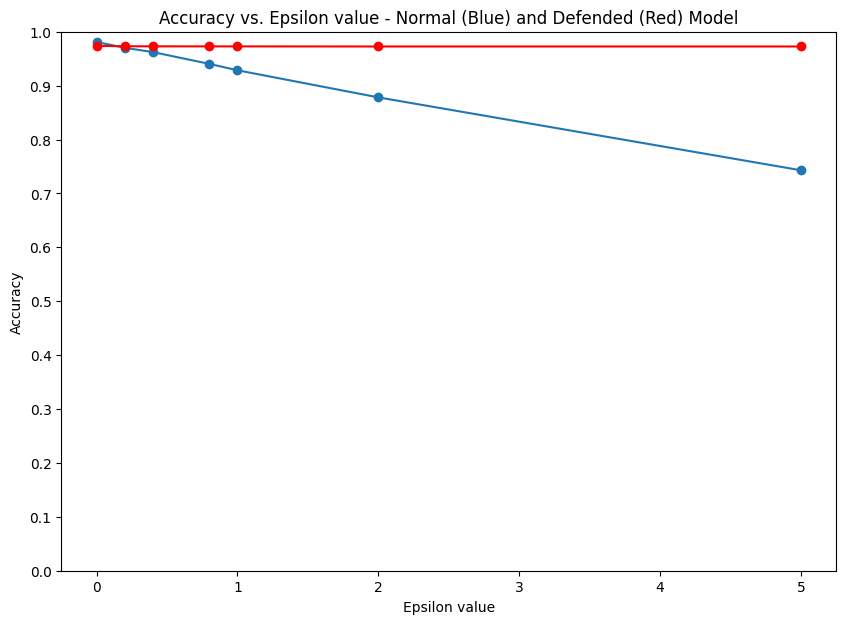

In [25]:
# Initialize figure
plt.figure(figsize = (10, 7))

# Display accuracy vs. Epsilon values plot
plt.plot(epsilons, accuracies, "o-")
plt.plot(epsilons, accuracies2, "o-", color = "red")

# Adjust x-axis and y-axis labels and ticks
plt.yticks(np.arange(0, 1.1, step = 0.1))
#plt.xticks(np.arange(0, .35, step = 0.05))
plt.title("Accuracy vs. Epsilon value - Normal (Blue) and Defended (Red) Model")
plt.xlabel("Epsilon value")
plt.ylabel("Accuracy")

# Display
plt.show()

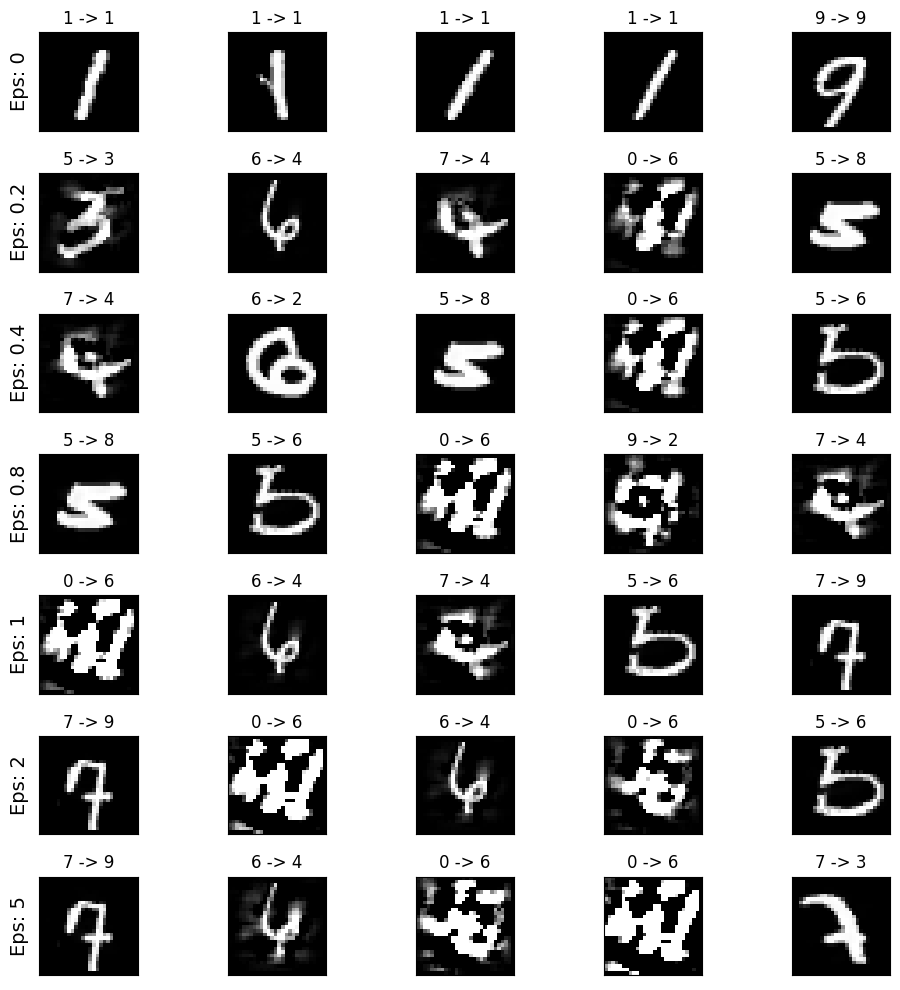

In [26]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0

# Initialize figure
plt.figure(figsize = (10, 10))

# Browse through epsilon values and adversarial examples
for i in range(len(epsilons)):
    for j in range(len(examples2[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples2[0]), cnt)
        
        # Remove x-axis and y-axis ticks from plot
        plt.xticks([], [])
        plt.yticks([], [])
        
        # Labels for y axis
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize = 14)
            
        # Labels for each image subplot
        orig, adv, ex = examples2[i][j]
        plt.title("{} -> {}".format(orig, adv))
        
        # Display image
        plt.imshow(ex, cmap = "gray")
        
# Display full plot
plt.tight_layout()
plt.show()